<a href="https://colab.research.google.com/github/alliwene/dsn-bootcamp-20-loan-default/blob/master/loan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import Neccessary packages

In [ ]:
!pip install --quiet catboost
!pip install --quiet optuna 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
import catboost as cb
import seaborn as sns
import lightgbm as lgb
import warnings 
from sklearn.ensemble import RandomForestClassifier
import optuna
import pickle

warnings.simplefilter(action='ignore')

In [ ]:
%matplotlib inline
plt.style.use('seaborn-notebook')
plt.rcParams["figure.figsize"] = (20, 3)
pd.options.display.float_format = '{:20,.4f}'.format
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
sns.set(context="paper", font="monospace")

## Helper Functions

In [ ]:
class func():    
    def __init__(self, train, label, test, model, model_type, random_state):
        self.train, self.label, self.test = train, label, test
        self.model, self.model_type = model, model_type
        self.random_state = random_state
        
        assert self.model_type in ('catboost', 'xgboost', 'lgbm', 'rf'), 'Incorrect model_type'

    def __call__(self, plot = True):
        return self.fit(plot)

    def fit(self, plot):
        def catboost_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=300,
                           verbose=50,use_best_model=True)
            x_test_predict = self.model.predict_proba(X_test)[:,1]
            x_train_predict = self.model.predict_proba(X_train)[:,1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test)[:,1]
            return x_test_predict, x_train_predict

        def xgboost_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train, y_train, early_stopping_rounds = 30, eval_metric="auc",
                           eval_set=[(X_test, y_test)], verbose = True)
            x_test_predict = self.model.predict_proba(X_test, ntree_limit = self.model.get_booster().best_ntree_limit)[:,1]
            x_train_predict = self.model.predict_proba(X_train, ntree_limit = self.model.get_booster().best_ntree_limit)[:,1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test, ntree_limit = self.model.get_booster().best_ntree_limit)[:,1]
            return x_test_predict, x_train_predict

        def lgbm_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train, y_train, early_stopping_rounds = 30, eval_metric="auc",
                           eval_set=[(X_test, y_test)], verbose = True)
            x_test_predict = self.model.predict_proba(X_test, num_iteration = self.model.best_iteration_)[:,1]
            x_train_predict = self.model.predict_proba(X_train, num_iteration = self.model.best_iteration_)[:,1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test, num_iteration = self.model.best_iteration_)[:,1]
            return x_test_predict, x_train_predict

        def rf_fit(X_train, X_test, y_train, y_test):
          self.model.fit(X_train,y_train)
          x_test_predict = self.model.predict_proba(X_test)[:,1]
          x_train_predict = self.model.predict_proba(X_train)[:,1]
          self.val_p[test_index] = x_test_predict
          self.test_p += self.model.predict_proba(self.test)[:,1]
          return x_test_predict, x_train_predict


        self.val_p = np.zeros(self.train.shape[0])
        mean_val = []
        mean_train = []
        self.test_p = np.zeros(self.test.shape[0])
        splits = 10
        kf = StratifiedKFold(n_splits = splits)
        for fold_count, (train_index, test_index) in enumerate(kf.split(self.train, self.label)):
            X_train,X_test = self.train.iloc[train_index],self.train.iloc[test_index]
            y_train,y_test = self.label.iloc[train_index],self.label.iloc[test_index]

            print(f"================================Fold{fold_count+1}====================================")
            if self.model_type == 'catboost': x_test_predict, x_train_predict = catboost_fit(X_train, X_test, y_train, y_test)
            elif self.model_type == 'xgboost': x_test_predict, x_train_predict = xgboost_fit(X_train, X_test, y_train, y_test)
            elif self.model_type == 'lgbm': x_test_predict, x_train_predict = lgbm_fit(X_train, X_test, y_train, y_test)
            elif self.model_type == 'rf': x_test_predict, x_train_predict = rf_fit(X_train, X_test, y_train, y_test)

            print('\nValidation scores', roc_auc_score(y_test, x_test_predict))
            print('Training scores', roc_auc_score(y_train, x_train_predict))
            mean_val.append(roc_auc_score(y_test, x_test_predict))
            mean_train.append(roc_auc_score(y_train, x_train_predict))

        if plot:
            feat_imp = pd.DataFrame(sorted(zip(self.model.feature_importances_,self.train.columns)), columns=['Value','Feature'])
            plt.figure(figsize=(30,25))
            sns.barplot(x="Value", y="Feature", data=feat_imp.sort_values(by="Value", ascending=False))
            plt.ylabel('Feature Importance Score')
            plt.show()
        print(np.mean(mean_val), np.mean(mean_train))
        return self.val_p, self.test_p/splits, self.model

In [ ]:
def quality_report(df):
    """
    Description: Displays quality of data in terms of missing values, unique numbers, datatypes etc.
    Arguments: Dataframe
    """
    dtypes = df.dtypes
    nuniq = df.T.apply(lambda x: x.nunique(), axis=1)
    total = df.isnull().sum().sort_values(ascending = False)
    percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
    quality_df  = pd.concat([total, percent, nuniq, dtypes], axis=1, keys=['Null Total', 'Null Percent','Nunique', 'Dtype'])
    display(quality_df)


def object_count_plot(df):
    """
    Description : Plot countplot for all categorical features present in the dataframe passed
    Argument : Dataframe
    """
    
    for var in df.columns:
        if df[var].dtype == 'object':
            print(df[var].value_counts())
            plt.figure(figsize=(12,5))
            g = sns.countplot(x=var,data=df)
            g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")
            plt.tight_layout()
            plt.show()
            
def numeric_distribution_plot(df):
    """
    Description : Gives distribution plot for all the numeric features in the dataframe passed
    Argument : Dataframe
    """
    for col in df.columns:
        if df[col].dtype != 'object':
            print(df[col].describe())
            plt.figure(figsize=(12,5))
            plt.title("Distribution of "+col)
            ax = sns.distplot(df[col].dropna())
            plt.tight_layout()
            plt.show()

## Read and Lookup Data

In [ ]:
path = '/content/drive/My Drive/loan_default/'

In [ ]:
train = pd.read_csv(path + 'Train.csv')
test = pd.read_csv(path + 'Test.csv')

sub = pd.read_csv(path + 'SampleSubmission.csv')

In [ ]:
train.sample(5)

,Applicant_ID,form_field1,form_field2,form_field3,form_field4,form_field5,form_field6,form_field7,form_field8,form_field9,form_field10,form_field11,form_field12,form_field13,form_field14,form_field15,form_field16,form_field17,form_field18,form_field19,form_field20,form_field21,form_field22,form_field23,form_field24,form_field25,form_field26,form_field27,form_field28,form_field29,form_field30,form_field31,form_field32,form_field33,form_field34,form_field35,form_field36,form_field37,form_field38,form_field39,form_field40,form_field41,form_field42,form_field43,form_field44,form_field45,form_field46,form_field47,form_field48,form_field49,form_field50,default_status
40512,Apcnt_1231924,"3,622.0000",nan,0.0000,0.0000,0.0000,"203,836.0000","12,309,516.0000","422,843.0000","49,231,840.0000","16,947,952.0000",nan,"17,315,168.0000","8,254,580.0000",48187375,nan,0.0000,0.0000,0.0000,3.0000,4.0000,141.8400,nan,nan,141.8400,"5,484.0000","15,057.0000","10,038.0000","1,582.0000","36,045.0000","6,692.0000",nan,"2,404.0000",22.5000,0.0000,nan,12.0000,20.0000,0.0000,0.0000,nan,98.2245,0.0000,8.0800,0.5275,0.0000,0.0000,charge,nan,3.0000,nan,no
48399,Apcnt_957028,nan,1.3151,0.0642,0.0000,0.0000,nan,nan,nan,nan,0.0000,"411,951.0000",nan,nan,30839920,"26,840,611.0000",nan,nan,nan,0.0000,0.0000,nan,nan,nan,nan,nan,nan,nan,244.0000,"6,570.0000",nan,nan,nan,8.0000,0.0000,nan,6.0000,nan,4.0000,0.0000,nan,nan,1.3750,0.0000,nan,nan,nan,charge,nan,0.0000,nan,yes
23341,Apcnt_1133620,"3,634.0000",0.3578,0.0000,0.0000,0.0000,"134,983.0000","1,217,181.0000","339,208.0000","1,676,979.0000","1,922,438.0000",nan,"585,834.0000","1,509,709.0000",16576457,"68,463,222.0000",0.0000,0.0000,0.0000,0.0000,0.0000,82.9050,"6,805.9650","6,461.5350",52.4100,547.5000,"1,734.0000","1,156.0000","60,772.0000","1,734.0000",730.0000,nan,72.0000,6.8334,0.0000,0.0000,6.0000,0.0000,10.0000,0.0000,nan,129.6045,0.0000,5.0500,0.7437,nan,0.0000,charge,86.0639,0.0000,0.1012,no
718,Apcnt_1004168,"3,368.0000",0.0500,3.8918,15.4332,0.0000,nan,0.0000,nan,nan,0.0000,"4,907,235.0000",nan,0.0000,21973443,nan,nan,nan,nan,0.0000,0.0000,nan,nan,nan,nan,525.0000,nan,nan,0.0000,"12,594.0000","4,928.0000","12,594.0000",46.0000,0.3334,0.0000,nan,60.0000,2.0000,22.0000,0.0000,164.7090,nan,0.6325,18.1800,0.1070,nan,1.0000,lending,nan,0.0000,nan,yes
30298,Apcnt_1173412,"3,600.0000",0.1463,0.0000,0.0000,0.0000,"21,784.0000","463,299.0000","463,299.0000","1,541,996.0000","730,153.0000",nan,"1,056,524.0000","644,184.0000",9637475,"58,998,852.0000",0.0000,0.0000,0.0000,1.0000,1.0000,102.7950,"14,658.0000","14,658.0000",102.7950,"2,145.0000","7,482.0000","4,988.0000","60,772.0000","7,482.0000","3,832.0000",nan,188.0000,4.1666,0.0000,0.0000,6.0000,2.0000,4.0000,0.0000,nan,146.1885,0.0000,3.0300,0.7191,nan,0.0000,charge,72.0734,1.0000,0.1600,yes


In [ ]:
# target percentage
train['default_status'].value_counts(normalize = True) * 100

no                 75.5089
yes                24.4911
Name: default_status, dtype: float64

## EDA and Little Feature Engineering

charge     36373
lending    19627
Name: form_field47, dtype: int64


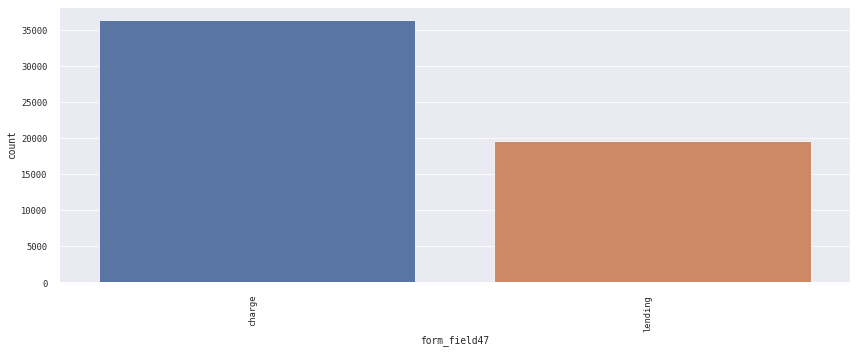

no     42285
yes    13715
Name: default_status, dtype: int64


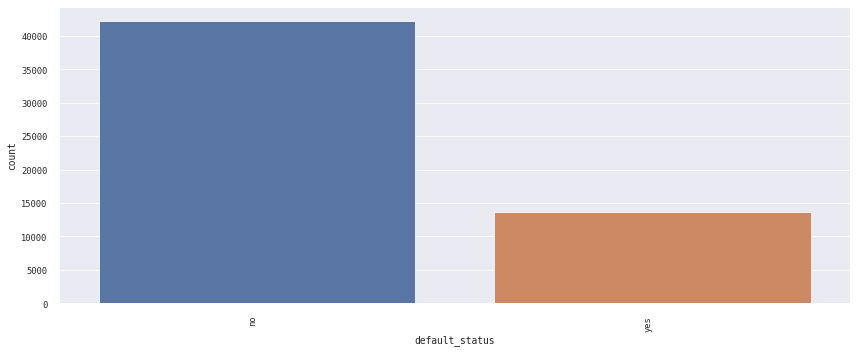

In [ ]:
# check and visualize categorical variables
object_count_plot(train.drop('Applicant_ID', axis = 1))

In [ ]:
# append train and test to data 
test['default_status'] = 'test'
data = pd.concat([train, test]).reset_index(drop = True)

In [ ]:
data.sample(5)

,Applicant_ID,form_field1,form_field2,form_field3,form_field4,form_field5,form_field6,form_field7,form_field8,form_field9,form_field10,form_field11,form_field12,form_field13,form_field14,form_field15,form_field16,form_field17,form_field18,form_field19,form_field20,form_field21,form_field22,form_field23,form_field24,form_field25,form_field26,form_field27,form_field28,form_field29,form_field30,form_field31,form_field32,form_field33,form_field34,form_field35,form_field36,form_field37,form_field38,form_field39,form_field40,form_field41,form_field42,form_field43,form_field44,form_field45,form_field46,form_field47,form_field48,form_field49,form_field50,default_status
25231,Apcnt_1144572,"3,724.0000",0.0372,0.0000,0.0000,0.0000,"192,944.0000","15,227,405.0000","15,227,405.0000","34,964,876.0000","13,765,543.0000",nan,"960,830.0000","10,344,288.0000",34694910,nan,0.0000,0.0000,0.0000,0.0000,0.0000,21.6900,4.1700,4.1700,9.7800,"2,035.5000","6,297.0000","4,198.0000","60,772.0000","22,356.0000",nan,nan,"1,160.0000",3.0000,0.0000,0.0000,4.0000,6.0000,6.0000,0.0000,nan,nan,0.0000,9.0900,0.7984,nan,nan,lending,"185,847.1954",0.0000,1.0078,no
33933,Apcnt_1194224,"3,304.0000",0.3728,2.0818,1.9332,0.0000,0.0000,"2,602,021.0000",0.0000,"1,107,483.0000","5,505,128.0000","104,641.0000","1,107,483.0000","374,996.0000",21973443,"205,085,468.0000",3.0000,3.0000,3.0000,3.0000,3.0000,187.3650,"18,736.9500",nan,247.3050,745.5000,"1,917.0000","1,278.0000",60.0000,"6,297.0000",nan,"4,470.0000",98.0000,32.0000,0.0000,3.0000,14.0000,0.0000,8.0000,0.0000,92.0460,nan,0.7857,2.0200,0.4132,nan,0.0000,charge,59.1039,0.9735,0.0504,no
17653,Apcnt_1101372,"3,504.0000",0.1351,0.4028,0.0000,0.0000,"73,910.0000","14,272,410.0000","748,825.0000","8,342,105.0000","15,174,890.0000",nan,"3,954,963.0000","1,518,656.0000",30839920,nan,0.0000,0.0000,0.0000,2.0000,2.0000,122.1300,nan,nan,122.1300,"6,342.0000","20,805.0000","13,870.0000",790.0000,"32,121.0000",nan,nan,"1,668.0000",20.0000,0.0000,nan,8.0000,10.0000,0.0000,0.0000,nan,nan,0.1833,3.0300,0.7760,0.0000,0.0000,charge,nan,1.4257,0.2705,no
65581,Apcnt_1126868,"3,686.0000",0.0000,0.0000,0.0000,0.0000,"192,944.0000","28,739,320.0000","9,251,976.0000","50,837,632.0000","142,973,449.0000",nan,"718,483.0000","2,483,765.0000",38549900,"140,321,636.0000",0.0000,0.0000,0.0000,0.0000,0.0000,34.9500,0.0000,nan,2.6850,"2,272.5000","9,672.0000","6,448.0000","2,920.0000","12,411.0000",nan,nan,"1,594.0000",29.1666,0.0000,0.0000,6.0000,14.0000,8.0000,0.0000,nan,nan,0.0379,20.2000,0.4013,0.0000,nan,lending,"718,483.0000",0.0000,1.3187,test
47158,Apcnt_949856,"3,548.0000",0.1171,0.0000,0.0000,0.0000,"95,694.0000","192,944.0000","192,944.0000","578,443.0000","404,171.0000",nan,"289,805.0000",0.0000,11564970,nan,0.0000,0.0000,0.0000,1.0000,1.0000,112.8000,"6,266.6700","7,519.9950",75.1950,183.0000,366.0000,244.0000,"60,772.0000",822.0000,nan,nan,16.0000,1.1666,0.0000,0.0000,2.0000,0.0000,6.0000,0.0000,nan,nan,0.0000,3.0300,0.8000,nan,nan,lending,46.2381,1.0000,0.0500,no


In [ ]:
quality_report(data)

,Null Total,Null Percent,Nunique,Dtype
form_field40,62557,78.1963,13623,float64
form_field31,56218,70.2725,412,float64
form_field41,54578,68.2225,19477,float64
form_field45,44855,56.0688,6,float64
form_field11,44819,56.0238,11543,float64
form_field23,40248,50.3100,22454,float64
form_field30,36417,45.5213,279,float64
form_field35,33014,41.2675,11,float64
form_field15,32067,40.0838,33069,float64
form_field48,29811,37.2638,45305,float64


In [ ]:
cat_feat = data.select_dtypes(exclude = np.number).columns
num_feat = data.select_dtypes(exclude = object).columns

In [ ]:
cat_feat

Index(['Applicant_ID', 'form_field47', 'default_status'], dtype='object')

In [ ]:
# Label encode and one hot encode
data['form_field47_LE'] = pd.factorize(data['form_field47'])[0]

data = pd.get_dummies(columns=['form_field47'], data = data, dtype=np.int64)

count            76,361.0000
mean              3,491.9422
std                 189.0752
min               2,986.0000
25%               3,358.0000
50%               3,484.0000
75%               3,620.0000
max               3,900.0000
Name: form_field1, dtype: float64


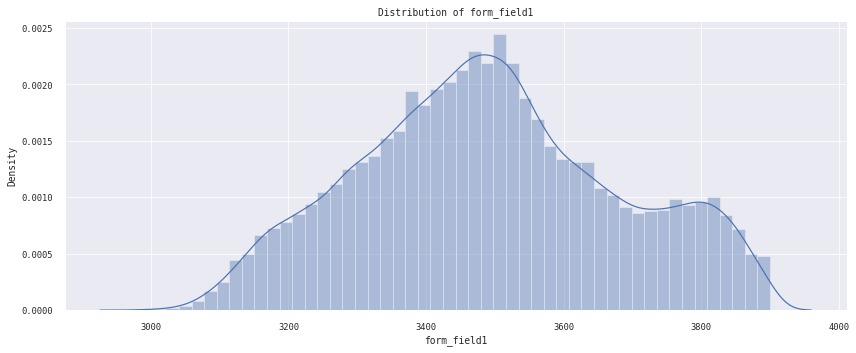

count            74,447.0000
mean                  0.5528
std                   0.8226
min                   0.0000
25%                   0.0701
50%                   0.2695
75%                   0.7225
max                  22.3150
Name: form_field2, dtype: float64


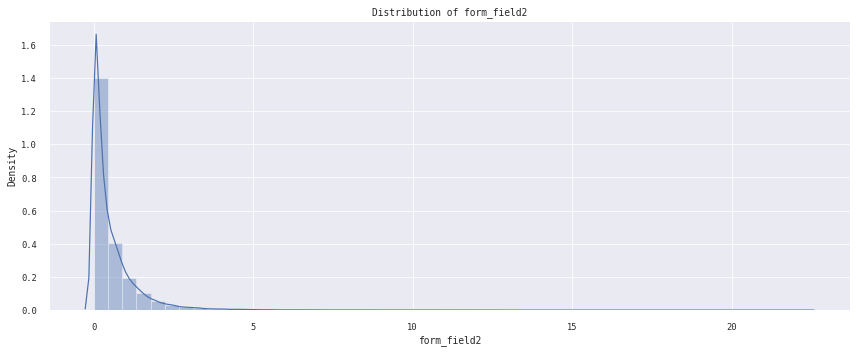

count            79,499.0000
mean                  1.0562
std                   2.1631
min                   0.0000
25%                   0.0000
50%                   0.0600
75%                   1.2894
max                  57.3716
Name: form_field3, dtype: float64


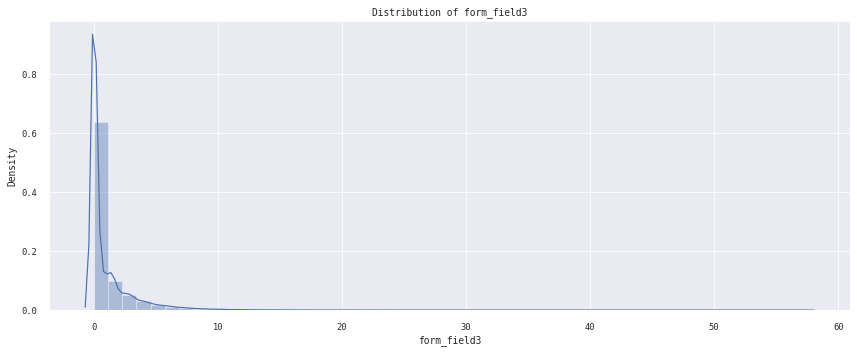

count            79,499.0000
mean                  0.8541
std                   3.2333
min                   0.0000
25%                   0.0000
50%                   0.0000
75%                   0.0000
max                 206.4528
Name: form_field4, dtype: float64


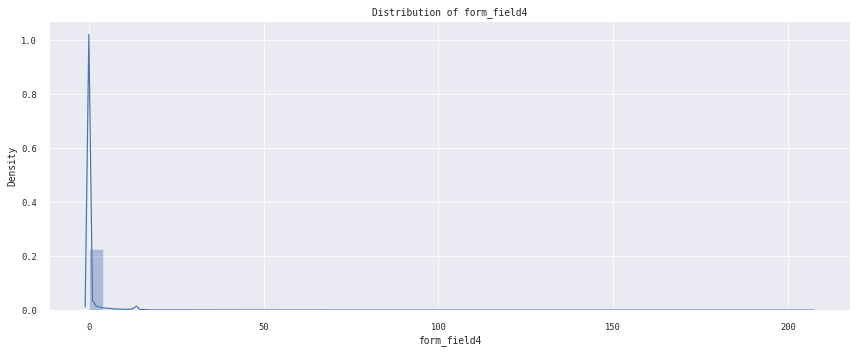

count            79,499.0000
mean                  2.0245
std                  10.7918
min                   0.0000
25%                   0.0000
50%                   0.0000
75%                   0.0000
max                 407.7486
Name: form_field5, dtype: float64


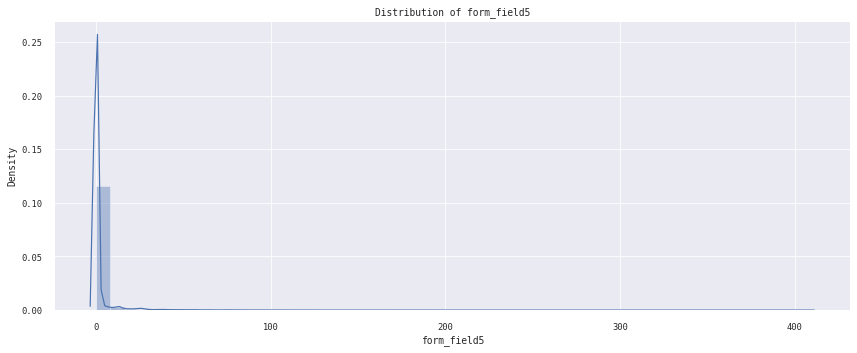

count            61,036.0000
mean            625,007.2229
std           1,440,721.4554
min                   0.0000
25%              14,004.0000
50%             115,533.0000
75%             522,524.2500
max          53,135,455.0000
Name: form_field6, dtype: float64


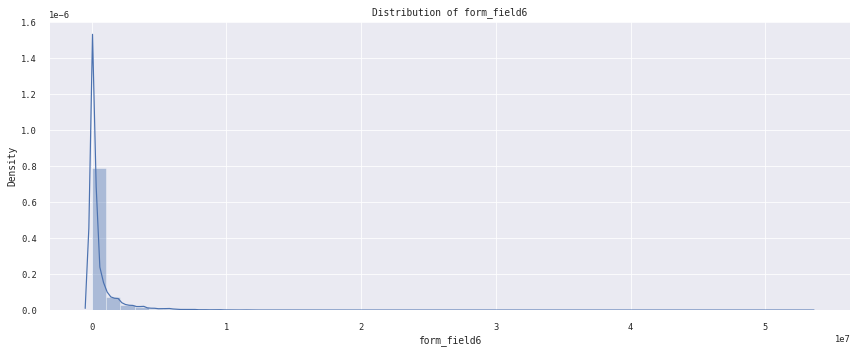

count            72,606.0000
mean          6,844,769.1317
std          18,314,758.5362
min                   0.0000
25%             683,084.0000
50%           2,710,163.0000
75%           7,023,686.7500
max       2,158,794,400.0000
Name: form_field7, dtype: float64


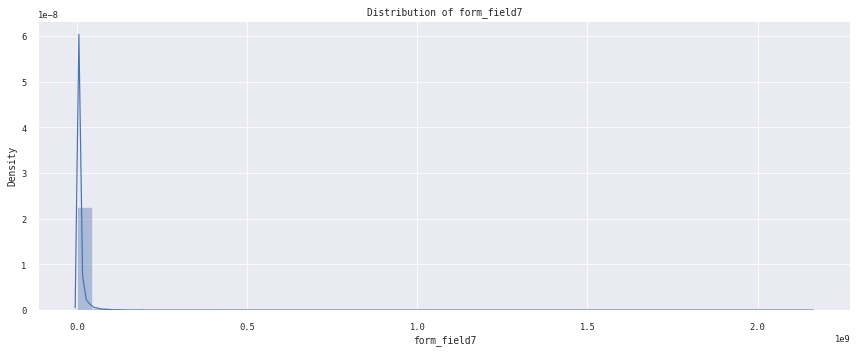

count            61,036.0000
mean          2,634,964.1109
std           3,939,692.9061
min                   0.0000
25%             190,610.0000
50%             963,942.0000
75%           3,767,173.2500
max         113,514,090.0000
Name: form_field8, dtype: float64


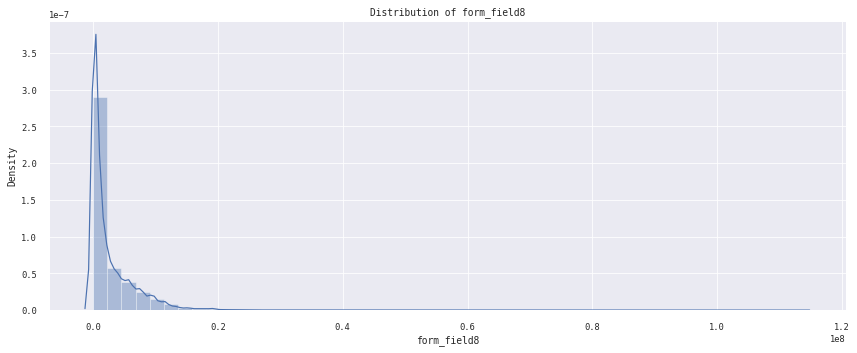

count            68,592.0000
mean         13,263,902.6090
std          20,763,620.0890
min                   0.0000
25%           1,360,722.0000
50%           5,512,519.0000
75%          17,059,108.7500
max       1,443,921,320.0000
Name: form_field9, dtype: float64


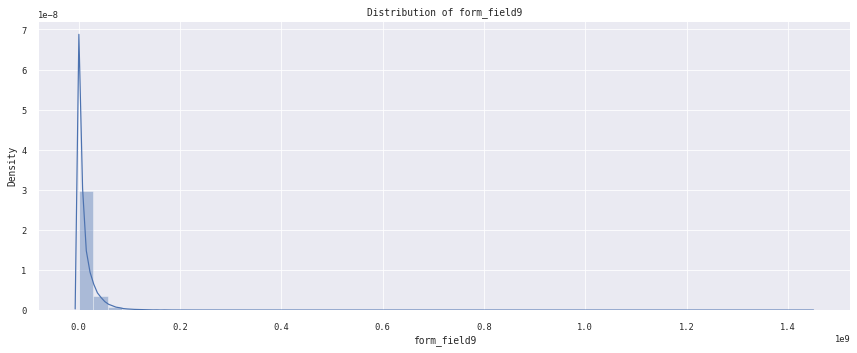

count            79,498.0000
mean         11,861,530.8620
std          26,132,184.9945
min                   0.0000
25%             441,126.0000
50%           3,692,582.5000
75%          13,235,919.5000
max       2,191,361,480.0000
Name: form_field10, dtype: float64


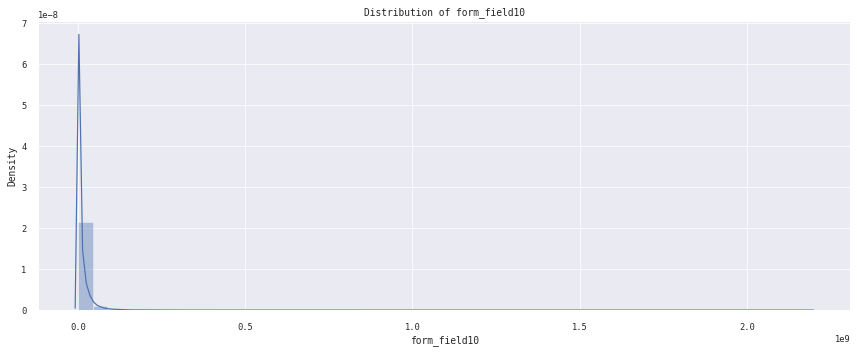

count            35,181.0000
mean          2,078,096.2488
std           5,174,039.4930
min                   0.0000
25%             213,950.0000
50%             692,420.0000
75%           1,963,283.0000
max         180,598,696.0000
Name: form_field11, dtype: float64


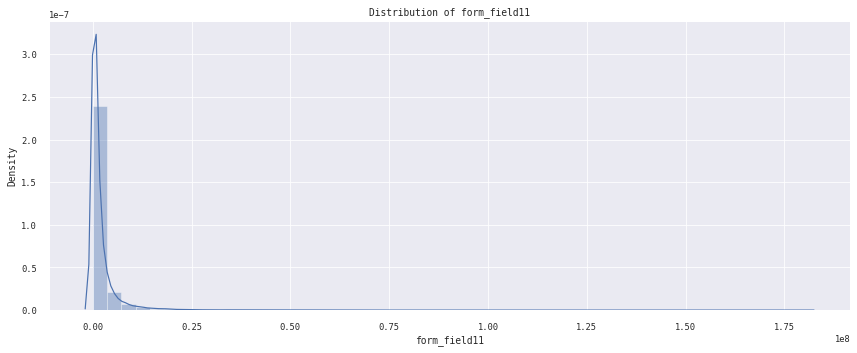

count            65,922.0000
mean          2,771,393.5957
std           4,621,145.0002
min                   0.0000
25%             274,634.0000
50%           1,158,247.5000
75%           3,368,740.0000
max         160,923,465.0000
Name: form_field12, dtype: float64


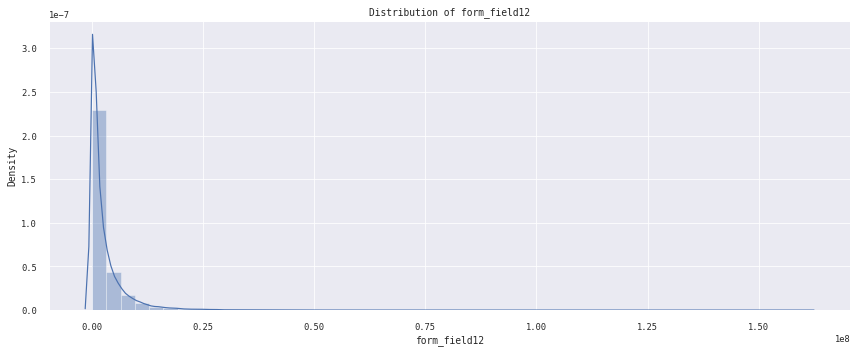

count            71,648.0000
mean          6,002,145.4677
std          22,263,049.4244
min                   0.0000
25%             194,111.0000
50%           1,591,010.0000
75%           5,590,027.2500
max       2,457,824,146.0000
Name: form_field13, dtype: float64


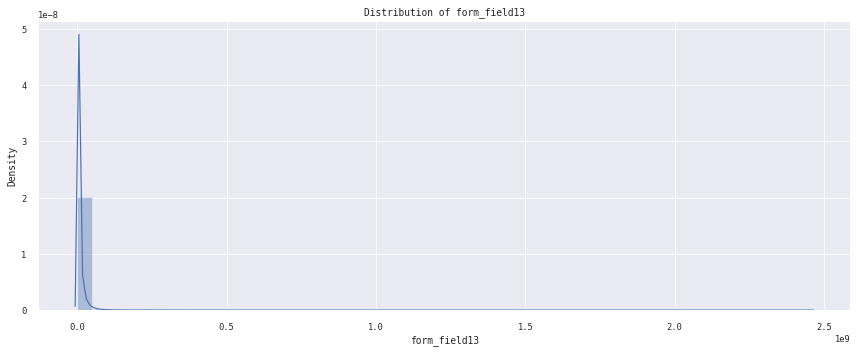

count            80,000.0000
mean         76,279,711.7706
std       3,068,578,796.1942
min                   0.0000
25%          16,576,457.0000
50%          28,141,427.0000
75%          48,187,375.0000
max     385,498,999,611.0000
Name: form_field14, dtype: float64


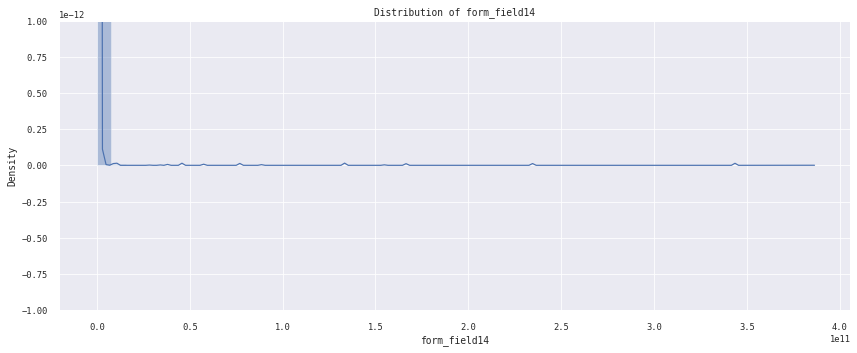

count            47,933.0000
mean        114,397,177.9446
std         116,605,245.5153
min             539,543.0000
25%          49,948,378.0000
50%          84,083,128.0000
75%         142,634,630.0000
max       3,897,066,574.0000
Name: form_field15, dtype: float64


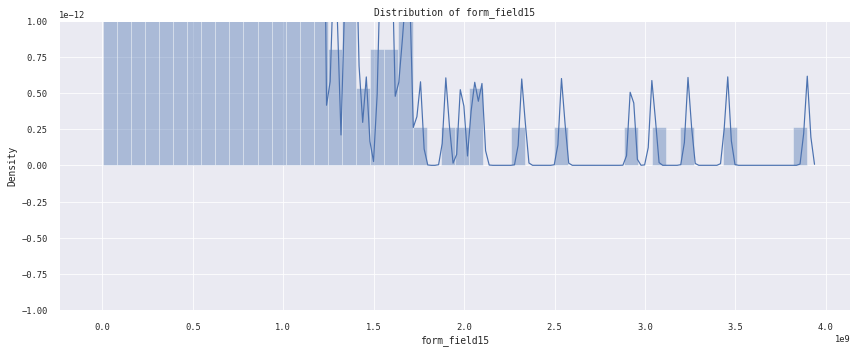

count            61,490.0000
mean                  0.2316
std                   0.6220
min                   0.0000
25%                   0.0000
50%                   0.0000
75%                   0.0000
max                  11.0000
Name: form_field16, dtype: float64


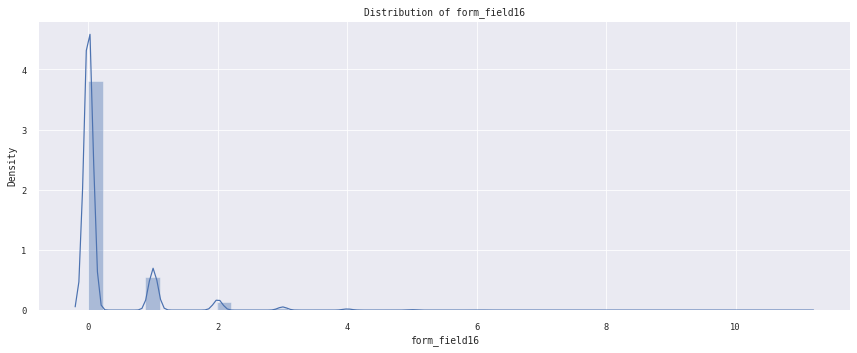

count            64,154.0000
mean                  0.2663
std                   0.7145
min                   0.0000
25%                   0.0000
50%                   0.0000
75%                   0.0000
max                  21.0000
Name: form_field17, dtype: float64


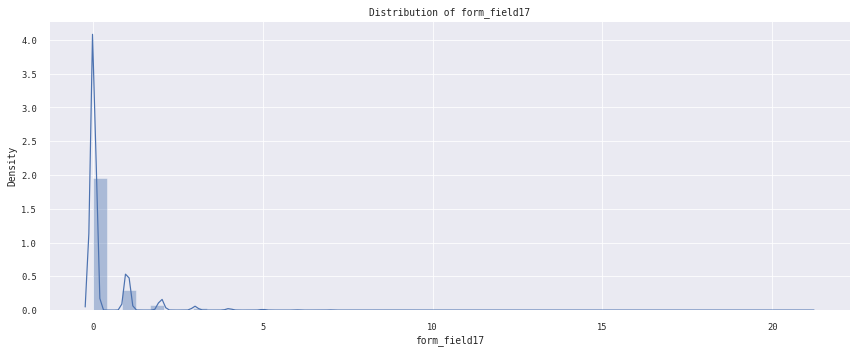

count            65,229.0000
mean                  0.2720
std                   0.7199
min                   0.0000
25%                   0.0000
50%                   0.0000
75%                   0.0000
max                  21.0000
Name: form_field18, dtype: float64


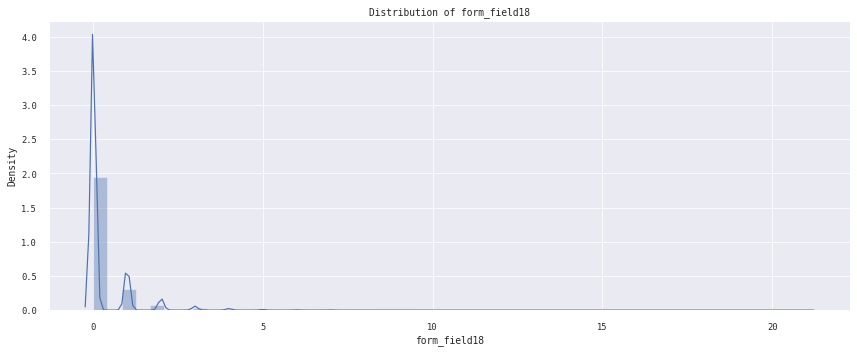

count            79,996.0000
mean                  0.9457
std                   1.7272
min                   0.0000
25%                   0.0000
50%                   0.0000
75%                   1.0000
max                  28.0000
Name: form_field19, dtype: float64


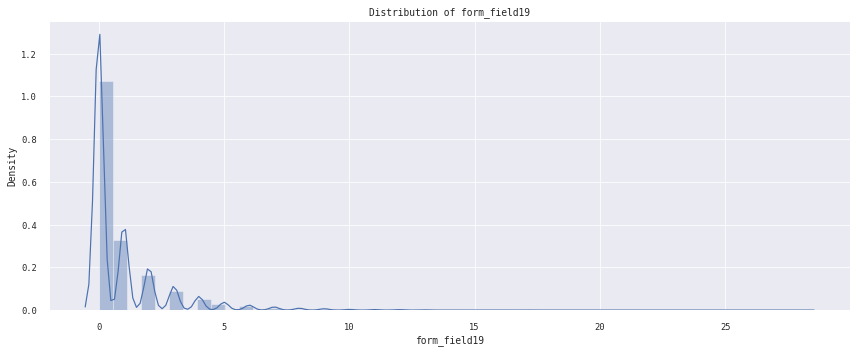

count            79,498.0000
mean                  1.0283
std                   1.7768
min                   0.0000
25%                   0.0000
50%                   0.0000
75%                   1.0000
max                  29.0000
Name: form_field20, dtype: float64


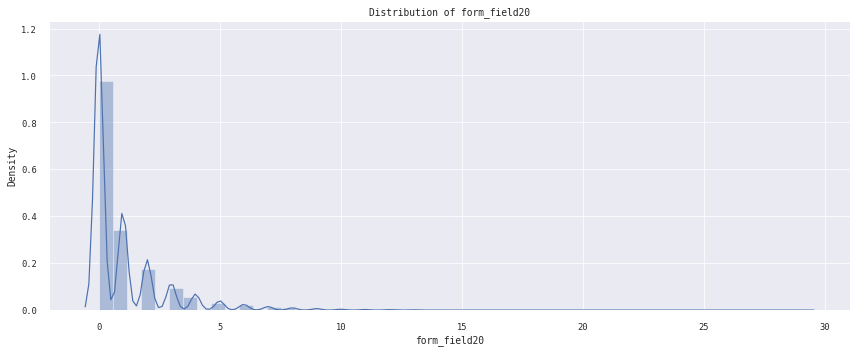

count            57,439.0000
mean                 86.6851
std                  53.3657
min                   0.2550
25%                  40.3950
50%                  89.5350
75%                 129.9300
max               1,957.8750
Name: form_field21, dtype: float64


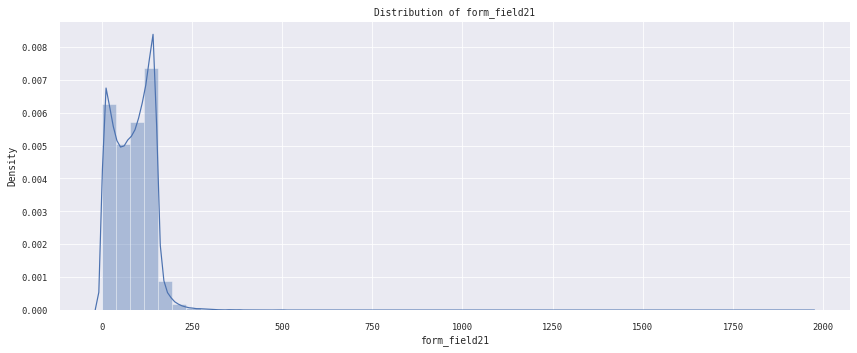

count            50,876.0000
mean              6,635.7848
std               5,673.0725
min                   0.0000
25%               1,090.0725
50%               5,961.6375
75%              11,368.9462
max              97,200.0000
Name: form_field22, dtype: float64


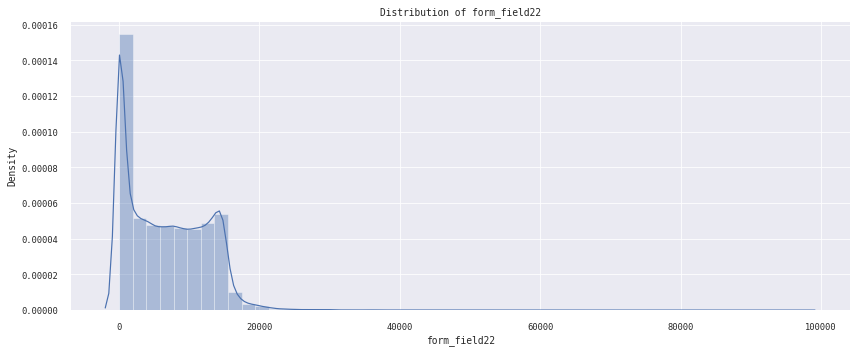

count            39,752.0000
mean              6,458.8947
std               5,797.3097
min                   0.0000
25%                 811.7362
50%               5,550.0000
75%              11,281.4250
max             186,799.9950
Name: form_field23, dtype: float64


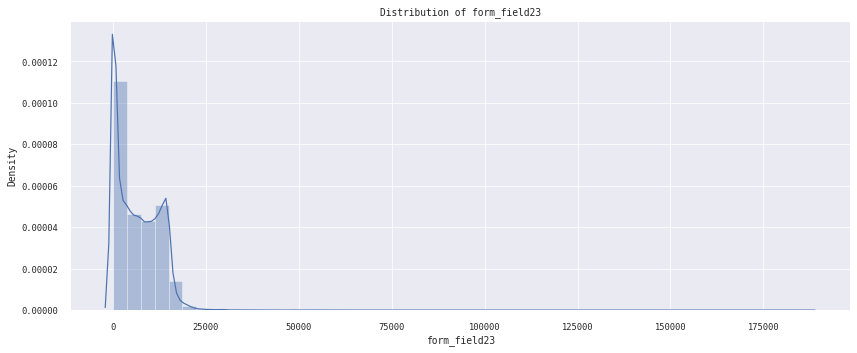

count            61,098.0000
mean                104.9728
std                 450.1207
min                   0.0000
25%                  14.8388
50%                  60.6600
75%                 114.8100
max              41,801.1000
Name: form_field24, dtype: float64


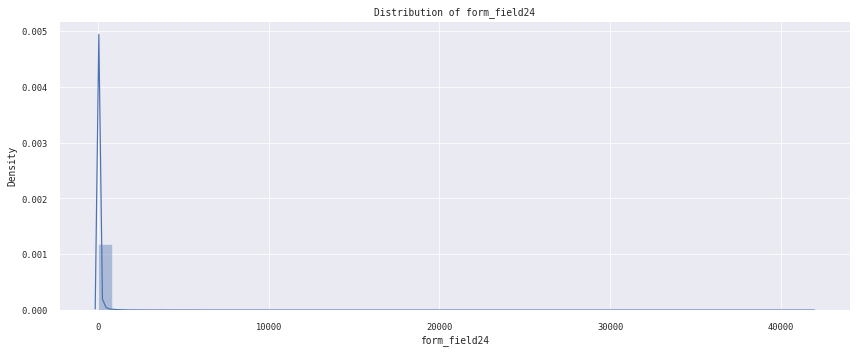

count            72,294.0000
mean              2,625.0980
std               1,959.0019
min                   0.0000
25%               1,231.5000
50%               2,208.0000
75%               3,529.1250
max              25,093.5000
Name: form_field25, dtype: float64


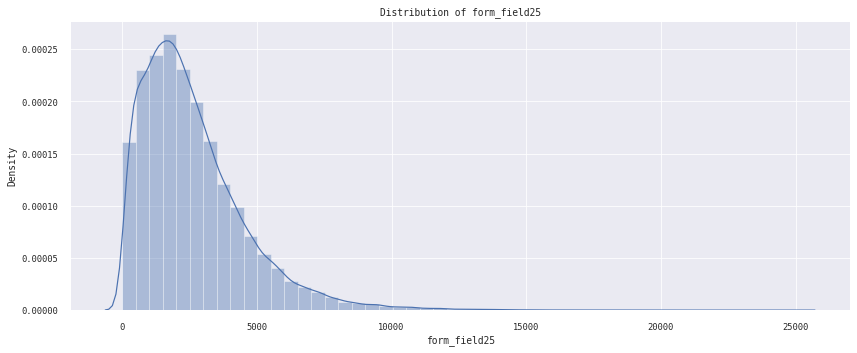

count            69,390.0000
mean             10,107.3655
std               8,793.7267
min                   0.0000
25%               3,375.0000
50%               8,214.0000
75%              14,145.0000
max              73,275.0000
Name: form_field26, dtype: float64


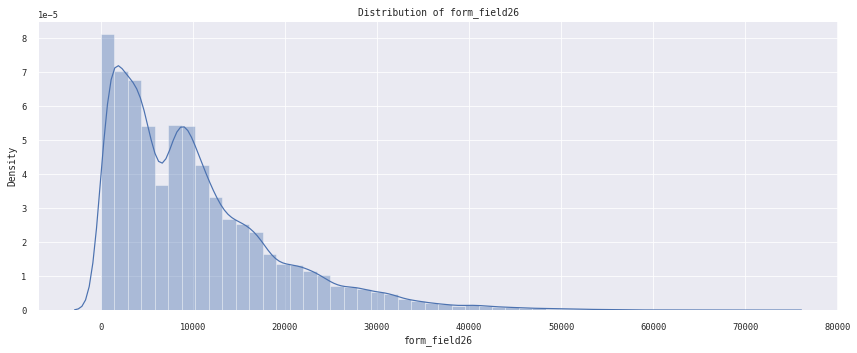

count            66,791.0000
mean              6,193.1603
std               5,390.1163
min                   0.0000
25%               2,068.0000
50%               5,110.0000
75%               8,638.0000
max              44,104.0000
Name: form_field27, dtype: float64


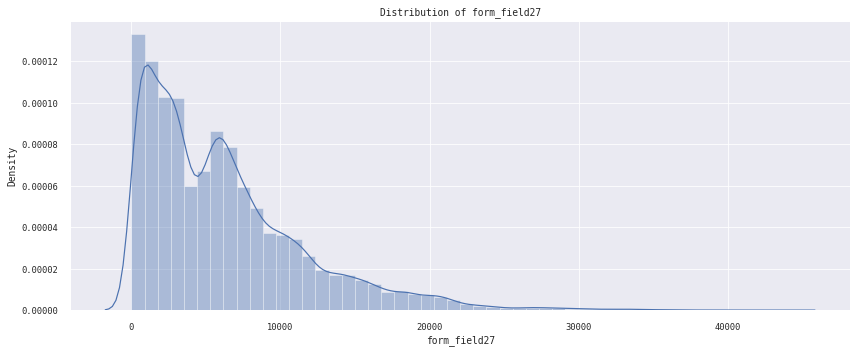

count            79,498.0000
mean             17,406.7044
std              26,998.3466
min                   0.0000
25%                  60.0000
50%                 486.0000
75%              60,772.0000
max              60,772.0000
Name: form_field28, dtype: float64


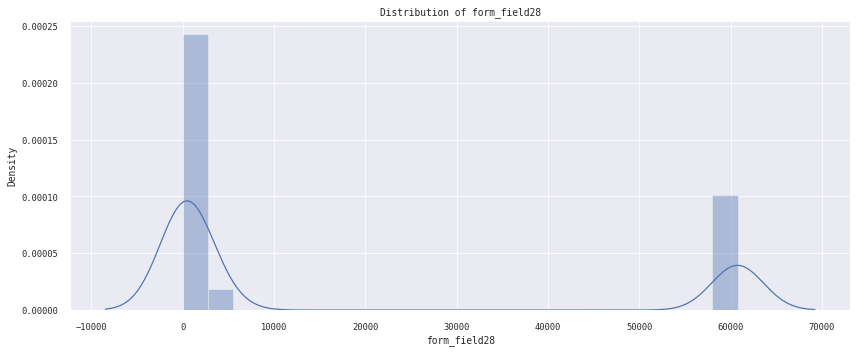

count            79,498.0000
mean             16,515.3522
std               9,667.9589
min                   0.0000
25%               9,765.0000
50%              15,057.0000
75%              21,810.0000
max              73,914.0000
Name: form_field29, dtype: float64


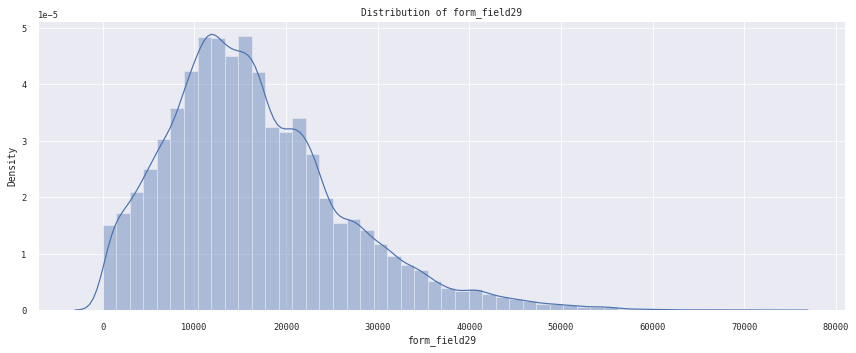

count            43,583.0000
mean              5,223.7605
std               3,128.6158
min                   0.0000
25%               2,312.0000
50%               5,658.0000
75%               7,726.0000
max              25,550.0000
Name: form_field30, dtype: float64


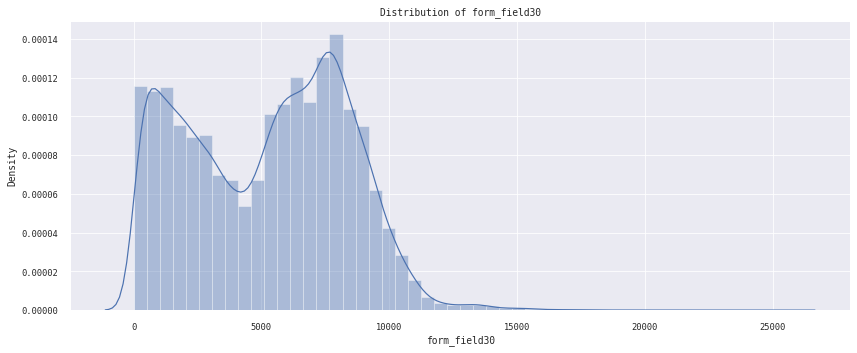

count            23,782.0000
mean             10,880.6790
std               6,085.9427
min                   0.0000
25%               6,297.0000
50%              10,584.0000
75%              14,235.0000
max              47,085.0000
Name: form_field31, dtype: float64


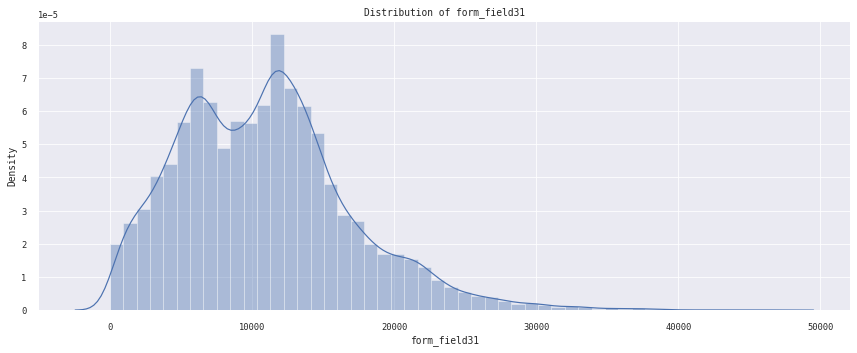

count            72,294.0000
mean                940.8618
std               1,048.6417
min                   0.0000
25%                 194.0000
50%                 600.0000
75%               1,334.0000
max              21,306.0000
Name: form_field32, dtype: float64


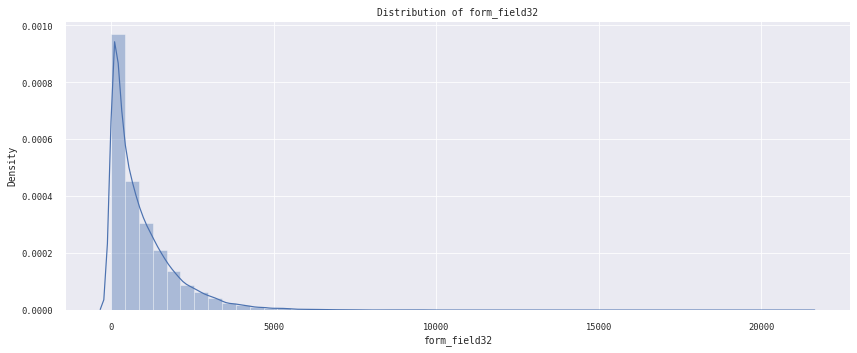

count            78,249.0000
mean                 13.9931
std                  15.3003
min                   0.1666
25%                   2.3334
50%                   7.8334
75%                  21.3334
max                 152.0000
Name: form_field33, dtype: float64


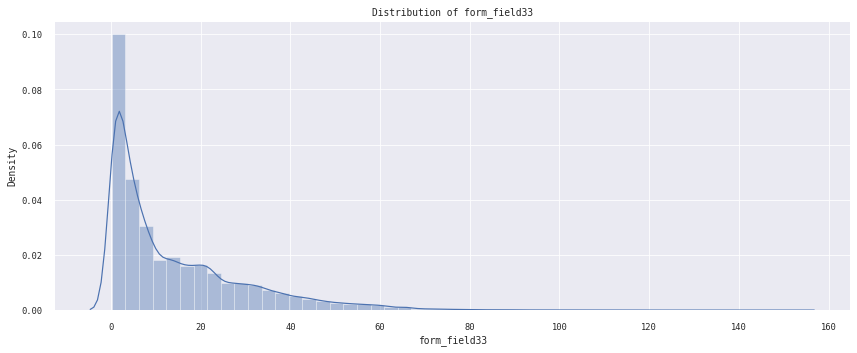

count            79,498.0000
mean                  0.2301
std                   0.6796
min                   0.0000
25%                   0.0000
50%                   0.0000
75%                   0.0000
max                  21.0000
Name: form_field34, dtype: float64


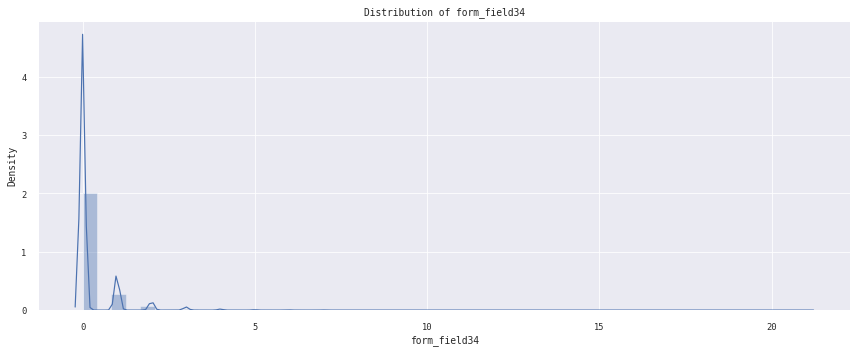

count            46,986.0000
mean                  0.1981
std                   0.5694
min                   0.0000
25%                   0.0000
50%                   0.0000
75%                   0.0000
max                  10.0000
Name: form_field35, dtype: float64


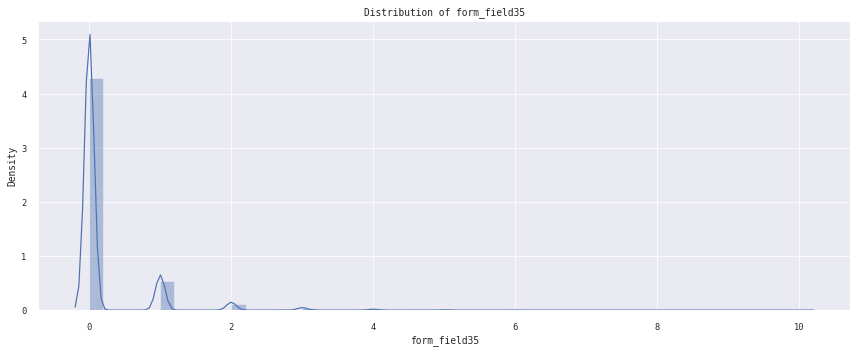

count            77,102.0000
mean                 12.8345
std                  10.5711
min                   2.0000
25%                   6.0000
50%                  10.0000
75%                  16.0000
max                 200.0000
Name: form_field36, dtype: float64


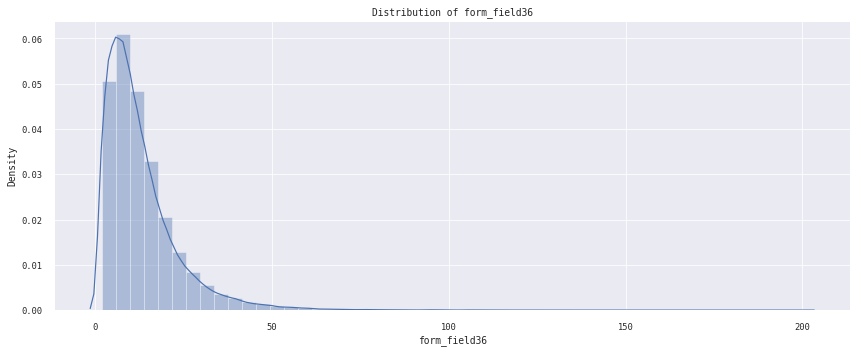

count            72,294.0000
mean                  8.5027
std                   9.3712
min                   0.0000
25%                   2.0000
50%                   6.0000
75%                  12.0000
max                 120.0000
Name: form_field37, dtype: float64


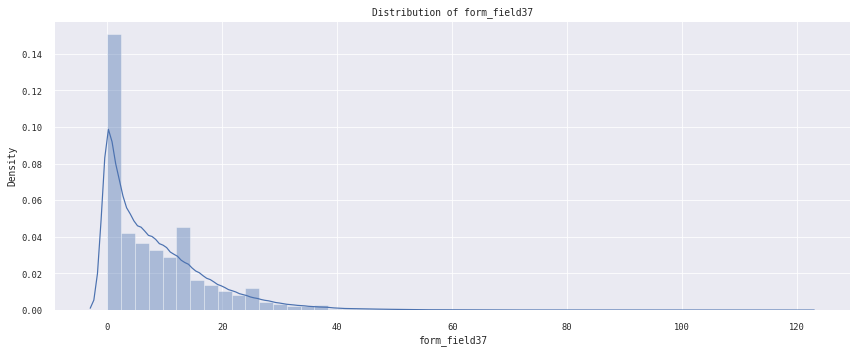

count            79,498.0000
mean                  8.5728
std                   7.9289
min                   0.0000
25%                   4.0000
50%                   6.0000
75%                  12.0000
max                 190.0000
Name: form_field38, dtype: float64


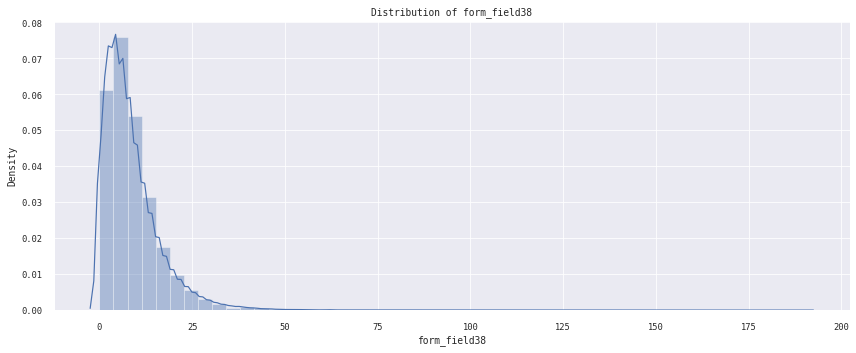

count            73,960.0000
mean                  0.0908
std                   0.4193
min                   0.0000
25%                   0.0000
50%                   0.0000
75%                   0.0000
max                  21.0000
Name: form_field39, dtype: float64


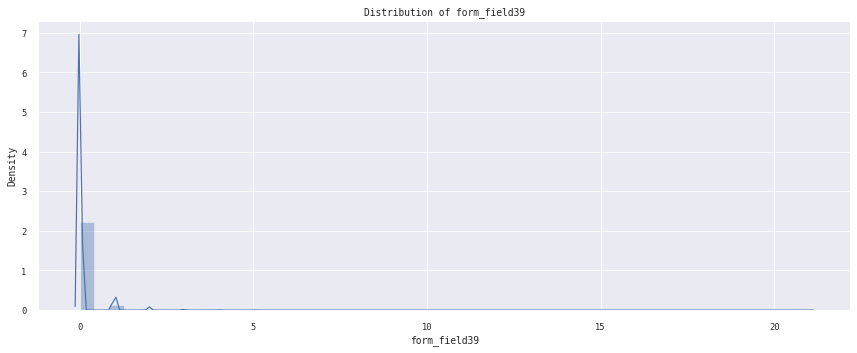

count            17,443.0000
mean                147.7462
std                  44.6436
min                   0.0210
25%                 136.0335
50%                 150.0000
75%                 167.5470
max                 645.4500
Name: form_field40, dtype: float64


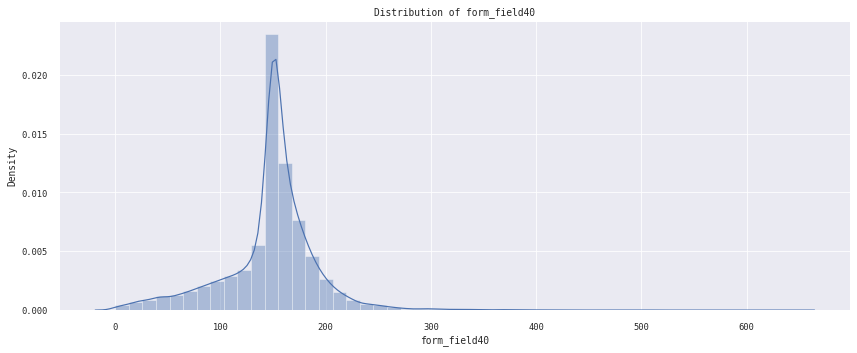

count            25,422.0000
mean                108.1451
std                  36.6632
min                   0.0000
25%                  87.2295
50%                 118.3252
75%                 137.4596
max                 255.0000
Name: form_field41, dtype: float64


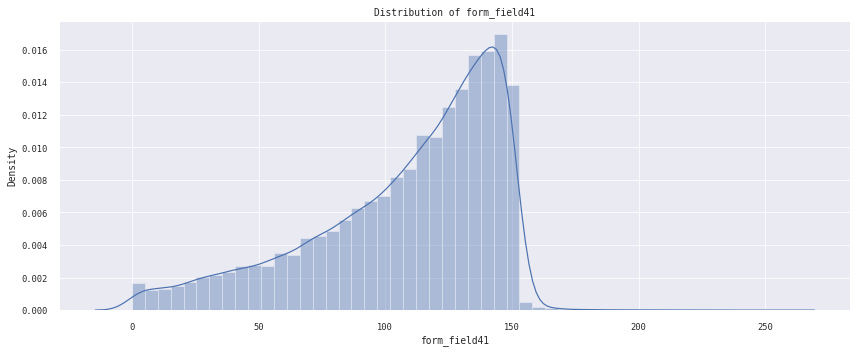

count            78,099.0000
mean                  0.3687
std                   0.4132
min                   0.0000
25%                   0.0000
50%                   0.2200
75%                   0.6286
max                   2.2000
Name: form_field42, dtype: float64


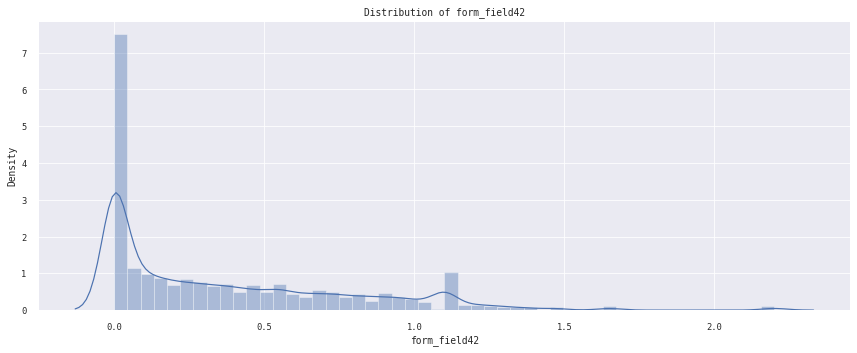

count            79,182.0000
mean                  6.6183
std                   6.3742
min                   0.0000
25%                   2.0200
50%                   5.0500
75%                  10.1000
max                  91.9100
Name: form_field43, dtype: float64


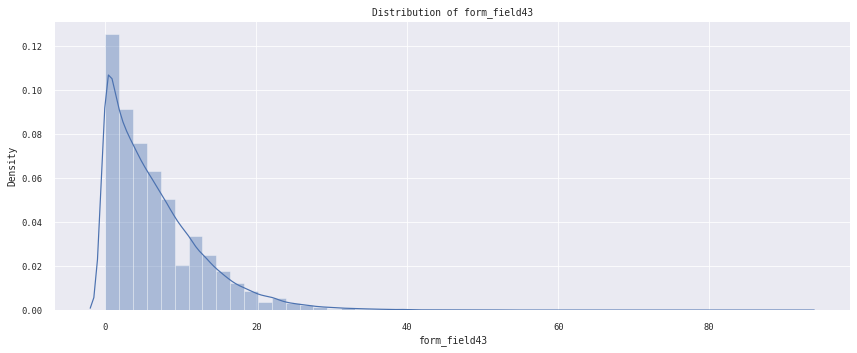

count            72,255.0000
mean                  0.5642
std                   0.1967
min                   0.0485
25%                   0.4122
50%                   0.5896
75%                   0.7548
max                   0.8000
Name: form_field44, dtype: float64


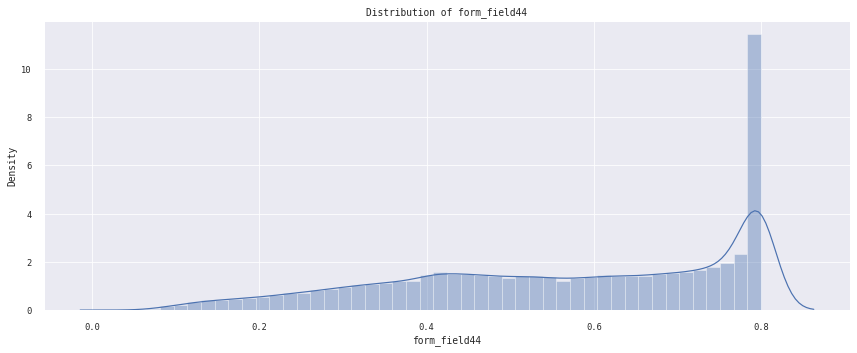

count            35,145.0000
mean                  0.0707
std                   0.2874
min                   0.0000
25%                   0.0000
50%                   0.0000
75%                   0.0000
max                   5.0000
Name: form_field45, dtype: float64


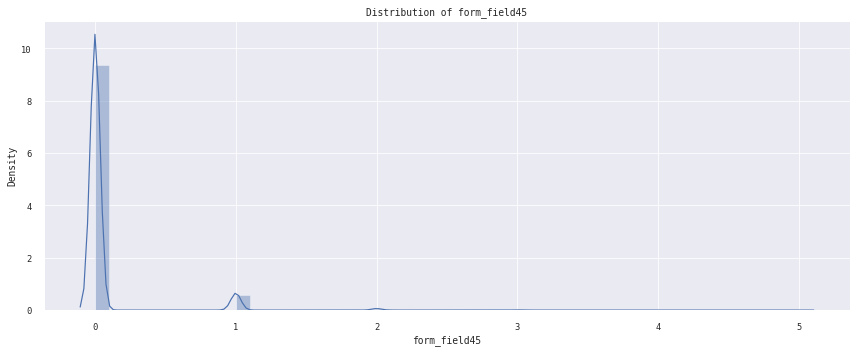

count            57,211.0000
mean                  0.0961
std                   0.3461
min                   0.0000
25%                   0.0000
50%                   0.0000
75%                   0.0000
max                  19.0000
Name: form_field46, dtype: float64


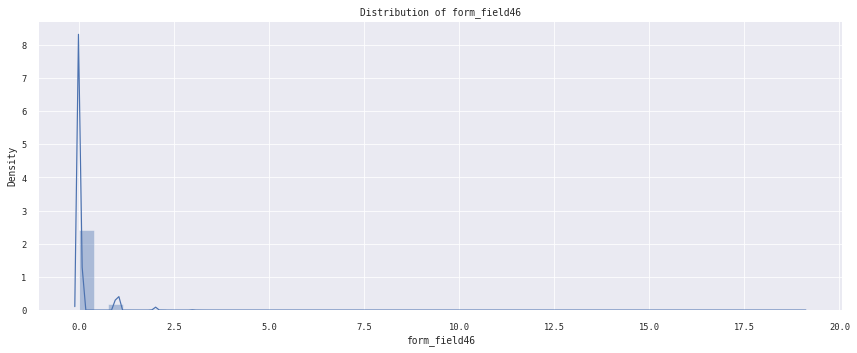

count            50,189.0000
mean            304,133.0828
std           1,717,064.8496
min                   0.0000
25%                  77.0655
50%                 316.7076
75%               1,167.0000
max         121,399,120.0000
Name: form_field48, dtype: float64


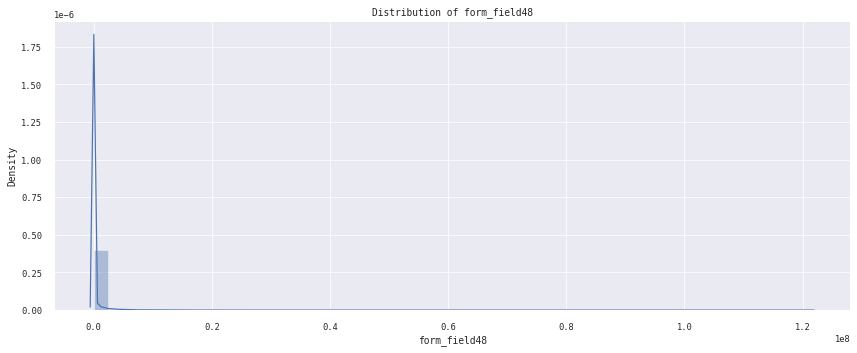

count            79,499.0000
mean                  1.0536
std                   1.8094
min                   0.0000
25%                   0.0000
50%                   0.0000
75%                   1.2010
max                  28.0000
Name: form_field49, dtype: float64


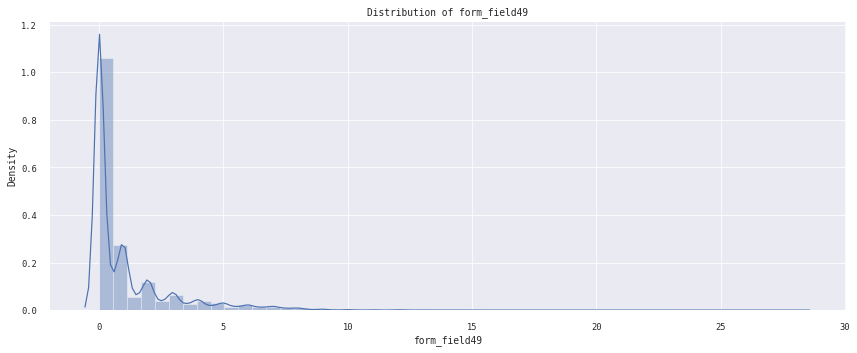

count            64,147.0000
mean            622,857.9577
std           6,066,509.8879
min                   0.0000
25%                   0.0455
50%                   0.1698
75%                   0.5000
max         252,459,055.3226
Name: form_field50, dtype: float64


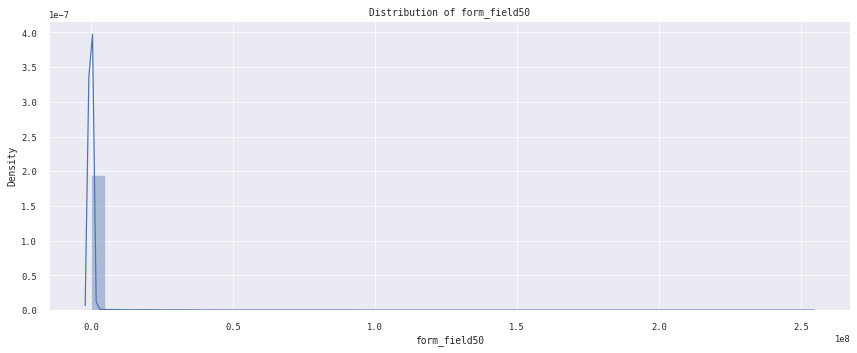

In [ ]:
# numeric disribution plot and details
numeric_distribution_plot(data[num_feat])

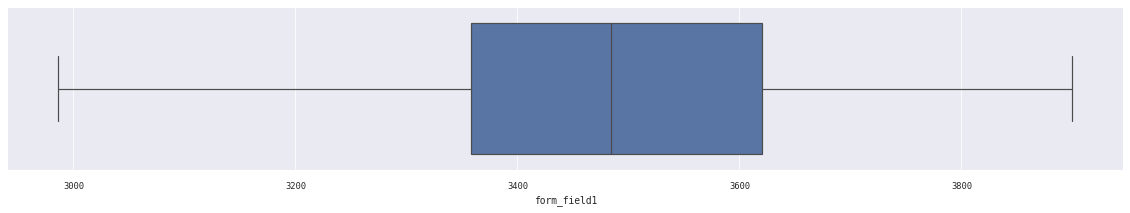

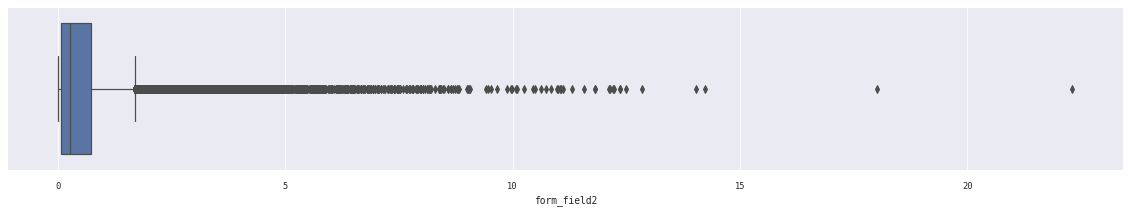

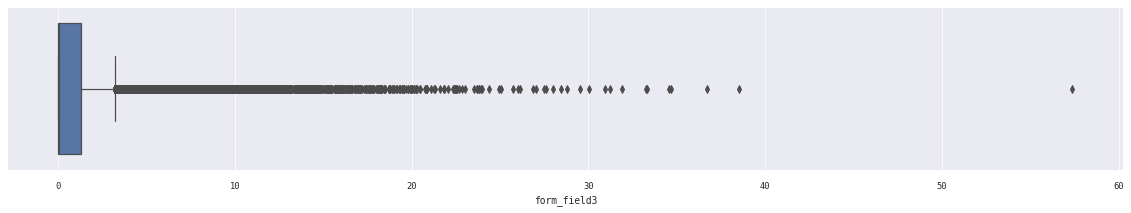

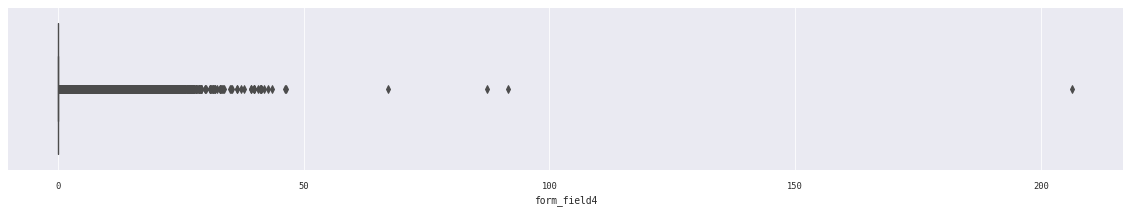

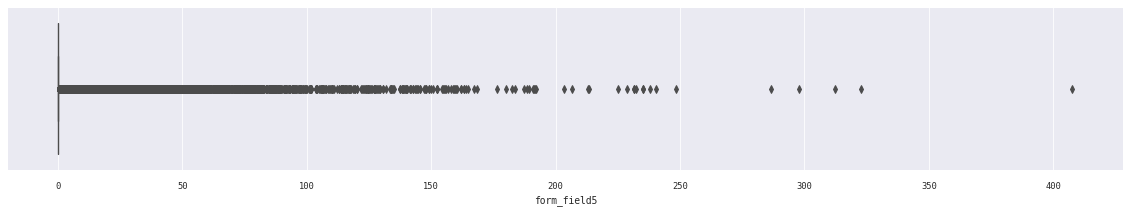

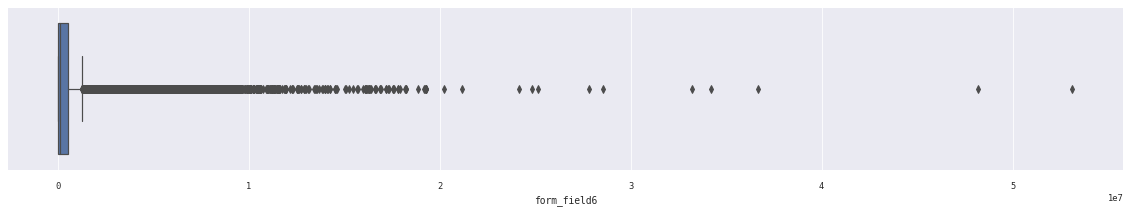

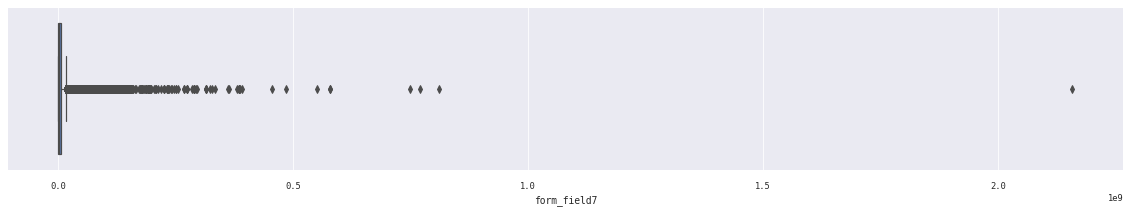

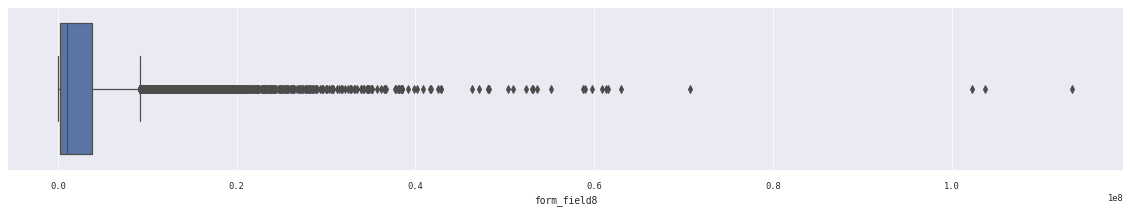

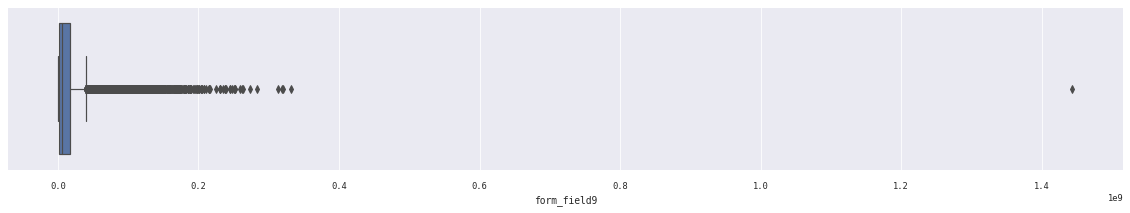

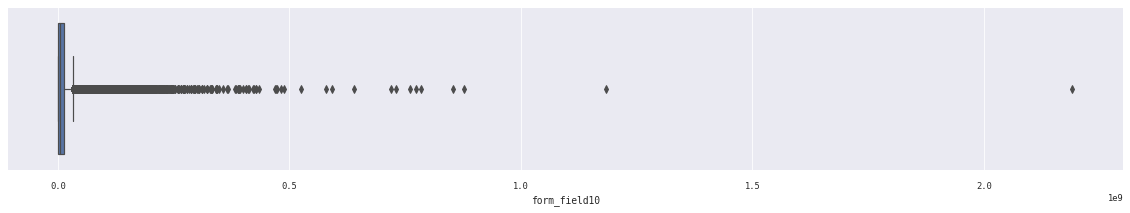

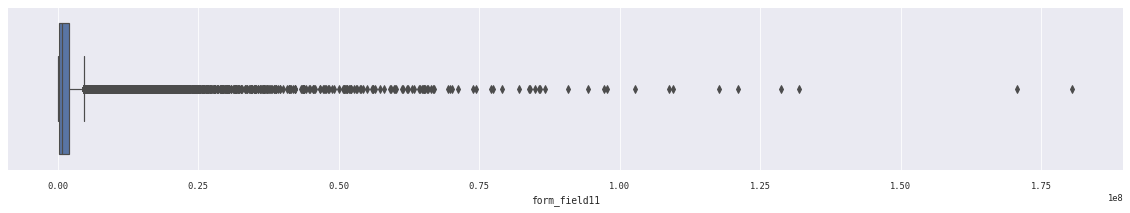

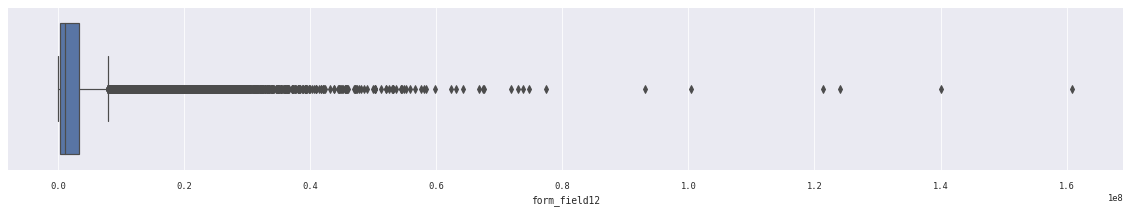

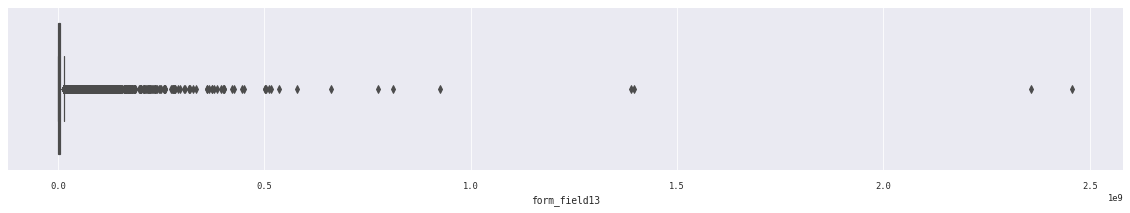

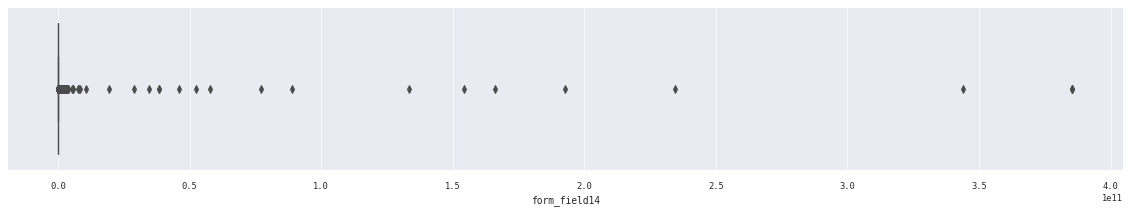

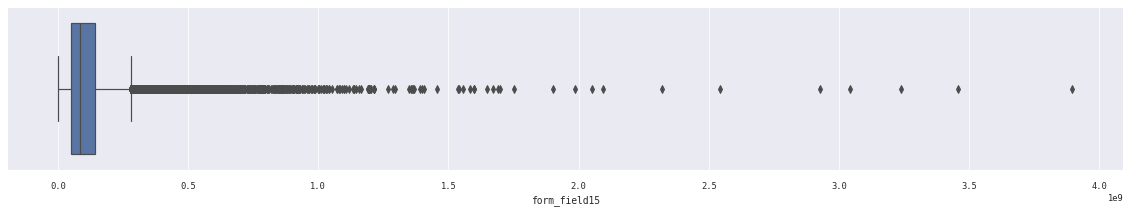

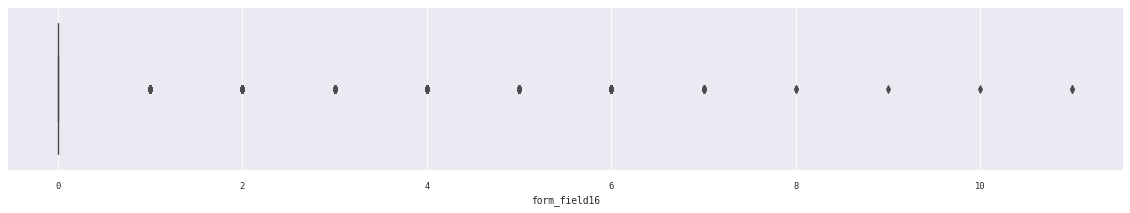

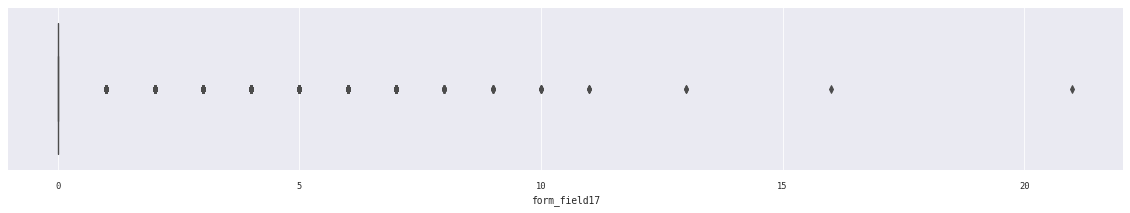

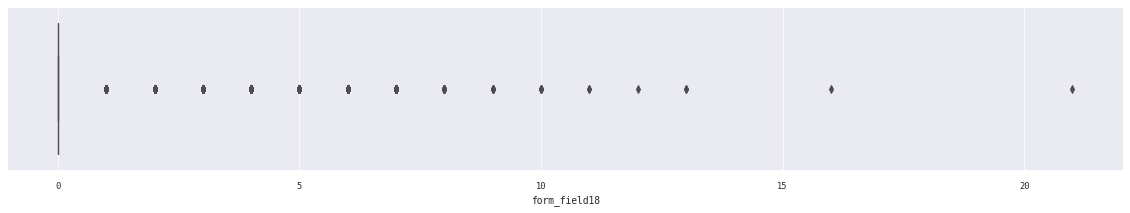

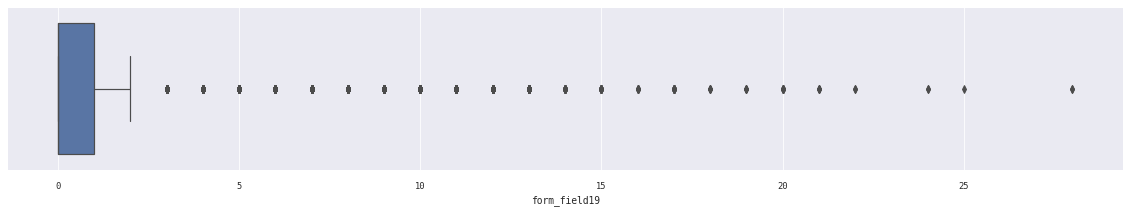

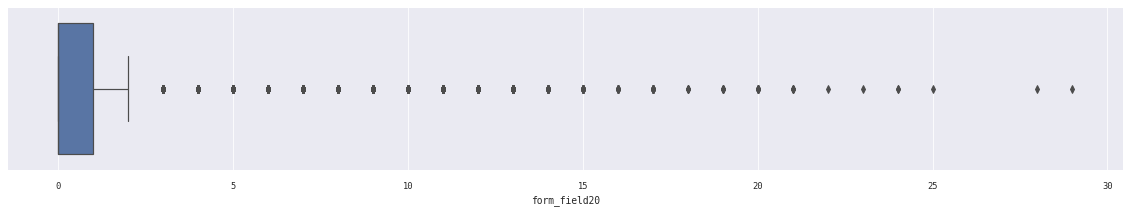

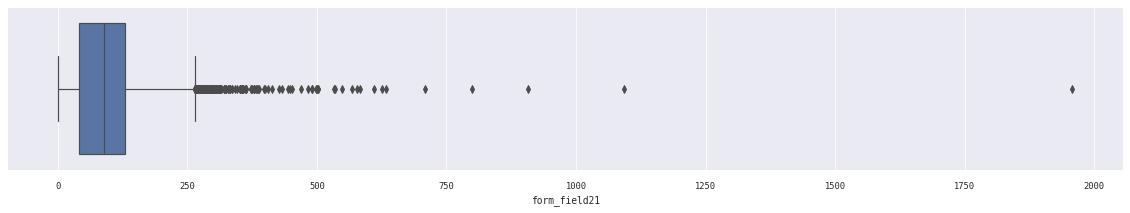

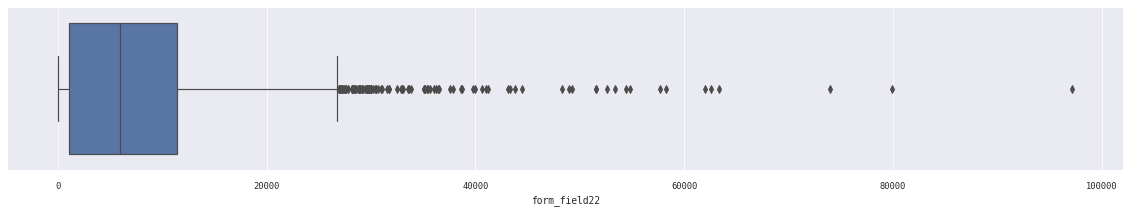

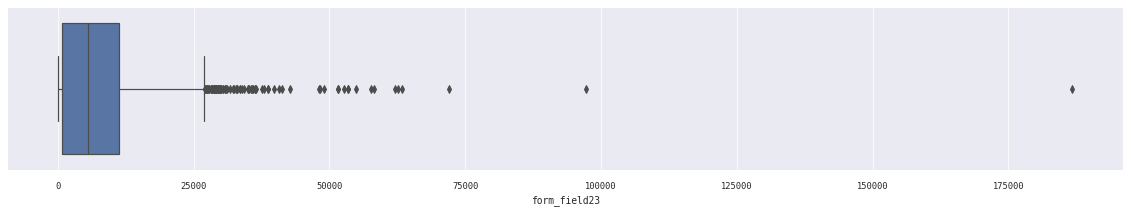

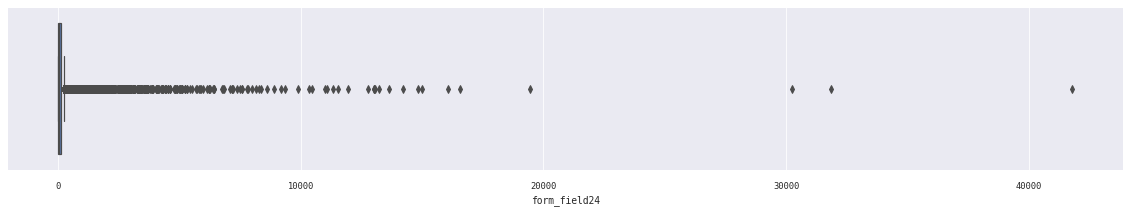

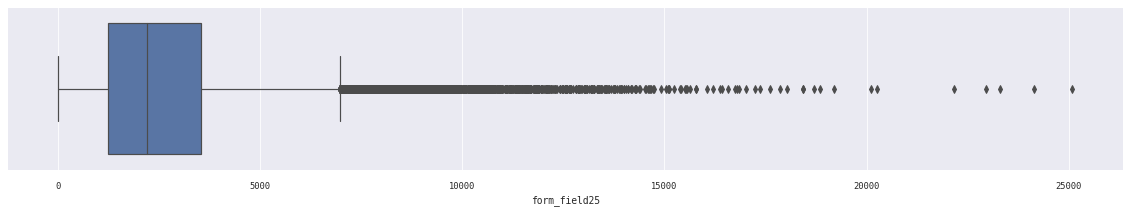

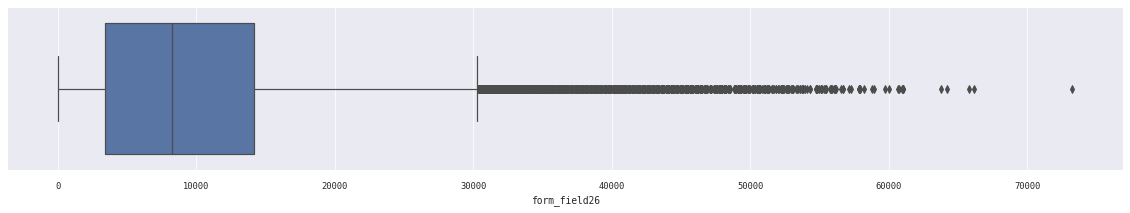

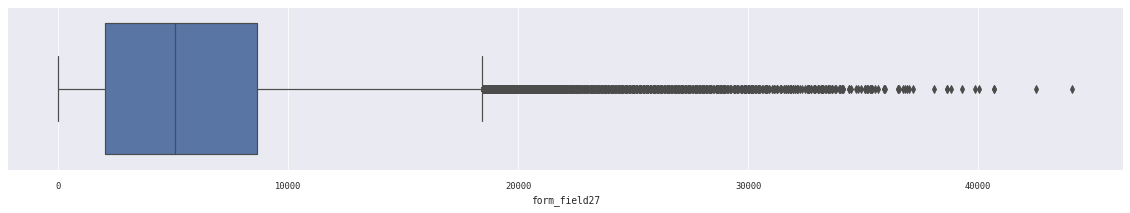

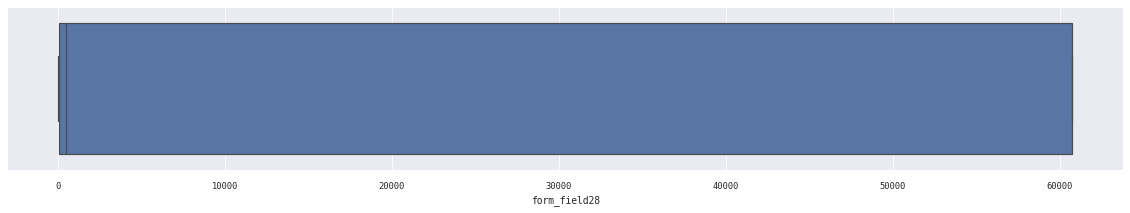

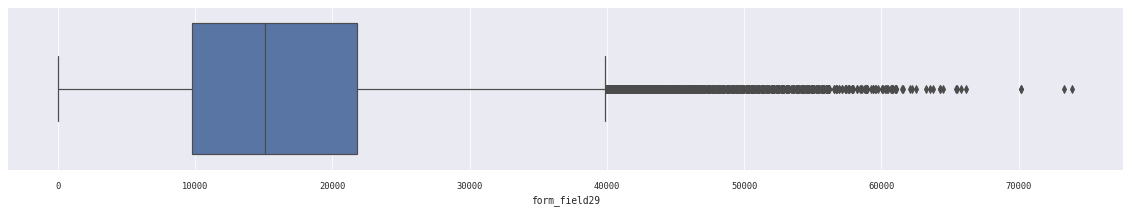

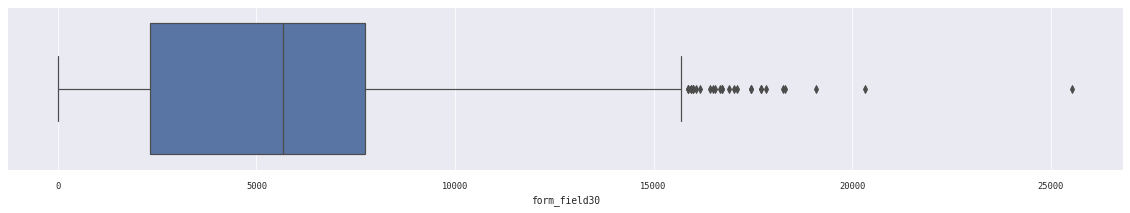

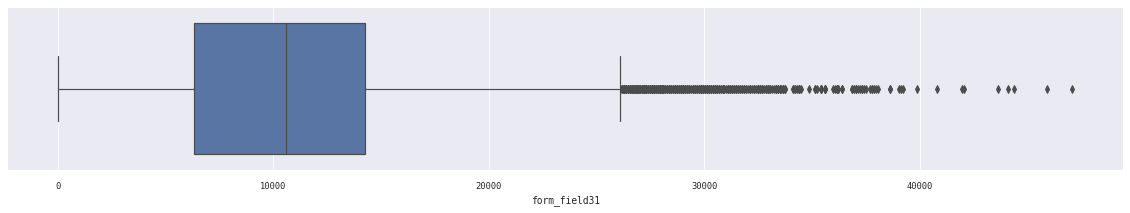

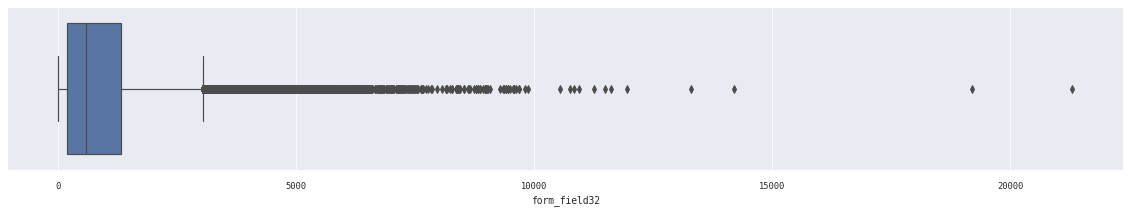

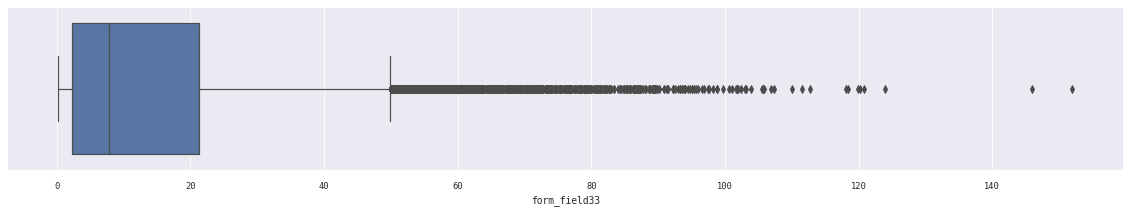

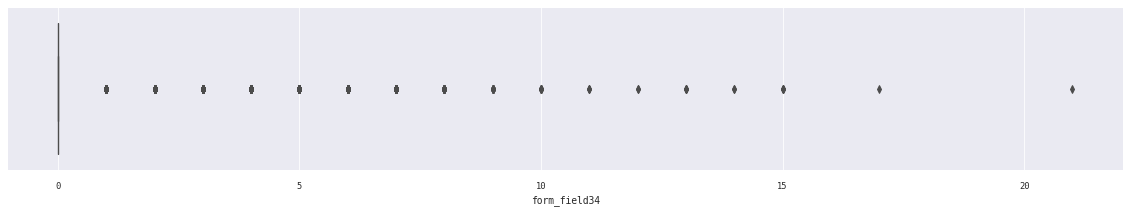

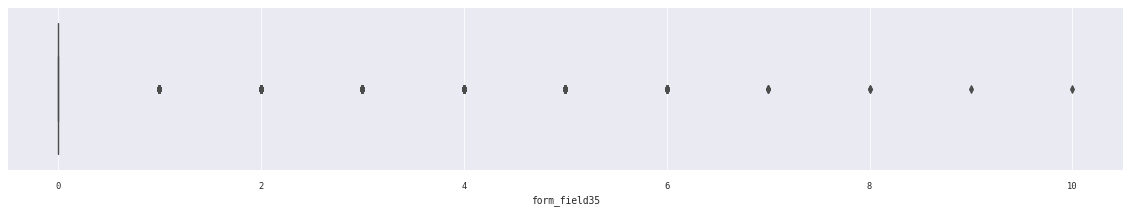

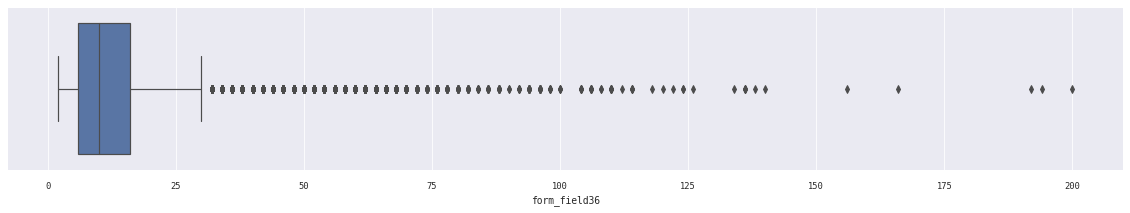

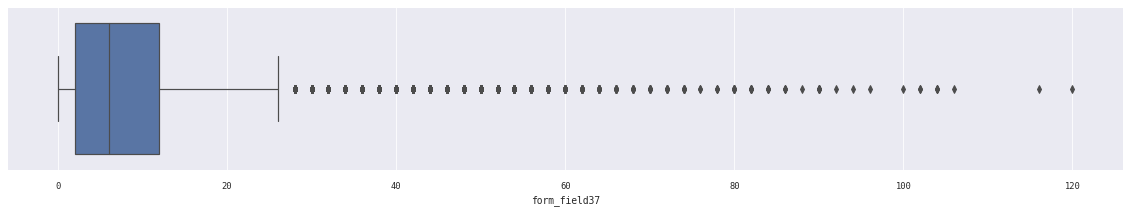

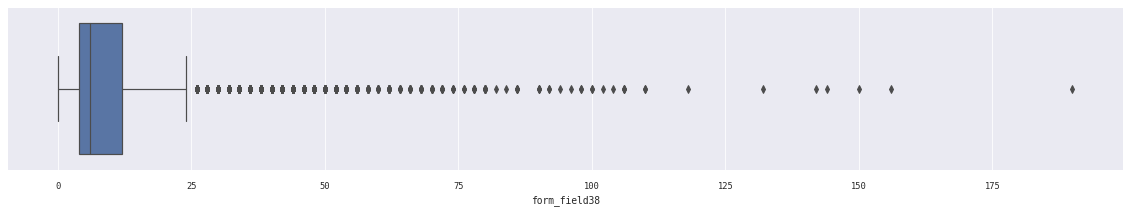

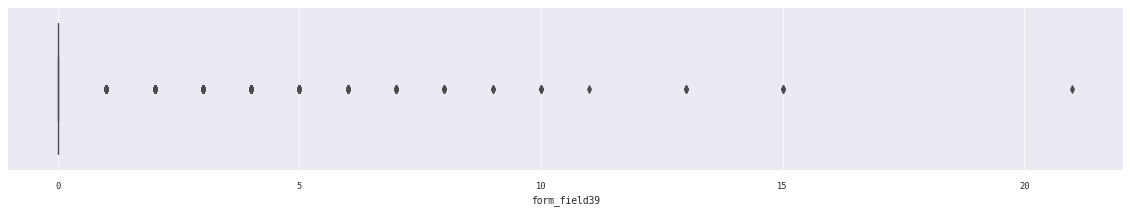

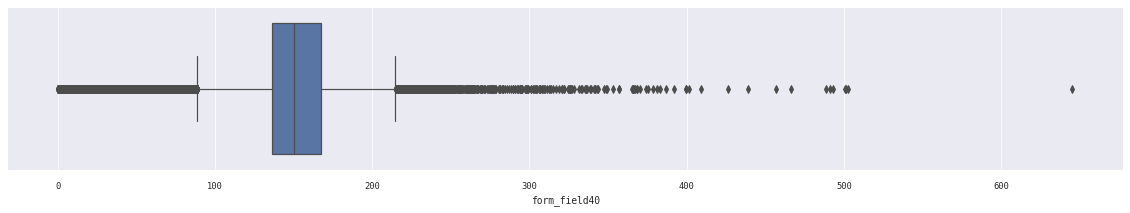

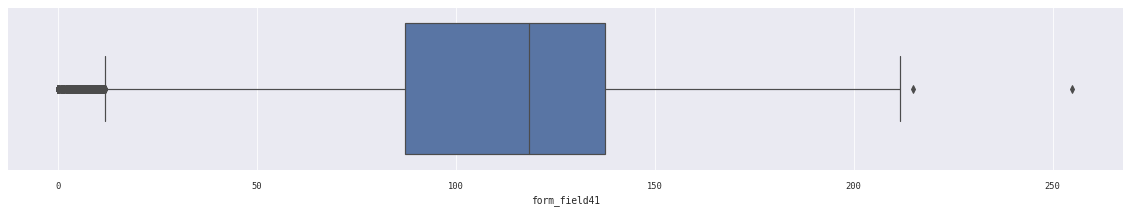

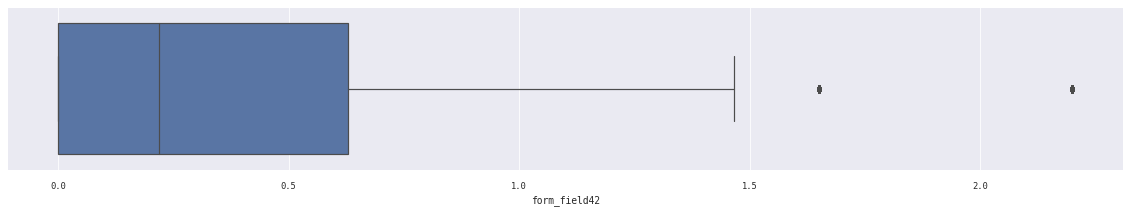

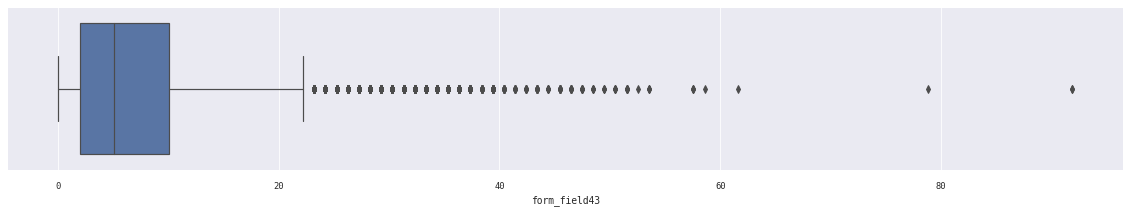

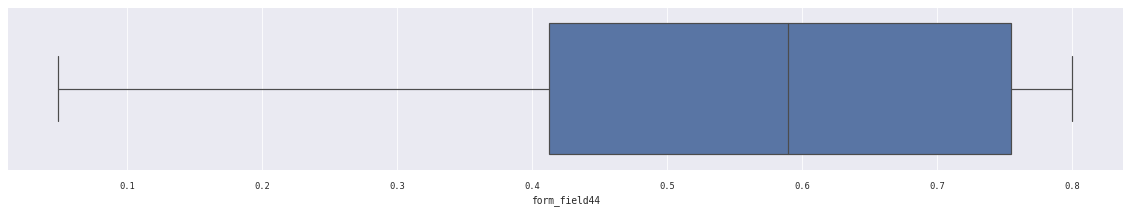

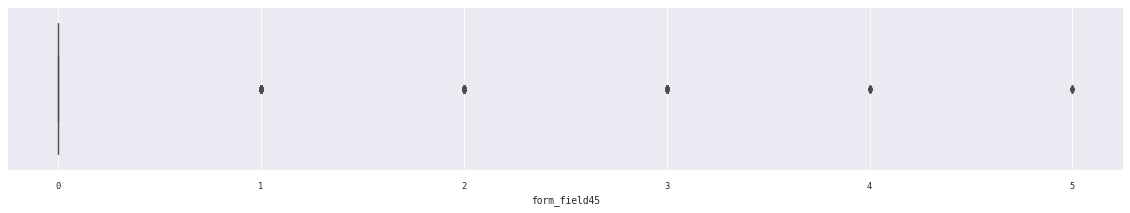

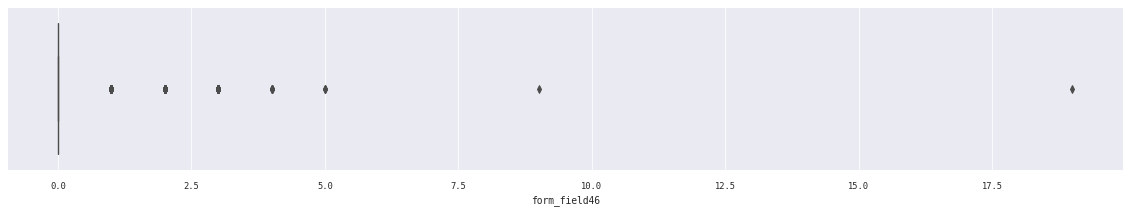

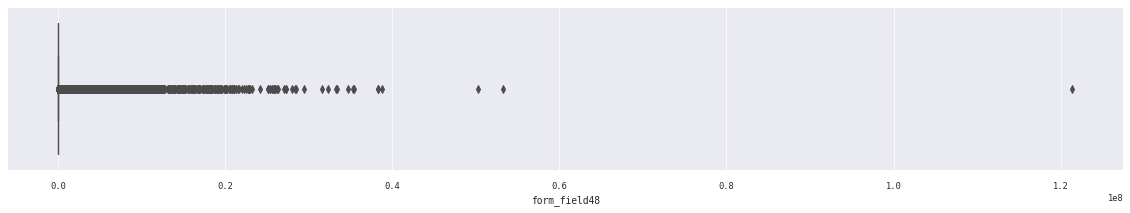

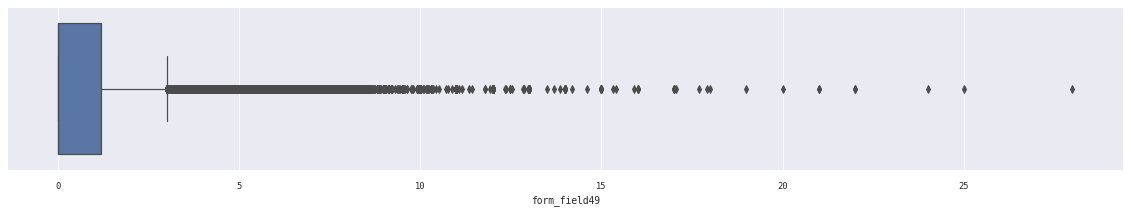

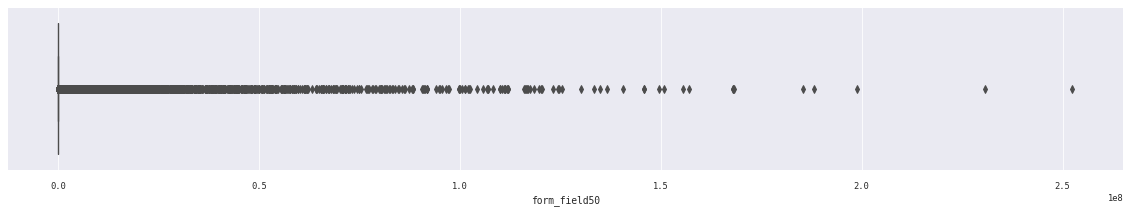

In [ ]:
# box plot for numerical features
for col in data[num_feat]:
    sns.boxplot(col, data=data)
    plt.xlabel(col) # Set text for the x axisa

    plt.show()

In [ ]:
# fill missing numeric values with -999
for col in num_feat:
    data[col].fillna(-999, inplace = True) 

In [ ]:
# form_field 48, 49 distribution plot looks 'strange'?
data.drop(['form_field48', 'form_field49'], axis=1, inplace=True)

In [ ]:
# some columns are float, but should be int
col_list = [1, *range(6,14), *range(15,21), *range(26,33), 
            *range(34,40), 45, 46]
cols = []
for l in col_list:
  col = 'form_field{}'.format(l)
  cols.append(col)
print(cols)

['form_field1', 'form_field6', 'form_field7', 'form_field8', 'form_field9', 'form_field10', 'form_field11', 'form_field12', 'form_field13', 'form_field15', 'form_field16', 'form_field17', 'form_field18', 'form_field19', 'form_field20', 'form_field26', 'form_field27', 'form_field28', 'form_field29', 'form_field30', 'form_field31', 'form_field32', 'form_field34', 'form_field35', 'form_field36', 'form_field37', 'form_field38', 'form_field39', 'form_field45', 'form_field46']


In [ ]:
for col in cols:
  data[col] = data[col].astype(np.int64)

In [ ]:
# split back to train and test set
train_df = data.loc[(data['default_status'] != 'test')].reset_index(drop = True)
test_df = data.loc[(data['default_status'] == 'test')].reset_index(drop = True)

In [ ]:
train_df.head()

,Applicant_ID,form_field1,form_field2,form_field3,form_field4,form_field5,form_field6,form_field7,form_field8,form_field9,form_field10,form_field11,form_field12,form_field13,form_field14,form_field15,form_field16,form_field17,form_field18,form_field19,form_field20,form_field21,form_field22,form_field23,form_field24,form_field25,form_field26,form_field27,form_field28,form_field29,form_field30,form_field31,form_field32,form_field33,form_field34,form_field35,form_field36,form_field37,form_field38,form_field39,form_field40,form_field41,form_field42,form_field43,form_field44,form_field45,form_field46,form_field50,default_status,form_field47_LE,form_field47_charge,form_field47_lending
0,Apcnt_1000000,3436,0.2851,1.6560,0.0000,0.0000,0,10689720,252072,4272776,11333126,4397256,2301324,7875694,96375139,112181765,1,1,1,3,3,134.6550,-999.0000,-999.0000,134.6550,"4,000.5000",17064,11376,60,17064,5962,-999,1052,8.0000,2,-999,12,12,4,0,-999.0000,-999.0000,0.3929,2.0200,0.7116,0,0,0.0443,no,0,1,0
1,Apcnt_1000004,3456,0.6740,0.2342,0.0000,0.0000,0,898979,497531,9073814,2533168,244292,3982971,2141445,28141427,45169902,1,1,1,2,2,109.2300,"11,385.2400","14,584.2900",86.6850,"4,161.0000",13413,8942,304,13413,5780,-999,2554,17.5000,0,0,16,24,8,0,-999.0000,-999.0000,0.3143,8.0800,0.1836,-999,0,0.3224,no,0,1,0
2,Apcnt_1000008,3276,0.5384,3.1510,0.0000,6.2820,-999,956940,-999,192944,1079864,-999,-999,0,16576457,22452691,-999,-999,-999,0,0,-999.0000,-999.0000,-999.0000,-999.0000,"1,597.5000",4746,3164,60,15696,-999,14508,70,0.6666,0,-999,12,0,6,0,149.6805,-999.0000,0.1630,18.1800,0.7911,0,0,0.0116,yes,0,1,0
3,Apcnt_1000012,3372,0.1701,0.5050,0.0000,0.0000,192166,3044703,385499,3986472,3621979,-999,771776,1186839,48187375,136297820,0,0,0,1,1,120.1200,"8,580.0000",0.0000,85.8000,"1,701.0000",4014,2676,60,11679,-999,-999,522,7.8334,1,1,4,8,4,1,-999.0000,-999.0000,0.4889,2.0200,0.6852,-999,0,0.0827,no,0,1,0
4,Apcnt_1000016,3370,0.7727,1.1010,0.0000,0.0000,1556,214728,214728,1284089,361770,396391,818456,511535,28141427,15292757,0,0,0,3,3,104.5350,"8,360.1900","10,326.4500",115.3350,"1,551.0000",3285,2190,60,19437,12958,5202,272,1.0000,0,0,24,2,24,0,150.0135,-999.0000,0.2750,12.1200,0.4382,0,0,0.0456,no,0,1,0


In [ ]:
# label encode
train_df['default_status'] = train_df['default_status'].factorize()[0]

In [ ]:
target = train_df.default_status
train_df.drop(['Applicant_ID','default_status'], axis=1, inplace=True)
test_df.drop(['Applicant_ID','default_status'], axis=1, inplace=True)

In [ ]:
print('Train shape: {}'.format(train_df.shape), '\n')
print('Test shape: {}'.format(test_df.shape), '\n')
print('Target shape: {}'.format(target.shape))

Train shape: (56000, 50) 

Test shape: (24000, 50) 

Target shape: (56000,)


## Models

### Model1: Catboost

================================Fold1====================================
0:	learn: 0.7919044	test: 0.7876067	best: 0.7876067 (0)	total: 21ms	remaining: 3m 29s
50:	learn: 0.8224812	test: 0.8108153	best: 0.8108153 (50)	total: 909ms	remaining: 2m 57s
100:	learn: 0.8271171	test: 0.8154033	best: 0.8154081 (99)	total: 1.7s	remaining: 2m 46s
150:	learn: 0.8305725	test: 0.8183433	best: 0.8183433 (150)	total: 2.51s	remaining: 2m 43s
200:	learn: 0.8332825	test: 0.8202628	best: 0.8202628 (200)	total: 3.35s	remaining: 2m 43s
250:	learn: 0.8351022	test: 0.8218701	best: 0.8218701 (250)	total: 4.09s	remaining: 2m 38s
300:	learn: 0.8364607	test: 0.8228068	best: 0.8228068 (300)	total: 4.84s	remaining: 2m 35s
350:	learn: 0.8376551	test: 0.8236477	best: 0.8236578 (349)	total: 5.58s	remaining: 2m 33s
400:	learn: 0.8386666	test: 0.8243474	best: 0.8243474 (400)	total: 6.29s	remaining: 2m 30s
450:	learn: 0.8395411	test: 0.8248954	best: 0.8248954 (450)	total: 7.06s	remaining: 2m 29s
500:	learn: 0.8403380	tes

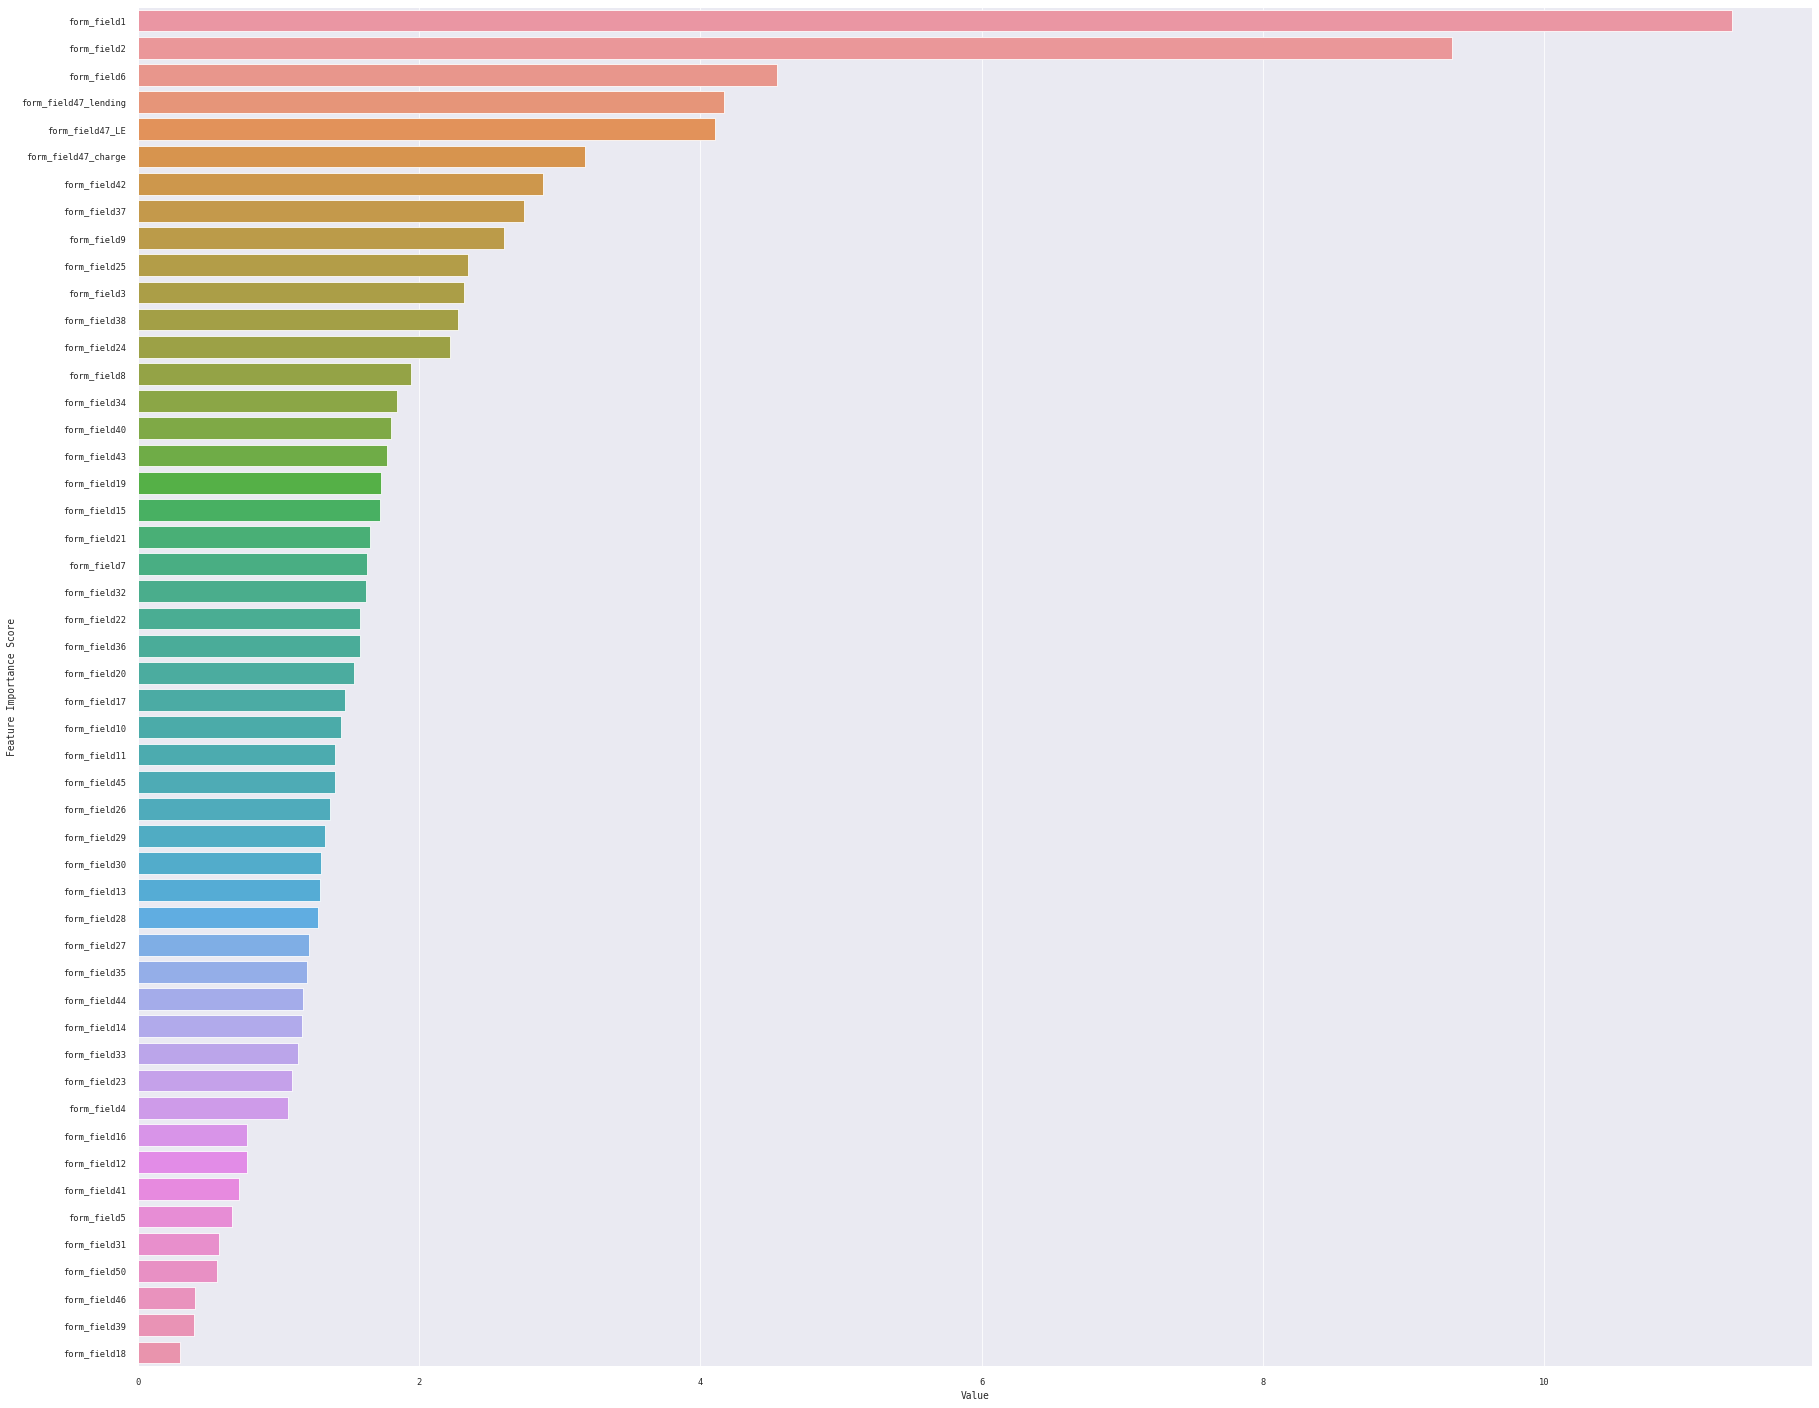

0.8418881334920215 0.8660718197121305


In [ ]:
catboost = cb.CatBoostClassifier(n_estimators=10000, 
                                   learning_rate=0.01,  
                                   max_depth=6,                                   
                                   eval_metric='AUC', 
                                   reg_lambda = 370, 
                                   task_type="GPU", 
                                   devices='0:1')

func_= func(train_df, target, test_df, catboost, 'catboost', 1000)
val_p1, test_p1, model1 = func_()

In [ ]:
# save output values and model parameters
np.savez(path+'models/cb_1', val=val_p1, test=test_p1)

pickle.dump(model1, open(path+'models/cb_1.sav', 'wb'))

### Model2: Catboost with optuna 

In [ ]:
def objective(trial):
    kf = StratifiedKFold(10)
    
    for train_index, valid_index in kf.split(train_df, target):
        train_x, valid_x = train_df.iloc[train_index], train_df.iloc[valid_index]
        train_y, valid_y = target.iloc[train_index], target.iloc[valid_index]

    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "n_estimators": trial.suggest_int("n_estimators", 4000, 10000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 6, 10),
        "reg_lambda": trial.suggest_int("reg_lambda", 200, 500),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    gbm = cb.CatBoostClassifier(**param)

    gbm.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], verbose=0, early_stopping_rounds=300)

    preds = gbm.predict(valid_x)
    accuracy = roc_auc_score(valid_y, preds)
    return accuracy


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100, timeout=600)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2020-09-29 00:04:25,511] A new study created in memory with name: no-name-f2d79c42-f0e5-4c5f-93d9-9635ec7cd398
[I 2020-09-29 00:05:36,951] Trial 0 finished with value: 0.6916040777711274 and parameters: {'objective': 'CrossEntropy', 'n_estimators': 4775, 'learning_rate': 0.030573314507558305, 'depth': 6, 'reg_lambda': 406, 'bootstrap_type': 'Bernoulli', 'subsample': 0.5737740181358426}. Best is trial 0 with value: 0.6916040777711274.
[I 2020-09-29 00:09:37,475] Trial 1 finished with value: 0.6912589539126909 and parameters: {'objective': 'Logloss', 'n_estimators': 7331, 'learning_rate': 0.021850180737253956, 'depth': 8, 'reg_lambda': 242, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 4.693384116433325}. Best is trial 0 with value: 0.6916040777711274.
[I 2020-09-29 00:10:37,455] Trial 2 finished with value: 0.6958686502036955 and parameters: {'objective': 'CrossEntropy', 'n_estimators': 9071, 'learning_rate': 0.06737446984501388, 'depth': 6, 'reg_lambda': 411, 'bootstrap_type'

Number of finished trials: 5
Best trial:
  Value: 0.6958686502036955
  Params: 
    objective: CrossEntropy
    n_estimators: 9071
    learning_rate: 0.06737446984501388
    depth: 6
    reg_lambda: 411
    bootstrap_type: Bayesian
    bagging_temperature: 1.5578358798391723


================================Fold1====================================
0:	learn: 0.7996044	test: 0.7873870	best: 0.7873870 (0)	total: 20.6ms	remaining: 3m 6s
50:	learn: 0.8366547	test: 0.8219049	best: 0.8219049 (50)	total: 922ms	remaining: 2m 43s
100:	learn: 0.8415263	test: 0.8258570	best: 0.8259004 (99)	total: 1.73s	remaining: 2m 34s
150:	learn: 0.8447117	test: 0.8277358	best: 0.8277580 (149)	total: 2.55s	remaining: 2m 30s
200:	learn: 0.8471932	test: 0.8285319	best: 0.8285319 (200)	total: 3.36s	remaining: 2m 28s
250:	learn: 0.8495505	test: 0.8293334	best: 0.8293613 (248)	total: 4.14s	remaining: 2m 25s
300:	learn: 0.8514372	test: 0.8299481	best: 0.8299933 (299)	total: 4.93s	remaining: 2m 23s
350:	learn: 0.8530045	test: 0.8302184	best: 0.8303139 (335)	total: 5.7s	remaining: 2m 21s
400:	learn: 0.8546618	test: 0.8307391	best: 0.8307391 (400)	total: 6.46s	remaining: 2m 19s
450:	learn: 0.8563665	test: 0.8309389	best: 0.8309964 (432)	total: 7.24s	remaining: 2m 18s
500:	learn: 0.8579323	te

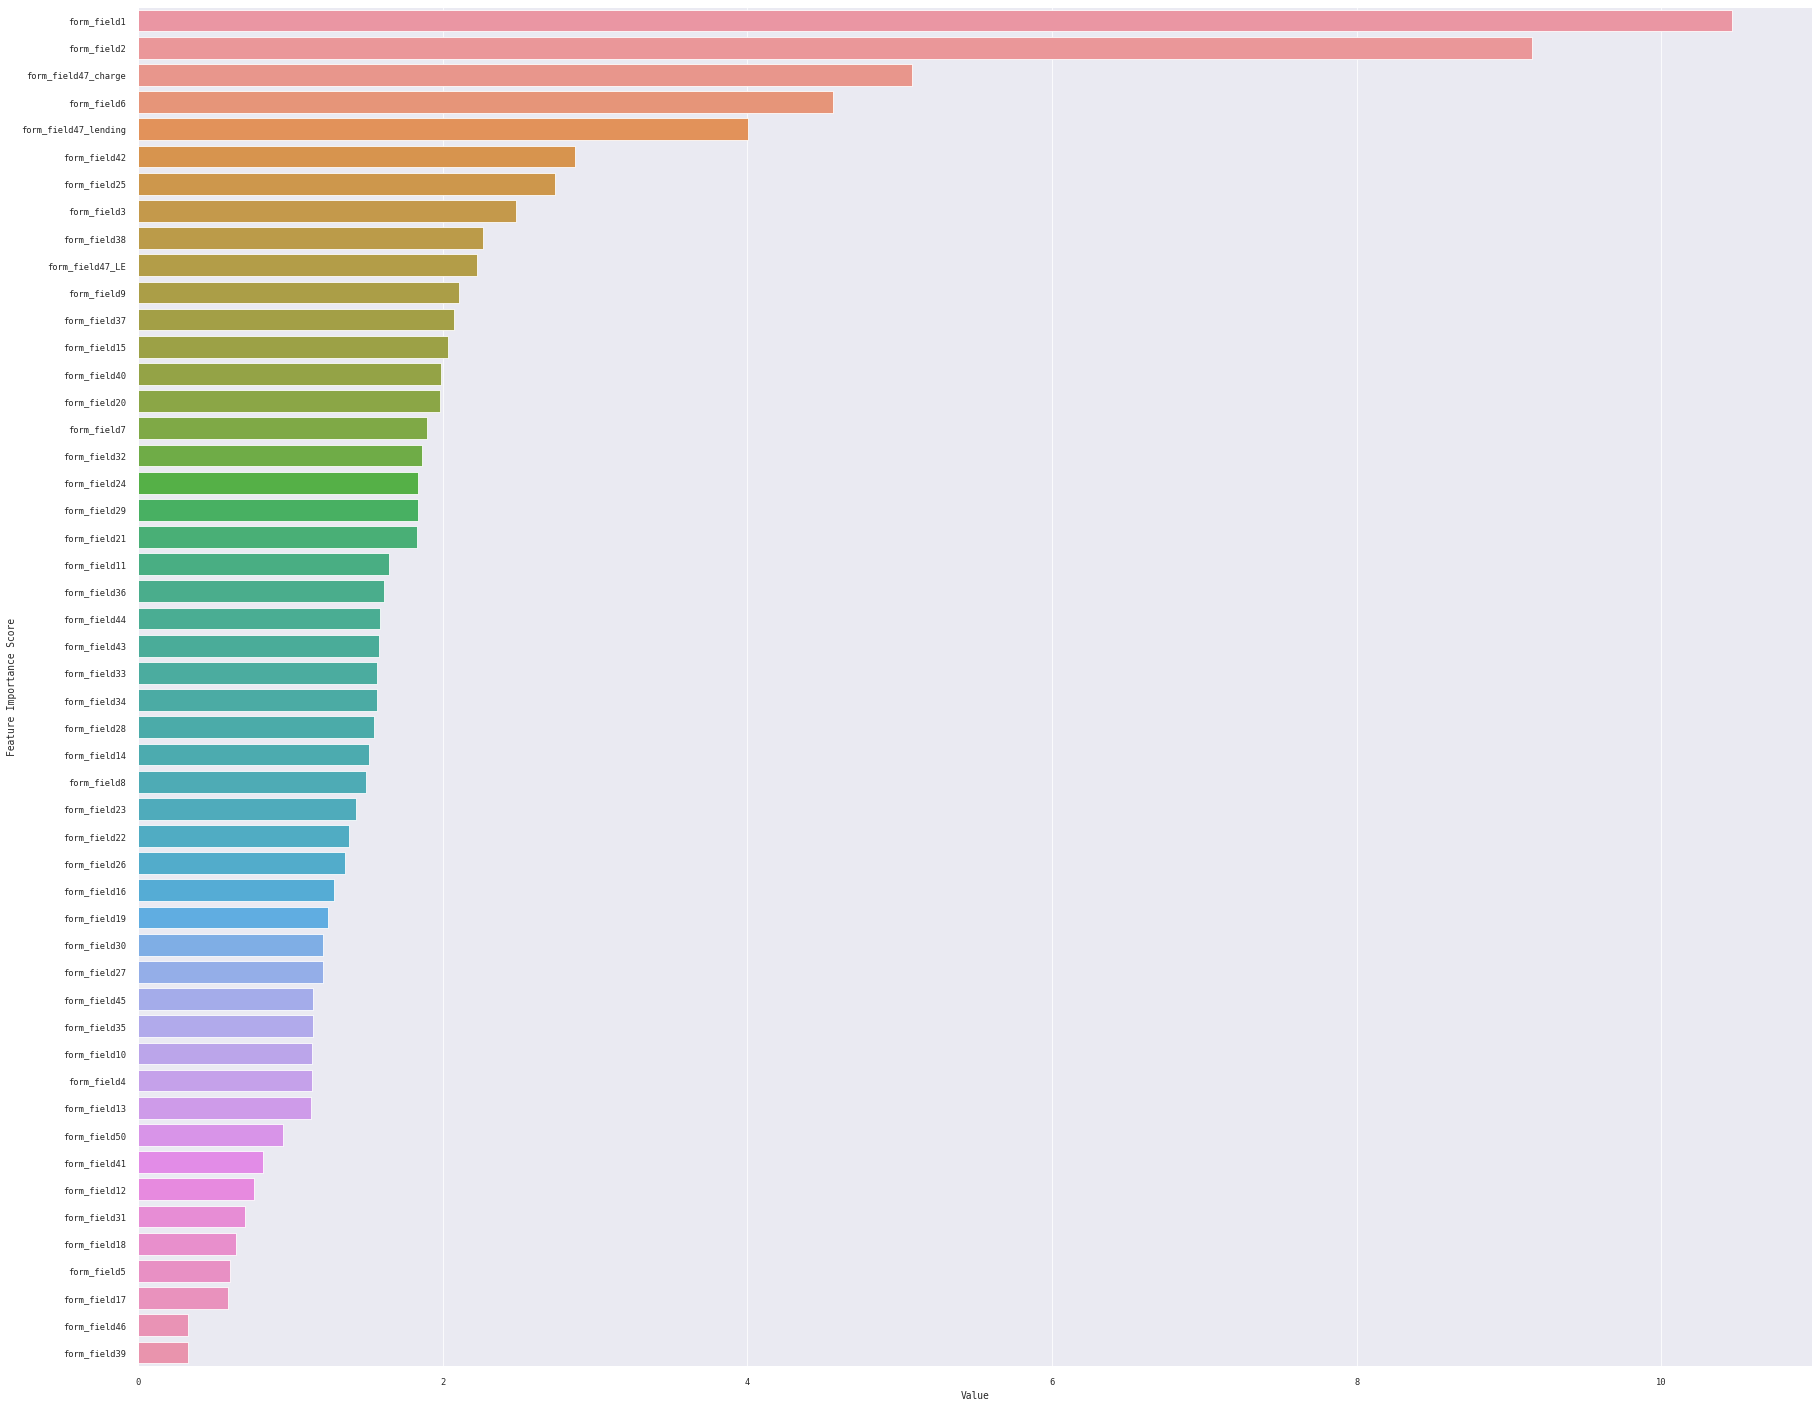

0.8414238570412899 0.8703282160667987


In [ ]:
catboost = cb.CatBoostClassifier(n_estimators=9071, 
                                   learning_rate=0.06737446984501388, 
                                   objective='CrossEntropy', 
                                   depth=6,                                   
                                   bootstrap_type='Bayesian',
                                   eval_metric='AUC',
                                   bagging_temperature= 1.5578358798391723,
                                   reg_lambda = 411, 
                                   task_type="GPU", 
                                   devices='0:1')

func_= func(train_df, target, test_df, catboost, 'catboost', 1000)
val_p2, test_p2, model2 = func_()

In [ ]:
np.savez(path+'models/cb_2', val=val_p2, test=test_p2)

pickle.dump(model2, open(path+'models/cb_2.sav', 'wb'))

### Model3: XGboost 

================================Fold1====================================
[0]	validation_0-auc:0.757789
Will train until validation_0-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.77424
[2]	validation_0-auc:0.780529
[3]	validation_0-auc:0.78367
[4]	validation_0-auc:0.785091
[5]	validation_0-auc:0.790118
[6]	validation_0-auc:0.79314
[7]	validation_0-auc:0.795231
[8]	validation_0-auc:0.79605
[9]	validation_0-auc:0.798307
[10]	validation_0-auc:0.800955
[11]	validation_0-auc:0.802958
[12]	validation_0-auc:0.804689
[13]	validation_0-auc:0.804688
[14]	validation_0-auc:0.805926
[15]	validation_0-auc:0.807863
[16]	validation_0-auc:0.809947
[17]	validation_0-auc:0.81045
[18]	validation_0-auc:0.811749
[19]	validation_0-auc:0.812901
[20]	validation_0-auc:0.813658
[21]	validation_0-auc:0.814137
[22]	validation_0-auc:0.814761
[23]	validation_0-auc:0.815256
[24]	validation_0-auc:0.815673
[25]	validation_0-auc:0.815959
[26]	validation_0-auc:0.81656
[27]	validation_0-auc:0.817408
[28]	valid

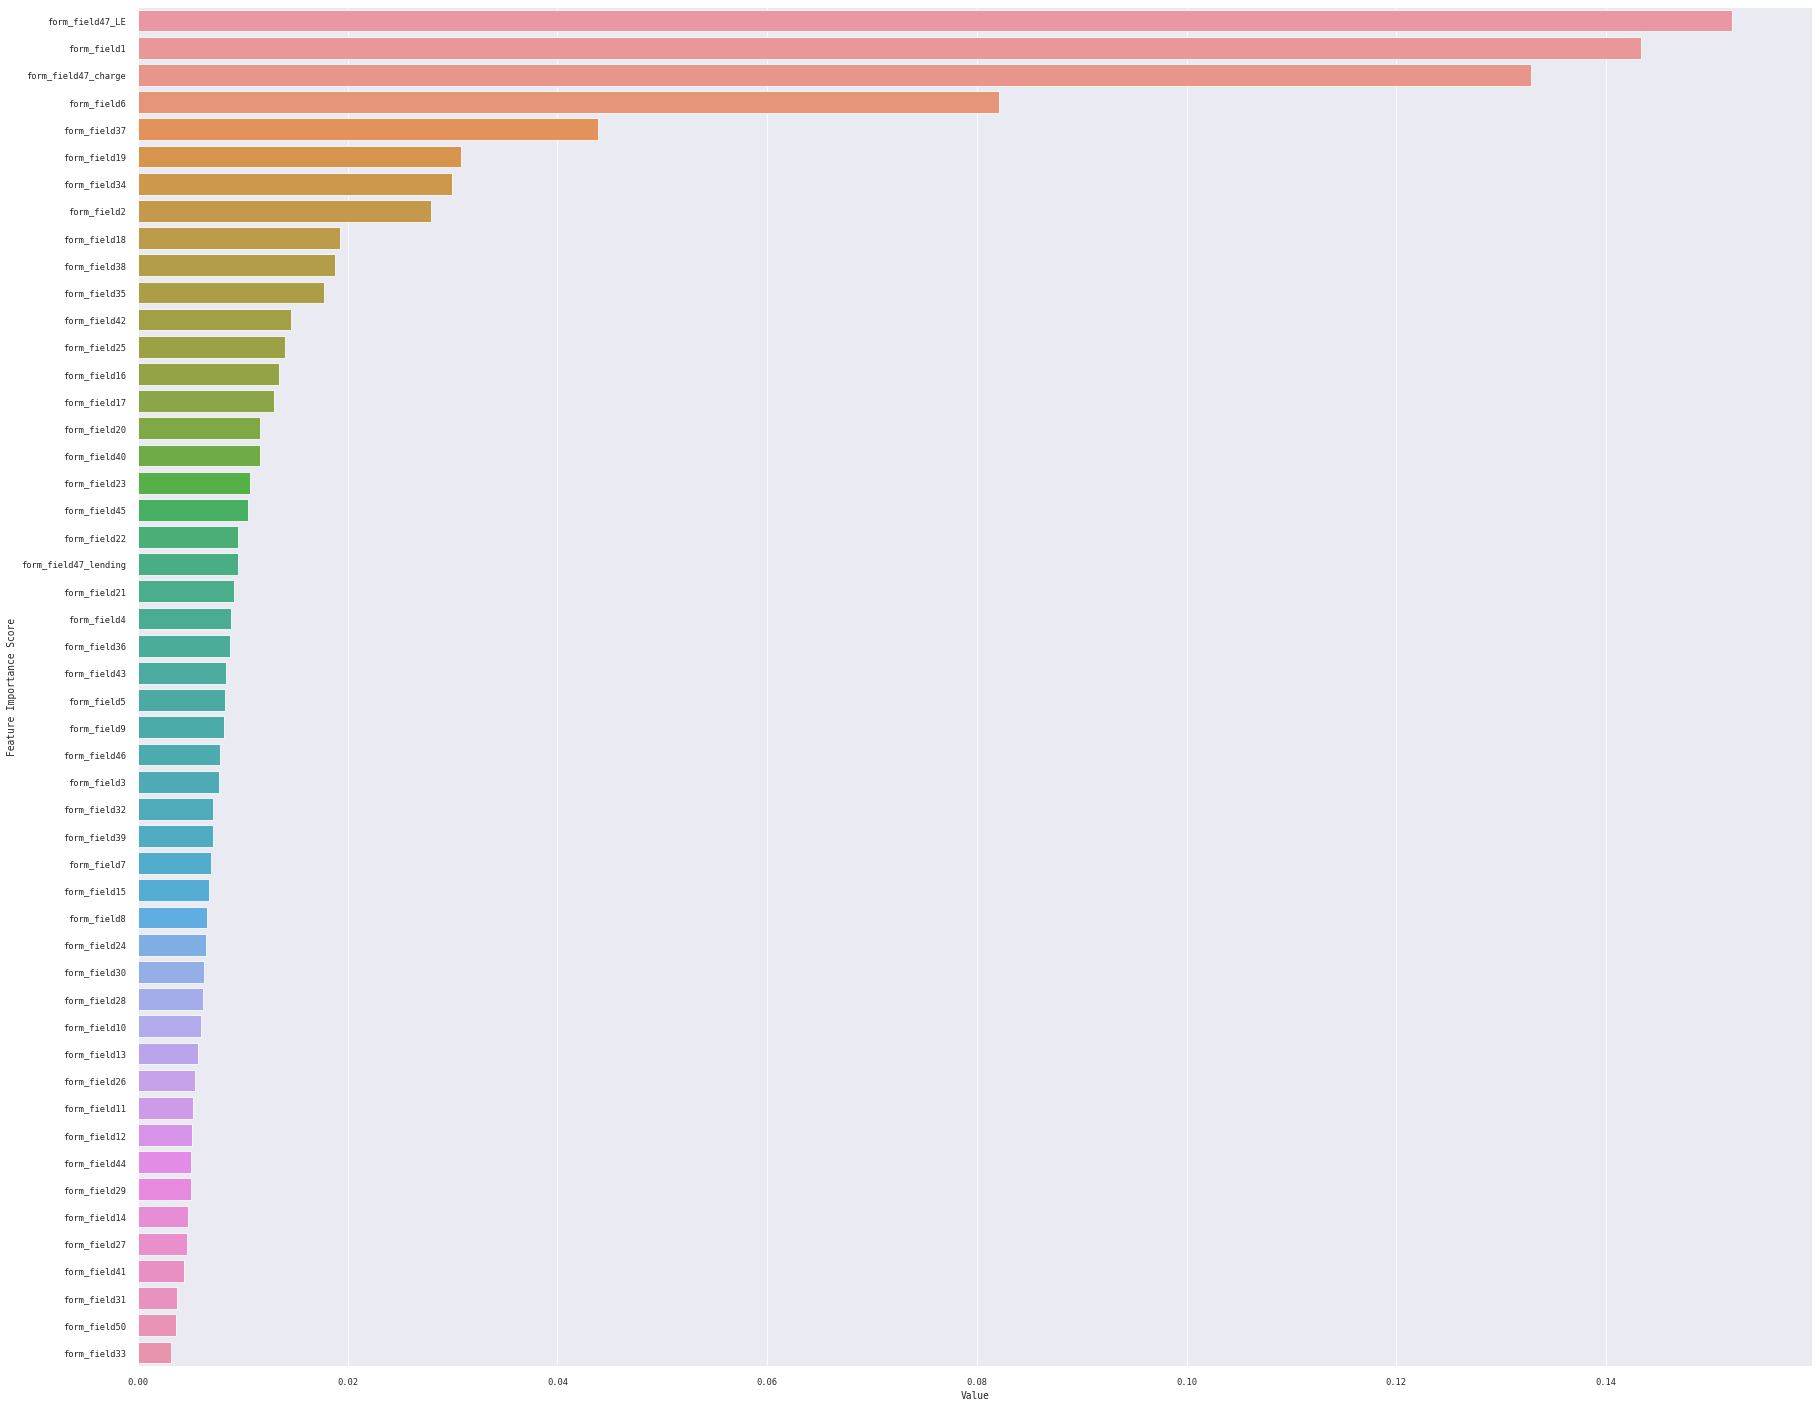

0.8396741077873859 0.8726734029037864


In [ ]:
xgboost = xgb.XGBClassifier(objective ='binary:logistic', 
                          eta = 0.99,
                          max_depth = 6, 
                          n_estimators = 5000,
                          reg_lambda = 500,
                          sub_sample = 0.8,
                          colsample_bytree = 0.8, 
                          tree_method='gpu_hist', 
                          gpu_id=0)

func_= func(train_df, target, test_df, xgboost, 'xgboost', 1000)
val_p3, test_p3, model3 = func_()

In [ ]:
np.savez(path+'models/xgb_1', val=val_p3, test=test_p3)

pickle.dump(model3, open(path+'models/xgb_1.sav', 'wb'))

### Model4: XGboost with optuna 

In [ ]:
def objective(trial):
    kf = StratifiedKFold(10)
    
    for train_index, valid_index in kf.split(train_df, target):
        train_x, val_x = train_df.iloc[train_index], train_df.iloc[valid_index]
        train_y, val_y = target.iloc[train_index], target.iloc[valid_index]
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dvalid = xgb.DMatrix(val_x, label=val_y)

    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        "n_estimators": trial.suggest_int("n_estimators", 1000, 5000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
    }

    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 9)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    bst = xgb.train(param, dtrain)
    preds = bst.predict(dvalid)
    accuracy = roc_auc_score(val_y, preds)
    return accuracy


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100, timeout=600)

    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2020-09-29 01:05:31,044] A new study created in memory with name: no-name-29809f03-910e-4b39-9495-235920d29fe8
[I 2020-09-29 01:05:32,144] Trial 0 finished with value: 0.8110164156215263 and parameters: {'n_estimators': 1744, 'learning_rate': 0.04211497028418693, 'booster': 'gbtree', 'lambda': 0.0015056624959207713, 'alpha': 1.1280432752636515e-08, 'max_depth': 3, 'eta': 2.0809691375930376e-05, 'gamma': 5.065961001273235e-07, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.8110164156215263.
[I 2020-09-29 01:05:34,991] Trial 1 finished with value: 0.8243668649376226 and parameters: {'n_estimators': 4775, 'learning_rate': 0.02658168249508474, 'booster': 'gbtree', 'lambda': 0.21804822558175013, 'alpha': 0.00196503525386592, 'max_depth': 8, 'eta': 1.8725080101381208e-08, 'gamma': 0.0002317215130231689, 'grow_policy': 'lossguide'}. Best is trial 1 with value: 0.8243668649376226.
[I 2020-09-29 01:05:35,493] Trial 2 finished with value: 0.7984590443827213 and parameters: {'n_est

Number of finished trials:  100
Best trial:
  Value: 0.8335843612346954
  Params: 
    n_estimators: 3373
    learning_rate: 0.09696768094722441
    booster: gbtree
    lambda: 5.490866238856754e-07
    alpha: 0.005029839069237921
    max_depth: 7
    eta: 0.0004492612175074401
    gamma: 0.0027634699693706013
    grow_policy: depthwise


================================Fold1====================================
[0]	validation_0-auc:0.797642
Will train until validation_0-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.805581
[2]	validation_0-auc:0.807749
[3]	validation_0-auc:0.808105
[4]	validation_0-auc:0.810167
[5]	validation_0-auc:0.811769
[6]	validation_0-auc:0.813253
[7]	validation_0-auc:0.814605
[8]	validation_0-auc:0.816414
[9]	validation_0-auc:0.817253
[10]	validation_0-auc:0.817729
[11]	validation_0-auc:0.818152
[12]	validation_0-auc:0.818893
[13]	validation_0-auc:0.819574
[14]	validation_0-auc:0.819562
[15]	validation_0-auc:0.820063
[16]	validation_0-auc:0.82051
[17]	validation_0-auc:0.821694
[18]	validation_0-auc:0.82184
[19]	validation_0-auc:0.82203
[20]	validation_0-auc:0.8221
[21]	validation_0-auc:0.822405
[22]	validation_0-auc:0.822763
[23]	validation_0-auc:0.822798
[24]	validation_0-auc:0.823072
[25]	validation_0-auc:0.823052
[26]	validation_0-auc:0.823415
[27]	validation_0-auc:0.823513
[28]	vali

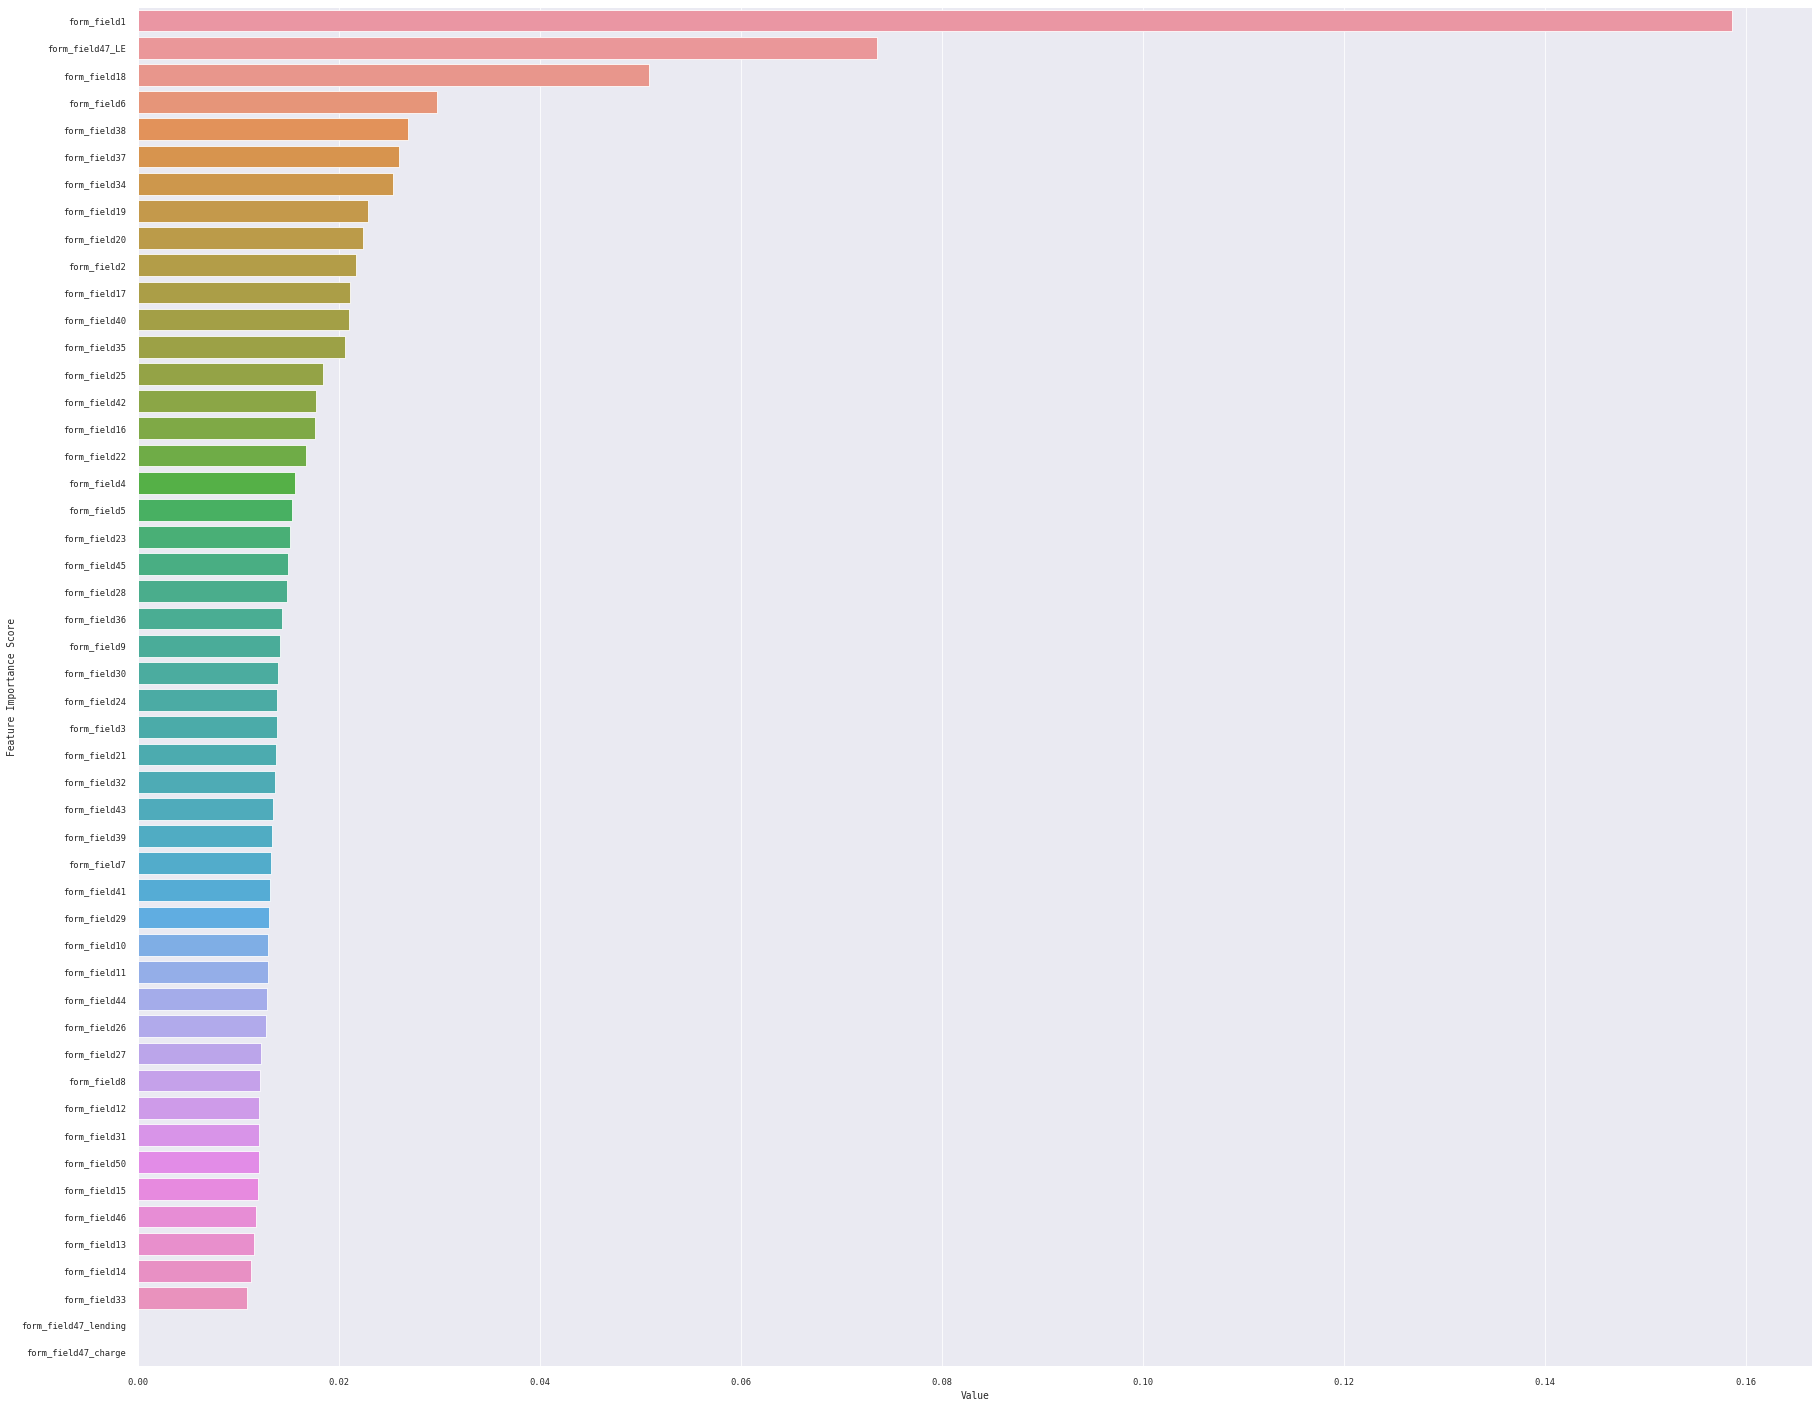

0.8368452993757666 0.9141545650318111


In [ ]:
xgboost = xgb.XGBClassifier(objective ='binary:logistic', 
                          n_estimators = 3373,
                          learning_rate = 0.09696768094722441,
                          booster = 'gbtree',
                          eta = 0.0004492612175074401,
                          max_depth = 7, 
                          reg_lambda = 5.490866238856754e-07,
                          alpha = 0.005029839069237921,
                          gamma = 0.0027634699693706013,
                          grow_policy = 'depthwise',
                          tree_method='gpu_hist', 
                          gpu_id=0)

func_= func(train_df, target, test_df, xgboost, 'xgboost', 1000)
val_p4, test_p4, model4 = func_()

In [ ]:
np.savez(path+'models/xgb_2', val=val_p4, test=test_p4)

pickle.dump(model4, open(path+'models/xgb_2.sav', 'wb'))

### Model5: LightGBM 

================================Fold1====================================
[1]	valid_0's auc: 0.790203
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's auc: 0.794333
[3]	valid_0's auc: 0.797634
[4]	valid_0's auc: 0.802058
[5]	valid_0's auc: 0.804695
[6]	valid_0's auc: 0.806982
[7]	valid_0's auc: 0.808215
[8]	valid_0's auc: 0.810594
[9]	valid_0's auc: 0.812734
[10]	valid_0's auc: 0.813872
[11]	valid_0's auc: 0.814938
[12]	valid_0's auc: 0.815694
[13]	valid_0's auc: 0.816545
[14]	valid_0's auc: 0.817438
[15]	valid_0's auc: 0.818439
[16]	valid_0's auc: 0.818823
[17]	valid_0's auc: 0.819443
[18]	valid_0's auc: 0.819925
[19]	valid_0's auc: 0.820504
[20]	valid_0's auc: 0.821001
[21]	valid_0's auc: 0.8217
[22]	valid_0's auc: 0.821799
[23]	valid_0's auc: 0.822084
[24]	valid_0's auc: 0.82241
[25]	valid_0's auc: 0.822693
[26]	valid_0's auc: 0.822935
[27]	valid_0's auc: 0.823097
[28]	valid_0's auc: 0.82328
[29]	valid_0's auc: 0.823596
[30]	valid_0's auc: 0.823675
[31]	va

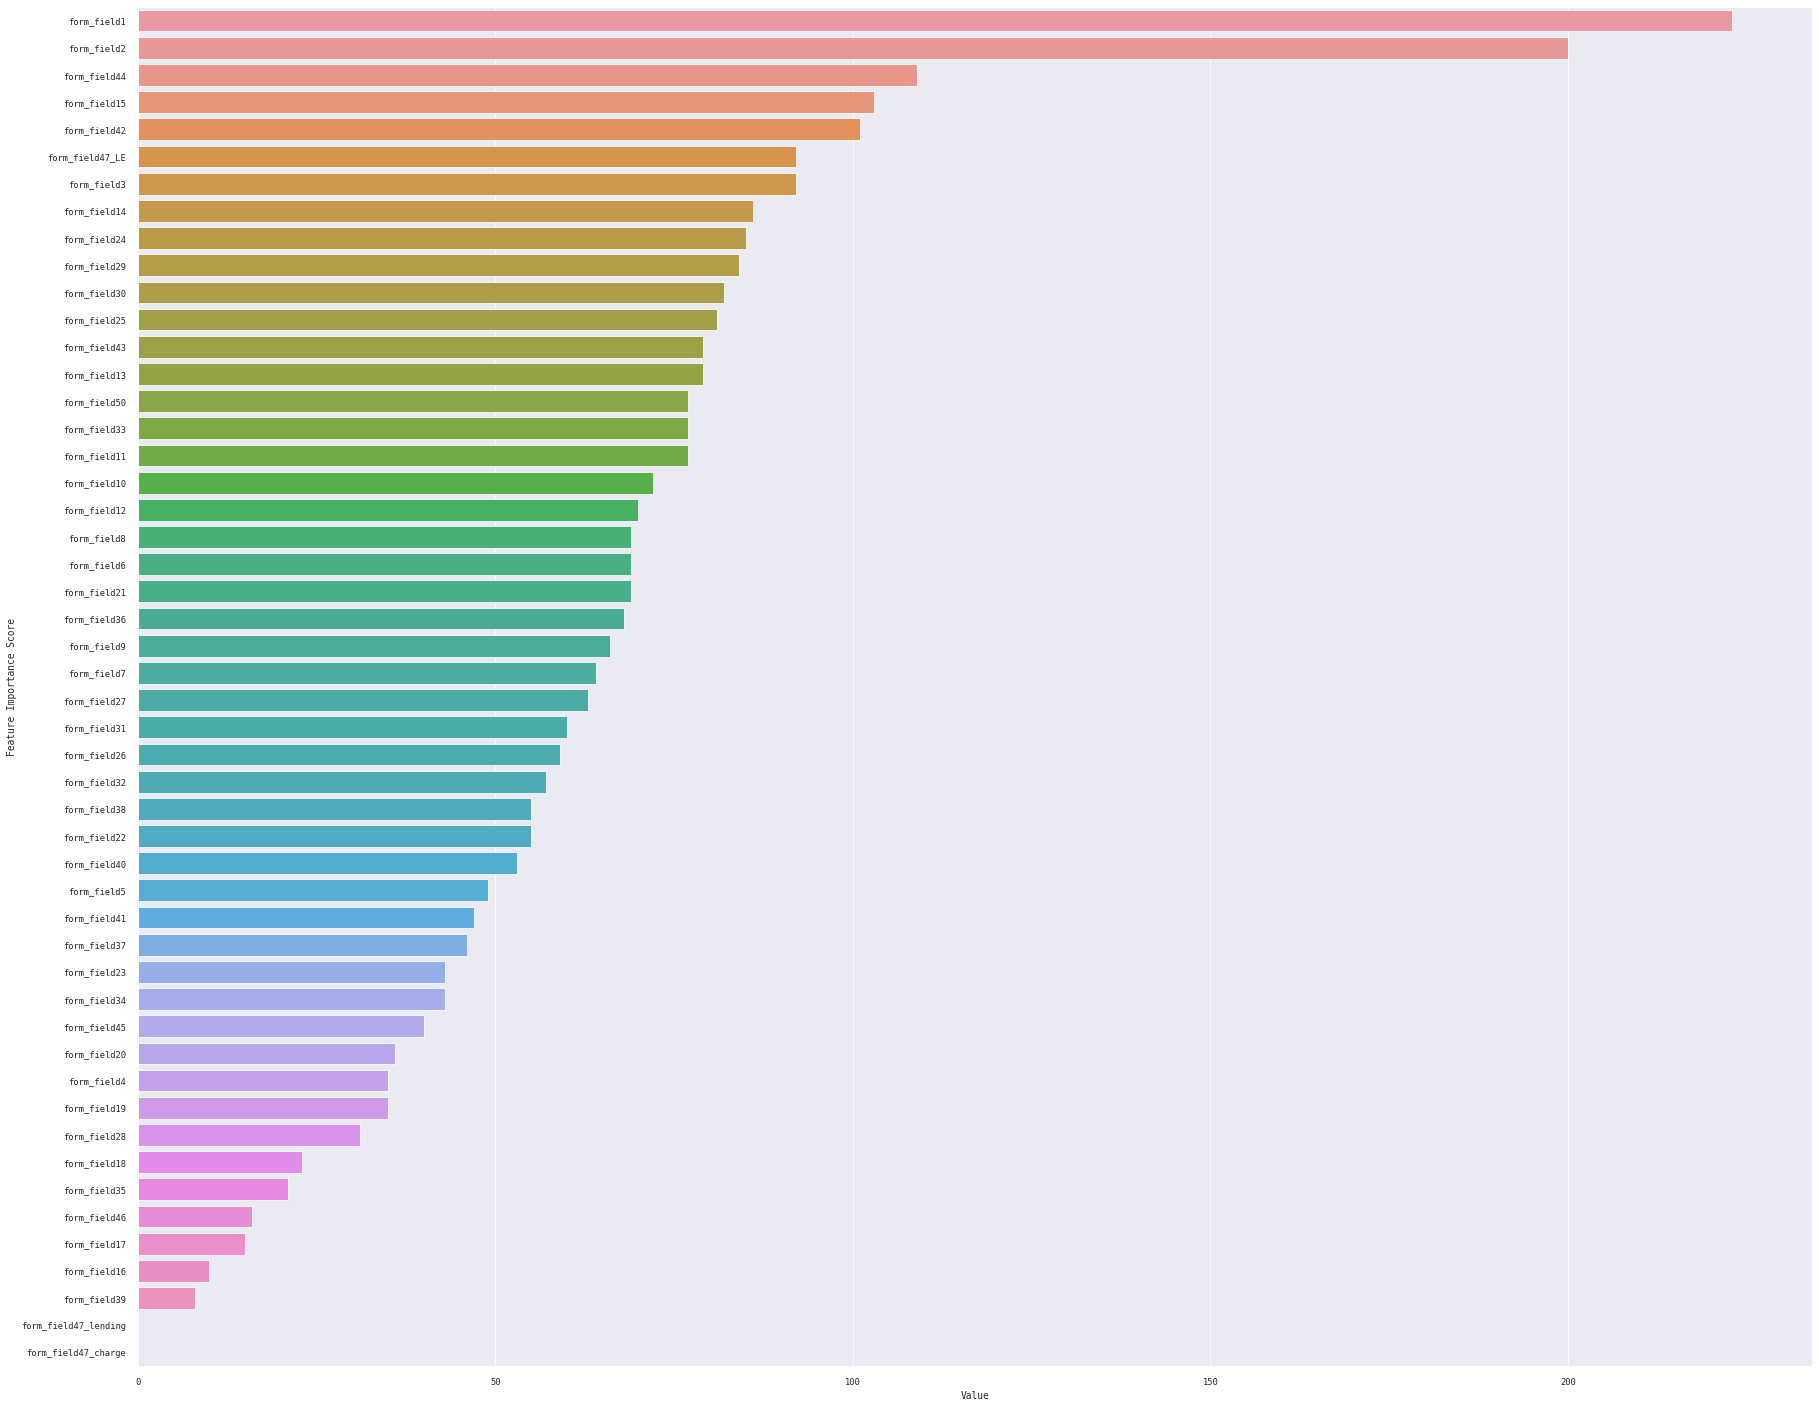

0.8394777936864543 0.8723358696231622


In [ ]:
lgb_model = lgb.LGBMClassifier(objective = 'binary', 
                            metric= 'auc',
                            boosting_type= 'gbdt',
                            lambda_l1= 0.0004912993970392775,
                            lambda_l2= 9.424350138808432,
                            num_leaves= 24,
                            feature_fraction= 1.0,
                            bagging_fraction= 0.9540416539312312,
                            bagging_freq= 7,
                            min_child_samples= 100, 
                            n_estimators = 300)

func_= func(train_df, target, test_df, lgb_model, 'lgbm', 1000)
val_p5, test_p5, model5 = func_()

In [ ]:
np.savez(path+'models/lgb_1', val=val_p5, test=test_p5)

pickle.dump(model5, open(path+'models/lgb_1.sav', 'wb'))

### Model6: LightGBM with optuna 

In [ ]:
import optuna.integration.lightgbm as lgb_

if __name__ == "__main__":
    kf = StratifiedKFold(10)
    
    for train_index, valid_index in kf.split(train_df, target):
        train_x, val_x = train_df.iloc[train_index], train_df.iloc[valid_index]
        train_y, val_y = target.iloc[train_index], target.iloc[valid_index]

    dtrain = lgb.Dataset(train_x, label=train_y)
    dval = lgb.Dataset(val_x, label=val_y)
    # print(dtrain)
    params = {
        "objective": "binary",
        "metric": "auc",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "n_estimators": 2000,
        "learning_rate": 0.008
    }

    model = lgb_.train(
        params, dtrain, valid_sets=[dtrain, dval], verbose_eval=100, early_stopping_rounds=100
    )

    prediction = model.predict(val_x, num_iteration=model.best_iteration)
    accuracy = roc_auc_score(val_y, prediction)

best_params = model.params
print("Best params:", best_params)
print("  Accuracy = {}".format(accuracy))
print("  Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

[I 2020-09-29 01:22:34,105] A new study created in memory with name: no-name-f8bd9347-17a4-4f0a-9b46-bc0335a19e74
feature_fraction, val_score: -inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.836787	valid_1's auc: 0.834809
[200]	training's auc: 0.842764	valid_1's auc: 0.837684
[300]	training's auc: 0.847757	valid_1's auc: 0.839866
[400]	training's auc: 0.85215	valid_1's auc: 0.841702
[500]	training's auc: 0.856357	valid_1's auc: 0.84308
[600]	training's auc: 0.860445	valid_1's auc: 0.843962
[700]	training's auc: 0.864434	valid_1's auc: 0.844929
[800]	training's auc: 0.868128	valid_1's auc: 0.845496
[900]	training's auc: 0.87158	valid_1's auc: 0.845829
[1000]	training's auc: 0.874817	valid_1's auc: 0.846177
[1100]	training's auc: 0.877907	valid_1's auc: 0.84618
Early stopping, best iteration is:
[1064]	training's auc: 0.876818	valid_1's auc: 0.84623


feature_fraction, val_score: 0.846230:  14%|#4        | 1/7 [00:23<02:19, 23.32s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.83821	valid_1's auc: 0.837048
[200]	training's auc: 0.843275	valid_1's auc: 0.839496
[300]	training's auc: 0.847412	valid_1's auc: 0.840975
[400]	training's auc: 0.851313	valid_1's auc: 0.842309
[500]	training's auc: 0.855181	valid_1's auc: 0.843203
[600]	training's auc: 0.859031	valid_1's auc: 0.844089
[700]	training's auc: 0.862707	valid_1's auc: 0.844623
[800]	training's auc: 0.866357	valid_1's auc: 0.845271
[900]	training's auc: 0.86973	valid_1's auc: 0.845704
[1000]	training's auc: 0.872943	valid_1's auc: 0.845854
[1100]	training's auc: 0.875937	valid_1's auc: 0.84609
[1200]	training's auc: 0.878824	valid_1's auc: 0.846356
[1300]	training's auc: 0.881629	valid_1's auc: 0.846491
[1400]	training's auc: 0.884356	valid_1's auc: 0.846564
[1500]	training's auc: 0.886959	valid_1's auc: 0.84675
[1600]	training's auc: 0.889586	valid_1's auc: 0.846979
[1700]	training's auc: 0.892019	valid_1's auc: 0.84700

feature_fraction, val_score: 0.847365:  29%|##8       | 2/7 [00:52<02:05, 25.07s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.833946	valid_1's auc: 0.83068
[200]	training's auc: 0.841961	valid_1's auc: 0.83588
[300]	training's auc: 0.847486	valid_1's auc: 0.838931
[400]	training's auc: 0.852209	valid_1's auc: 0.840953
[500]	training's auc: 0.856777	valid_1's auc: 0.842482
[600]	training's auc: 0.861155	valid_1's auc: 0.843597
[700]	training's auc: 0.865377	valid_1's auc: 0.844269
[800]	training's auc: 0.869163	valid_1's auc: 0.844721
[900]	training's auc: 0.87268	valid_1's auc: 0.845081
[1000]	training's auc: 0.876086	valid_1's auc: 0.845328
[1100]	training's auc: 0.87936	valid_1's auc: 0.845484
[1200]	training's auc: 0.882667	valid_1's auc: 0.845657
[1300]	training's auc: 0.885701	valid_1's auc: 0.84582
[1400]	training's auc: 0.888596	valid_1's auc: 0.845862
[1500]	training's auc: 0.891457	valid_1's auc: 0.845914
[1600]	training's auc: 0.894211	valid_1's auc: 0.846017
[1700]	training's auc: 0.896933	valid_1's auc: 0.846212

feature_fraction, val_score: 0.847365:  43%|####2     | 3/7 [01:36<02:02, 30.70s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.837663	valid_1's auc: 0.836014
[200]	training's auc: 0.843022	valid_1's auc: 0.838369
[300]	training's auc: 0.847602	valid_1's auc: 0.84022
[400]	training's auc: 0.851861	valid_1's auc: 0.842083
[500]	training's auc: 0.855893	valid_1's auc: 0.843351
[600]	training's auc: 0.859878	valid_1's auc: 0.844289
[700]	training's auc: 0.863758	valid_1's auc: 0.84493
[800]	training's auc: 0.867444	valid_1's auc: 0.845528
[900]	training's auc: 0.870939	valid_1's auc: 0.8459
[1000]	training's auc: 0.874117	valid_1's auc: 0.846149
[1100]	training's auc: 0.877146	valid_1's auc: 0.846264
[1200]	training's auc: 0.880115	valid_1's auc: 0.846445
[1300]	training's auc: 0.883031	valid_1's auc: 0.846671
[1400]	training's auc: 0.885832	valid_1's auc: 0.846878
[1500]	training's auc: 0.888632	valid_1's auc: 0.846997
[1600]	training's auc: 0.891363	valid_1's auc: 0.847184
[1700]	training's auc: 0.89403	valid_1's auc: 0.847307

feature_fraction, val_score: 0.847365:  57%|#####7    | 4/7 [02:06<01:31, 30.53s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.83611	valid_1's auc: 0.834185
[200]	training's auc: 0.842745	valid_1's auc: 0.837784
[300]	training's auc: 0.847947	valid_1's auc: 0.840271
[400]	training's auc: 0.852318	valid_1's auc: 0.8421
[500]	training's auc: 0.856678	valid_1's auc: 0.843514
[600]	training's auc: 0.860879	valid_1's auc: 0.844681
[700]	training's auc: 0.864923	valid_1's auc: 0.845368
[800]	training's auc: 0.868588	valid_1's auc: 0.845761
[900]	training's auc: 0.872068	valid_1's auc: 0.846063
[1000]	training's auc: 0.875268	valid_1's auc: 0.846291
[1100]	training's auc: 0.87842	valid_1's auc: 0.846592
[1200]	training's auc: 0.881485	valid_1's auc: 0.846739
[1300]	training's auc: 0.884336	valid_1's auc: 0.846869
[1400]	training's auc: 0.887336	valid_1's auc: 0.846851
[1500]	training's auc: 0.890386	valid_1's auc: 0.846963
[1600]	training's auc: 0.893114	valid_1's auc: 0.847138
[1700]	training's auc: 0.895825	valid_1's auc: 0.84731

feature_fraction, val_score: 0.847430:  71%|#######1  | 5/7 [02:43<01:05, 32.61s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.833257	valid_1's auc: 0.830087
[200]	training's auc: 0.841679	valid_1's auc: 0.835612
[300]	training's auc: 0.847308	valid_1's auc: 0.838927
[400]	training's auc: 0.852045	valid_1's auc: 0.840921
[500]	training's auc: 0.856805	valid_1's auc: 0.84243
[600]	training's auc: 0.861344	valid_1's auc: 0.843497
[700]	training's auc: 0.865653	valid_1's auc: 0.84428
[800]	training's auc: 0.869304	valid_1's auc: 0.844766
[900]	training's auc: 0.87288	valid_1's auc: 0.845065
[1000]	training's auc: 0.876311	valid_1's auc: 0.845138
[1100]	training's auc: 0.87957	valid_1's auc: 0.845197
Early stopping, best iteration is:
[1062]	training's auc: 0.878318	valid_1's auc: 0.845249


feature_fraction, val_score: 0.847430:  86%|########5 | 6/7 [03:14<00:32, 32.10s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.835241	valid_1's auc: 0.833049
[200]	training's auc: 0.842357	valid_1's auc: 0.837122
[300]	training's auc: 0.847755	valid_1's auc: 0.839697
[400]	training's auc: 0.852317	valid_1's auc: 0.841444
[500]	training's auc: 0.856864	valid_1's auc: 0.842999
[600]	training's auc: 0.861087	valid_1's auc: 0.843936
[700]	training's auc: 0.865194	valid_1's auc: 0.844661
[800]	training's auc: 0.868977	valid_1's auc: 0.844952
[900]	training's auc: 0.872486	valid_1's auc: 0.845267
[1000]	training's auc: 0.875803	valid_1's auc: 0.845608
[1100]	training's auc: 0.878983	valid_1's auc: 0.845787
[1200]	training's auc: 0.882045	valid_1's auc: 0.846083
[1300]	training's auc: 0.885073	valid_1's auc: 0.846238
[1400]	training's auc: 0.888042	valid_1's auc: 0.846379
[1500]	training's auc: 0.890904	valid_1's auc: 0.8465
[1600]	training's auc: 0.893718	valid_1's auc: 0.846567
[1700]	training's auc: 0.896446	valid_1's auc: 0.846

num_leaves, val_score: 0.847430:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.891068	valid_1's auc: 0.840341
[200]	training's auc: 0.908172	valid_1's auc: 0.84182
[300]	training's auc: 0.924503	valid_1's auc: 0.843782
[400]	training's auc: 0.939808	valid_1's auc: 0.845065
[500]	training's auc: 0.953168	valid_1's auc: 0.84549
[600]	training's auc: 0.964513	valid_1's auc: 0.845584
Early stopping, best iteration is:
[558]	training's auc: 0.960129	valid_1's auc: 0.84584


num_leaves, val_score: 0.847430:   5%|5         | 1/20 [00:41<13:09, 41.58s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.859797	valid_1's auc: 0.838542
[200]	training's auc: 0.870545	valid_1's auc: 0.841034
[300]	training's auc: 0.880886	valid_1's auc: 0.842752
[400]	training's auc: 0.89119	valid_1's auc: 0.844399
[500]	training's auc: 0.900955	valid_1's auc: 0.84528
[600]	training's auc: 0.910247	valid_1's auc: 0.845777
[700]	training's auc: 0.918701	valid_1's auc: 0.846246
[800]	training's auc: 0.926379	valid_1's auc: 0.8465
[900]	training's auc: 0.933298	valid_1's auc: 0.846705
[1000]	training's auc: 0.939384	valid_1's auc: 0.846753
[1100]	training's auc: 0.94498	valid_1's auc: 0.846936
[1200]	training's auc: 0.950002	valid_1's auc: 0.847048
[1300]	training's auc: 0.954576	valid_1's auc: 0.847043
Early stopping, best iteration is:
[1290]	training's auc: 0.954143	valid_1's auc: 0.847082


num_leaves, val_score: 0.847430:  10%|#         | 2/20 [01:28<12:54, 43.04s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.883238	valid_1's auc: 0.839717
[200]	training's auc: 0.89886	valid_1's auc: 0.841563
[300]	training's auc: 0.914066	valid_1's auc: 0.843304
[400]	training's auc: 0.928543	valid_1's auc: 0.844351
[500]	training's auc: 0.941435	valid_1's auc: 0.845152
[600]	training's auc: 0.953191	valid_1's auc: 0.845467
Early stopping, best iteration is:
[572]	training's auc: 0.950074	valid_1's auc: 0.845569


num_leaves, val_score: 0.847430:  15%|#5        | 3/20 [02:06<11:46, 41.56s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.803336	valid_1's auc: 0.810326
[200]	training's auc: 0.812666	valid_1's auc: 0.817851
[300]	training's auc: 0.819316	valid_1's auc: 0.823335
[400]	training's auc: 0.823805	valid_1's auc: 0.827205
[500]	training's auc: 0.827068	valid_1's auc: 0.829904
[600]	training's auc: 0.829348	valid_1's auc: 0.831754
[700]	training's auc: 0.830983	valid_1's auc: 0.833133
[800]	training's auc: 0.832249	valid_1's auc: 0.834089
[900]	training's auc: 0.833372	valid_1's auc: 0.835101
[1000]	training's auc: 0.834418	valid_1's auc: 0.835954
[1100]	training's auc: 0.835342	valid_1's auc: 0.836679
[1200]	training's auc: 0.836202	valid_1's auc: 0.837333
[1300]	training's auc: 0.837012	valid_1's auc: 0.83786
[1400]	training's auc: 0.837787	valid_1's auc: 0.838411
[1500]	training's auc: 0.8385	valid_1's auc: 0.838956
[1600]	training's auc: 0.839154	valid_1's auc: 0.839462
[1700]	training's auc: 0.839792	valid_1's auc: 0.8399

num_leaves, val_score: 0.847430:  20%|##        | 4/20 [02:30<09:43, 36.49s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.814489	valid_1's auc: 0.820073
[200]	training's auc: 0.822016	valid_1's auc: 0.825999
[300]	training's auc: 0.827591	valid_1's auc: 0.830245
[400]	training's auc: 0.831402	valid_1's auc: 0.833298
[500]	training's auc: 0.834044	valid_1's auc: 0.835225
[600]	training's auc: 0.836081	valid_1's auc: 0.836594
[700]	training's auc: 0.837754	valid_1's auc: 0.837763
[800]	training's auc: 0.83931	valid_1's auc: 0.838809
[900]	training's auc: 0.840673	valid_1's auc: 0.839695
[1000]	training's auc: 0.841943	valid_1's auc: 0.840495
[1100]	training's auc: 0.843114	valid_1's auc: 0.841272
[1200]	training's auc: 0.844168	valid_1's auc: 0.841779
[1300]	training's auc: 0.845124	valid_1's auc: 0.842314
[1400]	training's auc: 0.846044	valid_1's auc: 0.842744
[1500]	training's auc: 0.846903	valid_1's auc: 0.842991
[1600]	training's auc: 0.847752	valid_1's auc: 0.843268
[1700]	training's auc: 0.848571	valid_1's auc: 0.84

num_leaves, val_score: 0.847430:  25%|##5       | 5/20 [02:58<08:29, 33.95s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.860681	valid_1's auc: 0.838473
[200]	training's auc: 0.871683	valid_1's auc: 0.841047
[300]	training's auc: 0.882226	valid_1's auc: 0.84282
[400]	training's auc: 0.892475	valid_1's auc: 0.84421
[500]	training's auc: 0.902495	valid_1's auc: 0.845015
[600]	training's auc: 0.911895	valid_1's auc: 0.845502
[700]	training's auc: 0.920549	valid_1's auc: 0.845902
[800]	training's auc: 0.928482	valid_1's auc: 0.846142
Early stopping, best iteration is:
[771]	training's auc: 0.926222	valid_1's auc: 0.846223


num_leaves, val_score: 0.847430:  30%|###       | 6/20 [03:31<07:50, 33.59s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.877226	valid_1's auc: 0.839518
[200]	training's auc: 0.891736	valid_1's auc: 0.8414
[300]	training's auc: 0.90592	valid_1's auc: 0.843411
[400]	training's auc: 0.919425	valid_1's auc: 0.844658
[500]	training's auc: 0.93185	valid_1's auc: 0.845418
[600]	training's auc: 0.943419	valid_1's auc: 0.845719
[700]	training's auc: 0.953187	valid_1's auc: 0.845817
[800]	training's auc: 0.96106	valid_1's auc: 0.846033
Early stopping, best iteration is:
[781]	training's auc: 0.95969	valid_1's auc: 0.846119


num_leaves, val_score: 0.847430:  35%|###5      | 7/20 [04:15<07:56, 36.65s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.840008	valid_1's auc: 0.835686
[200]	training's auc: 0.846856	valid_1's auc: 0.838626
[300]	training's auc: 0.852741	valid_1's auc: 0.84079
[400]	training's auc: 0.858073	valid_1's auc: 0.842809
[500]	training's auc: 0.863164	valid_1's auc: 0.844001
[600]	training's auc: 0.86824	valid_1's auc: 0.845001
[700]	training's auc: 0.873181	valid_1's auc: 0.845461
[800]	training's auc: 0.877687	valid_1's auc: 0.845984
[900]	training's auc: 0.881867	valid_1's auc: 0.846391
[1000]	training's auc: 0.885691	valid_1's auc: 0.846615
[1100]	training's auc: 0.88948	valid_1's auc: 0.846788
[1200]	training's auc: 0.893236	valid_1's auc: 0.846892
[1300]	training's auc: 0.896963	valid_1's auc: 0.846984
[1400]	training's auc: 0.90041	valid_1's auc: 0.847192
[1500]	training's auc: 0.903725	valid_1's auc: 0.84735
[1600]	training's auc: 0.906999	valid_1's auc: 0.847354
Early stopping, best iteration is:
[1553]	training's au

num_leaves, val_score: 0.847430:  40%|####      | 8/20 [04:52<07:21, 36.77s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.844869	valid_1's auc: 0.836364
[200]	training's auc: 0.852435	valid_1's auc: 0.839204
[300]	training's auc: 0.85928	valid_1's auc: 0.841537
[400]	training's auc: 0.865755	valid_1's auc: 0.843095
[500]	training's auc: 0.872189	valid_1's auc: 0.844321
[600]	training's auc: 0.878301	valid_1's auc: 0.845104
[700]	training's auc: 0.884317	valid_1's auc: 0.845644
[800]	training's auc: 0.889775	valid_1's auc: 0.845944
[900]	training's auc: 0.894712	valid_1's auc: 0.846241
[1000]	training's auc: 0.899405	valid_1's auc: 0.846362
Early stopping, best iteration is:
[943]	training's auc: 0.896724	valid_1's auc: 0.846377


num_leaves, val_score: 0.847430:  45%|####5     | 9/20 [05:20<06:16, 34.23s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.845948	valid_1's auc: 0.83652
[200]	training's auc: 0.853594	valid_1's auc: 0.839185
[300]	training's auc: 0.860639	valid_1's auc: 0.841336
[400]	training's auc: 0.8674	valid_1's auc: 0.843024
[500]	training's auc: 0.874022	valid_1's auc: 0.844256
[600]	training's auc: 0.880479	valid_1's auc: 0.84508
[700]	training's auc: 0.88673	valid_1's auc: 0.845722
[800]	training's auc: 0.892454	valid_1's auc: 0.845855
[900]	training's auc: 0.897681	valid_1's auc: 0.846079
[1000]	training's auc: 0.902484	valid_1's auc: 0.846379
[1100]	training's auc: 0.90704	valid_1's auc: 0.8466
[1200]	training's auc: 0.911558	valid_1's auc: 0.846777
[1300]	training's auc: 0.915988	valid_1's auc: 0.846857
[1400]	training's auc: 0.920105	valid_1's auc: 0.84695
[1500]	training's auc: 0.923975	valid_1's auc: 0.846876
Early stopping, best iteration is:
[1408]	training's auc: 0.920394	valid_1's auc: 0.846973


num_leaves, val_score: 0.847430:  50%|#####     | 10/20 [06:00<05:57, 35.74s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.84341	valid_1's auc: 0.836057
[200]	training's auc: 0.850663	valid_1's auc: 0.839075
[300]	training's auc: 0.85726	valid_1's auc: 0.841319
[400]	training's auc: 0.863389	valid_1's auc: 0.842965
[500]	training's auc: 0.86938	valid_1's auc: 0.844081
[600]	training's auc: 0.875286	valid_1's auc: 0.844786
[700]	training's auc: 0.880922	valid_1's auc: 0.845374
[800]	training's auc: 0.886124	valid_1's auc: 0.845551
[900]	training's auc: 0.890973	valid_1's auc: 0.845923
[1000]	training's auc: 0.895288	valid_1's auc: 0.846018
[1100]	training's auc: 0.899538	valid_1's auc: 0.846385
[1200]	training's auc: 0.903678	valid_1's auc: 0.846513
[1300]	training's auc: 0.907618	valid_1's auc: 0.846683
[1400]	training's auc: 0.911558	valid_1's auc: 0.846758
[1500]	training's auc: 0.915242	valid_1's auc: 0.846848
[1600]	training's auc: 0.918729	valid_1's auc: 0.846926
[1700]	training's auc: 0.922187	valid_1's auc: 0.8469

num_leaves, val_score: 0.847430:  55%|#####5    | 11/20 [06:44<05:44, 38.24s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.871585	valid_1's auc: 0.839209
[200]	training's auc: 0.884869	valid_1's auc: 0.841232
[300]	training's auc: 0.897887	valid_1's auc: 0.843027
[400]	training's auc: 0.910495	valid_1's auc: 0.844451
[500]	training's auc: 0.922245	valid_1's auc: 0.845199
[600]	training's auc: 0.933168	valid_1's auc: 0.845732
[700]	training's auc: 0.942885	valid_1's auc: 0.845923
[800]	training's auc: 0.950969	valid_1's auc: 0.845976
Early stopping, best iteration is:
[736]	training's auc: 0.945917	valid_1's auc: 0.84603


num_leaves, val_score: 0.847430:  60%|######    | 12/20 [07:24<05:10, 38.76s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.831002	valid_1's auc: 0.83157
[200]	training's auc: 0.837243	valid_1's auc: 0.835265
[300]	training's auc: 0.841884	valid_1's auc: 0.837815
[400]	training's auc: 0.845529	valid_1's auc: 0.8397
[500]	training's auc: 0.848893	valid_1's auc: 0.84113
[600]	training's auc: 0.852052	valid_1's auc: 0.842408
[700]	training's auc: 0.855111	valid_1's auc: 0.843373
[800]	training's auc: 0.857848	valid_1's auc: 0.844008
[900]	training's auc: 0.86037	valid_1's auc: 0.8446
[1000]	training's auc: 0.862802	valid_1's auc: 0.844787
[1100]	training's auc: 0.865263	valid_1's auc: 0.845103
[1200]	training's auc: 0.867567	valid_1's auc: 0.845387
[1300]	training's auc: 0.869799	valid_1's auc: 0.845454
[1400]	training's auc: 0.871943	valid_1's auc: 0.845615
[1500]	training's auc: 0.874018	valid_1's auc: 0.845774
[1600]	training's auc: 0.876181	valid_1's auc: 0.845964
[1700]	training's auc: 0.878316	valid_1's auc: 0.846086
[

num_leaves, val_score: 0.847430:  65%|######5   | 13/20 [08:00<04:26, 38.10s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.856507	valid_1's auc: 0.83789
[200]	training's auc: 0.866542	valid_1's auc: 0.840299
[300]	training's auc: 0.876158	valid_1's auc: 0.842248
[400]	training's auc: 0.885657	valid_1's auc: 0.843788
[500]	training's auc: 0.894846	valid_1's auc: 0.844926
[600]	training's auc: 0.903577	valid_1's auc: 0.845445
[700]	training's auc: 0.911753	valid_1's auc: 0.845829
[800]	training's auc: 0.919046	valid_1's auc: 0.84616
[900]	training's auc: 0.925674	valid_1's auc: 0.846265
[1000]	training's auc: 0.931535	valid_1's auc: 0.846515
[1100]	training's auc: 0.936762	valid_1's auc: 0.846771
[1200]	training's auc: 0.941715	valid_1's auc: 0.846865
[1300]	training's auc: 0.946327	valid_1's auc: 0.846665
Early stopping, best iteration is:
[1201]	training's auc: 0.94175	valid_1's auc: 0.84687


num_leaves, val_score: 0.847430:  70%|#######   | 14/20 [08:43<03:57, 39.63s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.852912	valid_1's auc: 0.837777
[200]	training's auc: 0.862139	valid_1's auc: 0.840298
[300]	training's auc: 0.870864	valid_1's auc: 0.842276
[400]	training's auc: 0.879557	valid_1's auc: 0.843846
[500]	training's auc: 0.88784	valid_1's auc: 0.844648
[600]	training's auc: 0.89581	valid_1's auc: 0.845026
[700]	training's auc: 0.903326	valid_1's auc: 0.845553
[800]	training's auc: 0.910186	valid_1's auc: 0.845888
[900]	training's auc: 0.916327	valid_1's auc: 0.846146
[1000]	training's auc: 0.922006	valid_1's auc: 0.84624
[1100]	training's auc: 0.927279	valid_1's auc: 0.846209
[1200]	training's auc: 0.932155	valid_1's auc: 0.846376
[1300]	training's auc: 0.936861	valid_1's auc: 0.8463
[1400]	training's auc: 0.941348	valid_1's auc: 0.846317
Early stopping, best iteration is:
[1325]	training's auc: 0.938017	valid_1's auc: 0.846403


num_leaves, val_score: 0.847430:  75%|#######5  | 15/20 [09:26<03:23, 40.69s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.893003	valid_1's auc: 0.840269
[200]	training's auc: 0.910449	valid_1's auc: 0.841652
[300]	training's auc: 0.926968	valid_1's auc: 0.843502
[400]	training's auc: 0.942453	valid_1's auc: 0.844774
[500]	training's auc: 0.955811	valid_1's auc: 0.84534
[600]	training's auc: 0.966891	valid_1's auc: 0.84578
[700]	training's auc: 0.975541	valid_1's auc: 0.845862
[800]	training's auc: 0.98164	valid_1's auc: 0.84586
Early stopping, best iteration is:
[780]	training's auc: 0.980571	valid_1's auc: 0.845998


num_leaves, val_score: 0.847430:  80%|########  | 16/20 [10:24<03:02, 45.67s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.867172	valid_1's auc: 0.838843
[200]	training's auc: 0.879358	valid_1's auc: 0.84113
[300]	training's auc: 0.891379	valid_1's auc: 0.843134
[400]	training's auc: 0.903055	valid_1's auc: 0.844559
[500]	training's auc: 0.914227	valid_1's auc: 0.845292
[600]	training's auc: 0.92454	valid_1's auc: 0.845569
[700]	training's auc: 0.933944	valid_1's auc: 0.845856
[800]	training's auc: 0.942051	valid_1's auc: 0.846145
[900]	training's auc: 0.949226	valid_1's auc: 0.846308
[1000]	training's auc: 0.955361	valid_1's auc: 0.84673
[1100]	training's auc: 0.960767	valid_1's auc: 0.847119
[1200]	training's auc: 0.965546	valid_1's auc: 0.847002
Early stopping, best iteration is:
[1103]	training's auc: 0.960917	valid_1's auc: 0.84716


num_leaves, val_score: 0.847430:  85%|########5 | 17/20 [11:13<02:20, 46.75s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.834229	valid_1's auc: 0.833155
[200]	training's auc: 0.840547	valid_1's auc: 0.836512
[300]	training's auc: 0.845514	valid_1's auc: 0.839183
[400]	training's auc: 0.849635	valid_1's auc: 0.841135
[500]	training's auc: 0.853595	valid_1's auc: 0.842518
[600]	training's auc: 0.857376	valid_1's auc: 0.84346
[700]	training's auc: 0.861005	valid_1's auc: 0.844198
[800]	training's auc: 0.864351	valid_1's auc: 0.844829
[900]	training's auc: 0.86745	valid_1's auc: 0.845156
[1000]	training's auc: 0.870396	valid_1's auc: 0.845443
[1100]	training's auc: 0.873301	valid_1's auc: 0.845615
[1200]	training's auc: 0.876134	valid_1's auc: 0.845727
[1300]	training's auc: 0.878733	valid_1's auc: 0.84584
[1400]	training's auc: 0.881399	valid_1's auc: 0.845838
[1500]	training's auc: 0.883971	valid_1's auc: 0.846027
[1600]	training's auc: 0.886605	valid_1's auc: 0.846299
[1700]	training's auc: 0.889178	valid_1's auc: 0.8463

num_leaves, val_score: 0.847430:  90%|######### | 18/20 [11:52<01:29, 44.51s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.882611	valid_1's auc: 0.8398
[200]	training's auc: 0.898041	valid_1's auc: 0.841582
[300]	training's auc: 0.912967	valid_1's auc: 0.843385
[400]	training's auc: 0.927399	valid_1's auc: 0.844527
[500]	training's auc: 0.940373	valid_1's auc: 0.845208
[600]	training's auc: 0.951939	valid_1's auc: 0.845638
[700]	training's auc: 0.961691	valid_1's auc: 0.845768
[800]	training's auc: 0.969118	valid_1's auc: 0.845735
Early stopping, best iteration is:
[726]	training's auc: 0.963781	valid_1's auc: 0.845864


num_leaves, val_score: 0.847430:  95%|#########5| 19/20 [12:40<00:45, 45.36s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.868664	valid_1's auc: 0.839009
[200]	training's auc: 0.881361	valid_1's auc: 0.841071
[300]	training's auc: 0.893664	valid_1's auc: 0.842701
[400]	training's auc: 0.905559	valid_1's auc: 0.844234
[500]	training's auc: 0.916945	valid_1's auc: 0.844993
[600]	training's auc: 0.927522	valid_1's auc: 0.845397
[700]	training's auc: 0.937162	valid_1's auc: 0.845696
[800]	training's auc: 0.945425	valid_1's auc: 0.845924
[900]	training's auc: 0.952534	valid_1's auc: 0.846411
[1000]	training's auc: 0.958475	valid_1's auc: 0.8466
[1100]	training's auc: 0.963736	valid_1's auc: 0.846756
[1200]	training's auc: 0.96838	valid_1's auc: 0.846833
[1300]	training's auc: 0.972403	valid_1's auc: 0.846842
Early stopping, best iteration is:
[1234]	training's auc: 0.969875	valid_1's auc: 0.846885


bagging, val_score: 0.847430:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.836909	valid_1's auc: 0.834738
[200]	training's auc: 0.843115	valid_1's auc: 0.838191
[300]	training's auc: 0.848157	valid_1's auc: 0.840408
[400]	training's auc: 0.852742	valid_1's auc: 0.84221
[500]	training's auc: 0.857092	valid_1's auc: 0.843567
[600]	training's auc: 0.861327	valid_1's auc: 0.844578
[700]	training's auc: 0.865408	valid_1's auc: 0.845273
[800]	training's auc: 0.869316	valid_1's auc: 0.845884
[900]	training's auc: 0.873159	valid_1's auc: 0.846376
[1000]	training's auc: 0.876749	valid_1's auc: 0.846687
[1100]	training's auc: 0.880211	valid_1's auc: 0.847031
[1200]	training's auc: 0.883528	valid_1's auc: 0.847067
Early stopping, best iteration is:
[1160]	training's auc: 0.882199	valid_1's auc: 0.847196


bagging, val_score: 0.847430:  10%|#         | 1/10 [00:27<04:07, 27.53s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.836167	valid_1's auc: 0.834131
[200]	training's auc: 0.842615	valid_1's auc: 0.837515
[300]	training's auc: 0.847716	valid_1's auc: 0.839843
[400]	training's auc: 0.852252	valid_1's auc: 0.841512
[500]	training's auc: 0.856652	valid_1's auc: 0.843001
[600]	training's auc: 0.860861	valid_1's auc: 0.844015
[700]	training's auc: 0.864876	valid_1's auc: 0.844755
[800]	training's auc: 0.868722	valid_1's auc: 0.845406
[900]	training's auc: 0.872165	valid_1's auc: 0.845594
[1000]	training's auc: 0.875505	valid_1's auc: 0.8458
[1100]	training's auc: 0.878764	valid_1's auc: 0.846092
[1200]	training's auc: 0.882038	valid_1's auc: 0.846304
[1300]	training's auc: 0.885095	valid_1's auc: 0.846517
[1400]	training's auc: 0.88804	valid_1's auc: 0.846689
[1500]	training's auc: 0.890949	valid_1's auc: 0.846791
[1600]	training's auc: 0.893796	valid_1's auc: 0.846989
[1700]	training's auc: 0.89651	valid_1's auc: 0.84728

bagging, val_score: 0.847638:  20%|##        | 2/10 [01:13<04:24, 33.09s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.836046	valid_1's auc: 0.834853
[200]	training's auc: 0.842609	valid_1's auc: 0.838102
[300]	training's auc: 0.847689	valid_1's auc: 0.84008
[400]	training's auc: 0.852256	valid_1's auc: 0.841935
[500]	training's auc: 0.856553	valid_1's auc: 0.843146
[600]	training's auc: 0.860884	valid_1's auc: 0.844203
[700]	training's auc: 0.864883	valid_1's auc: 0.845063
[800]	training's auc: 0.868785	valid_1's auc: 0.845787
[900]	training's auc: 0.872314	valid_1's auc: 0.845985
[1000]	training's auc: 0.875448	valid_1's auc: 0.84613
[1100]	training's auc: 0.878763	valid_1's auc: 0.846422
[1200]	training's auc: 0.882098	valid_1's auc: 0.846746
[1300]	training's auc: 0.885175	valid_1's auc: 0.846809
[1400]	training's auc: 0.888173	valid_1's auc: 0.846978
[1500]	training's auc: 0.891298	valid_1's auc: 0.84719
[1600]	training's auc: 0.894226	valid_1's auc: 0.847383
[1700]	training's auc: 0.896843	valid_1's auc: 0.8474

bagging, val_score: 0.847831:  30%|###       | 3/10 [01:59<04:17, 36.78s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.836114	valid_1's auc: 0.834275
[200]	training's auc: 0.842675	valid_1's auc: 0.83769
[300]	training's auc: 0.84788	valid_1's auc: 0.840077
[400]	training's auc: 0.852298	valid_1's auc: 0.841989
[500]	training's auc: 0.856733	valid_1's auc: 0.84334
[600]	training's auc: 0.860989	valid_1's auc: 0.844428
[700]	training's auc: 0.865031	valid_1's auc: 0.845097
[800]	training's auc: 0.86882	valid_1's auc: 0.84583
[900]	training's auc: 0.872289	valid_1's auc: 0.846057
[1000]	training's auc: 0.875578	valid_1's auc: 0.846467
[1100]	training's auc: 0.878879	valid_1's auc: 0.846766
[1200]	training's auc: 0.881852	valid_1's auc: 0.847051
[1300]	training's auc: 0.884877	valid_1's auc: 0.847247
[1400]	training's auc: 0.887754	valid_1's auc: 0.847444
[1500]	training's auc: 0.890843	valid_1's auc: 0.847662
[1600]	training's auc: 0.893493	valid_1's auc: 0.847902
[1700]	training's auc: 0.896191	valid_1's auc: 0.848017

bagging, val_score: 0.848270:  40%|####      | 4/10 [02:45<03:57, 39.60s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.836123	valid_1's auc: 0.834308
[200]	training's auc: 0.842707	valid_1's auc: 0.837633
[300]	training's auc: 0.847922	valid_1's auc: 0.840046
[400]	training's auc: 0.852408	valid_1's auc: 0.841903
[500]	training's auc: 0.856759	valid_1's auc: 0.843258
[600]	training's auc: 0.860987	valid_1's auc: 0.844234
[700]	training's auc: 0.865014	valid_1's auc: 0.845027
[800]	training's auc: 0.868795	valid_1's auc: 0.845617
[900]	training's auc: 0.87231	valid_1's auc: 0.845904
[1000]	training's auc: 0.875617	valid_1's auc: 0.846287
[1100]	training's auc: 0.87882	valid_1's auc: 0.846542
[1200]	training's auc: 0.881902	valid_1's auc: 0.846693
[1300]	training's auc: 0.884876	valid_1's auc: 0.846969
[1400]	training's auc: 0.887799	valid_1's auc: 0.847228
[1500]	training's auc: 0.890747	valid_1's auc: 0.847328
[1600]	training's auc: 0.893589	valid_1's auc: 0.847558
[1700]	training's auc: 0.896385	valid_1's auc: 0.847

bagging, val_score: 0.848270:  50%|#####     | 5/10 [03:28<03:24, 40.86s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.836215	valid_1's auc: 0.834035
[200]	training's auc: 0.842668	valid_1's auc: 0.837662
[300]	training's auc: 0.84783	valid_1's auc: 0.839988
[400]	training's auc: 0.852374	valid_1's auc: 0.841669
[500]	training's auc: 0.856691	valid_1's auc: 0.843174
[600]	training's auc: 0.860928	valid_1's auc: 0.84414
[700]	training's auc: 0.864915	valid_1's auc: 0.844796
[800]	training's auc: 0.868703	valid_1's auc: 0.845233
[900]	training's auc: 0.87224	valid_1's auc: 0.845504
[1000]	training's auc: 0.875515	valid_1's auc: 0.845672
[1100]	training's auc: 0.878799	valid_1's auc: 0.845964
[1200]	training's auc: 0.881953	valid_1's auc: 0.84617
[1300]	training's auc: 0.884998	valid_1's auc: 0.846387
[1400]	training's auc: 0.887871	valid_1's auc: 0.846542
[1500]	training's auc: 0.890695	valid_1's auc: 0.846635
[1600]	training's auc: 0.893603	valid_1's auc: 0.846746
[1700]	training's auc: 0.896305	valid_1's auc: 0.84676

bagging, val_score: 0.848270:  60%|######    | 6/10 [04:14<02:48, 42.19s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.836108	valid_1's auc: 0.834283
[200]	training's auc: 0.842633	valid_1's auc: 0.837609
[300]	training's auc: 0.847731	valid_1's auc: 0.839922
[400]	training's auc: 0.852236	valid_1's auc: 0.841875
[500]	training's auc: 0.856578	valid_1's auc: 0.843351
[600]	training's auc: 0.860851	valid_1's auc: 0.844376
[700]	training's auc: 0.864921	valid_1's auc: 0.845182
[800]	training's auc: 0.868739	valid_1's auc: 0.845794
[900]	training's auc: 0.872249	valid_1's auc: 0.846002
[1000]	training's auc: 0.87551	valid_1's auc: 0.846347
[1100]	training's auc: 0.878666	valid_1's auc: 0.84667
[1200]	training's auc: 0.881797	valid_1's auc: 0.846964
[1300]	training's auc: 0.884813	valid_1's auc: 0.847139
[1400]	training's auc: 0.887755	valid_1's auc: 0.847461
[1500]	training's auc: 0.890809	valid_1's auc: 0.847705
[1600]	training's auc: 0.893725	valid_1's auc: 0.847844
[1700]	training's auc: 0.89641	valid_1's auc: 0.8479

bagging, val_score: 0.848270:  70%|#######   | 7/10 [05:00<02:10, 43.39s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.835988	valid_1's auc: 0.834259
[200]	training's auc: 0.842524	valid_1's auc: 0.837602
[300]	training's auc: 0.847776	valid_1's auc: 0.840014
[400]	training's auc: 0.852257	valid_1's auc: 0.841611
[500]	training's auc: 0.856615	valid_1's auc: 0.84301
[600]	training's auc: 0.860876	valid_1's auc: 0.844032
[700]	training's auc: 0.8649	valid_1's auc: 0.844902
[800]	training's auc: 0.868779	valid_1's auc: 0.845493
[900]	training's auc: 0.872229	valid_1's auc: 0.845723
[1000]	training's auc: 0.875539	valid_1's auc: 0.845886
[1100]	training's auc: 0.878718	valid_1's auc: 0.846237
[1200]	training's auc: 0.881833	valid_1's auc: 0.846377
[1300]	training's auc: 0.885071	valid_1's auc: 0.84663
[1400]	training's auc: 0.888083	valid_1's auc: 0.846801
[1500]	training's auc: 0.891143	valid_1's auc: 0.846972
[1600]	training's auc: 0.893822	valid_1's auc: 0.847106
[1700]	training's auc: 0.896568	valid_1's auc: 0.84711

bagging, val_score: 0.848270:  80%|########  | 8/10 [05:46<01:28, 44.23s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.836031	valid_1's auc: 0.833937
[200]	training's auc: 0.842659	valid_1's auc: 0.837561
[300]	training's auc: 0.84788	valid_1's auc: 0.839875
[400]	training's auc: 0.852376	valid_1's auc: 0.841578
[500]	training's auc: 0.856795	valid_1's auc: 0.843212
[600]	training's auc: 0.860978	valid_1's auc: 0.844175
[700]	training's auc: 0.865028	valid_1's auc: 0.844829
[800]	training's auc: 0.868826	valid_1's auc: 0.845472
[900]	training's auc: 0.872346	valid_1's auc: 0.845738
[1000]	training's auc: 0.875665	valid_1's auc: 0.846013
[1100]	training's auc: 0.878885	valid_1's auc: 0.846275
[1200]	training's auc: 0.881961	valid_1's auc: 0.84655
[1300]	training's auc: 0.885018	valid_1's auc: 0.846737
[1400]	training's auc: 0.887886	valid_1's auc: 0.846977
[1500]	training's auc: 0.890748	valid_1's auc: 0.847026
[1600]	training's auc: 0.89355	valid_1's auc: 0.847285
[1700]	training's auc: 0.896224	valid_1's auc: 0.8472

bagging, val_score: 0.848270:  90%|######### | 9/10 [06:27<00:43, 43.25s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.836489	valid_1's auc: 0.834881
[200]	training's auc: 0.842849	valid_1's auc: 0.837812
[300]	training's auc: 0.84794	valid_1's auc: 0.840003
[400]	training's auc: 0.852473	valid_1's auc: 0.841911
[500]	training's auc: 0.856864	valid_1's auc: 0.8433
[600]	training's auc: 0.861022	valid_1's auc: 0.844517
[700]	training's auc: 0.865261	valid_1's auc: 0.845461
[800]	training's auc: 0.869139	valid_1's auc: 0.846039
[900]	training's auc: 0.872845	valid_1's auc: 0.846452
[1000]	training's auc: 0.876384	valid_1's auc: 0.846839
[1100]	training's auc: 0.879772	valid_1's auc: 0.847092
[1200]	training's auc: 0.882938	valid_1's auc: 0.847249
[1300]	training's auc: 0.886228	valid_1's auc: 0.847354
[1400]	training's auc: 0.889246	valid_1's auc: 0.847451
Early stopping, best iteration is:
[1381]	training's auc: 0.888783	valid_1's auc: 0.847516


feature_fraction_stage2, val_score: 0.848270:   0%|          | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.835883	valid_1's auc: 0.833565
[200]	training's auc: 0.842588	valid_1's auc: 0.837436
[300]	training's auc: 0.847806	valid_1's auc: 0.839794
[400]	training's auc: 0.852298	valid_1's auc: 0.841638
[500]	training's auc: 0.856758	valid_1's auc: 0.843101
[600]	training's auc: 0.860975	valid_1's auc: 0.844104
[700]	training's auc: 0.865069	valid_1's auc: 0.84485
[800]	training's auc: 0.868765	valid_1's auc: 0.8454
[900]	training's auc: 0.872222	valid_1's auc: 0.845588
[1000]	training's auc: 0.875585	valid_1's auc: 0.845896
[1100]	training's auc: 0.87879	valid_1's auc: 0.846044
[1200]	training's auc: 0.881909	valid_1's auc: 0.846212
[1300]	training's auc: 0.884902	valid_1's auc: 0.846383
[1400]	training's auc: 0.887798	valid_1's auc: 0.846534
[1500]	training's auc: 0.89083	valid_1's auc: 0.8467
[1600]	training's auc: 0.893581	valid_1's auc: 0.846973
[1700]	training's auc: 0.896324	valid_1's auc: 0.847151
[

feature_fraction_stage2, val_score: 0.848270:  17%|#6        | 1/6 [00:48<04:01, 48.36s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.836261	valid_1's auc: 0.834492
[200]	training's auc: 0.842644	valid_1's auc: 0.837576
[300]	training's auc: 0.847841	valid_1's auc: 0.839949
[400]	training's auc: 0.852238	valid_1's auc: 0.841775
[500]	training's auc: 0.856649	valid_1's auc: 0.843085
[600]	training's auc: 0.860848	valid_1's auc: 0.844121
[700]	training's auc: 0.864841	valid_1's auc: 0.844745
[800]	training's auc: 0.868619	valid_1's auc: 0.845169
[900]	training's auc: 0.872062	valid_1's auc: 0.845509
[1000]	training's auc: 0.875364	valid_1's auc: 0.845902
[1100]	training's auc: 0.878548	valid_1's auc: 0.846093
[1200]	training's auc: 0.881663	valid_1's auc: 0.846449
[1300]	training's auc: 0.884706	valid_1's auc: 0.846643
[1400]	training's auc: 0.887702	valid_1's auc: 0.846912
[1500]	training's auc: 0.890806	valid_1's auc: 0.847036
[1600]	training's auc: 0.893582	valid_1's auc: 0.847253
[1700]	training's auc: 0.896311	valid_1's auc: 0.8

feature_fraction_stage2, val_score: 0.848270:  33%|###3      | 2/6 [01:35<03:11, 47.91s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.835336	valid_1's auc: 0.832909
[200]	training's auc: 0.842424	valid_1's auc: 0.837066
[300]	training's auc: 0.847817	valid_1's auc: 0.83958
[400]	training's auc: 0.85232	valid_1's auc: 0.841191
[500]	training's auc: 0.856863	valid_1's auc: 0.842646
[600]	training's auc: 0.861175	valid_1's auc: 0.843695
[700]	training's auc: 0.86521	valid_1's auc: 0.844428
[800]	training's auc: 0.868953	valid_1's auc: 0.844994
[900]	training's auc: 0.872455	valid_1's auc: 0.845311
[1000]	training's auc: 0.875755	valid_1's auc: 0.845654
[1100]	training's auc: 0.879	valid_1's auc: 0.84589
[1200]	training's auc: 0.882152	valid_1's auc: 0.845955
Early stopping, best iteration is:
[1123]	training's auc: 0.879726	valid_1's auc: 0.846018


feature_fraction_stage2, val_score: 0.848270:  50%|#####     | 3/6 [02:09<02:11, 43.69s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.835643	valid_1's auc: 0.833572
[200]	training's auc: 0.842506	valid_1's auc: 0.837384
[300]	training's auc: 0.847788	valid_1's auc: 0.839838
[400]	training's auc: 0.852374	valid_1's auc: 0.841716
[500]	training's auc: 0.856772	valid_1's auc: 0.843075
[600]	training's auc: 0.86102	valid_1's auc: 0.844045
[700]	training's auc: 0.865091	valid_1's auc: 0.844748
[800]	training's auc: 0.868778	valid_1's auc: 0.845316
[900]	training's auc: 0.872287	valid_1's auc: 0.845568
[1000]	training's auc: 0.875583	valid_1's auc: 0.845895
[1100]	training's auc: 0.878786	valid_1's auc: 0.846065
[1200]	training's auc: 0.881929	valid_1's auc: 0.846251
[1300]	training's auc: 0.885013	valid_1's auc: 0.846455
[1400]	training's auc: 0.887846	valid_1's auc: 0.846566
[1500]	training's auc: 0.890948	valid_1's auc: 0.846718
[1600]	training's auc: 0.893699	valid_1's auc: 0.846875
[1700]	training's auc: 0.896352	valid_1's auc: 0.84

feature_fraction_stage2, val_score: 0.848270:  67%|######6   | 4/6 [02:56<01:29, 44.82s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.836684	valid_1's auc: 0.834947
[200]	training's auc: 0.842743	valid_1's auc: 0.837839
[300]	training's auc: 0.847832	valid_1's auc: 0.83991
[400]	training's auc: 0.852241	valid_1's auc: 0.841765
[500]	training's auc: 0.856408	valid_1's auc: 0.842938
[600]	training's auc: 0.860515	valid_1's auc: 0.843986
[700]	training's auc: 0.864464	valid_1's auc: 0.84476
[800]	training's auc: 0.868169	valid_1's auc: 0.845317
[900]	training's auc: 0.87162	valid_1's auc: 0.845553
[1000]	training's auc: 0.874823	valid_1's auc: 0.845822
[1100]	training's auc: 0.878032	valid_1's auc: 0.846108
[1200]	training's auc: 0.881047	valid_1's auc: 0.84628
[1300]	training's auc: 0.884031	valid_1's auc: 0.846561
[1400]	training's auc: 0.886971	valid_1's auc: 0.846784
[1500]	training's auc: 0.890041	valid_1's auc: 0.846912
[1600]	training's auc: 0.892832	valid_1's auc: 0.847149
[1700]	training's auc: 0.895445	valid_1's auc: 0.84730

feature_fraction_stage2, val_score: 0.848270:  83%|########3 | 5/6 [03:41<00:44, 44.86s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.836517	valid_1's auc: 0.834694
[200]	training's auc: 0.842709	valid_1's auc: 0.837679
[300]	training's auc: 0.847886	valid_1's auc: 0.839817
[400]	training's auc: 0.852245	valid_1's auc: 0.841771
[500]	training's auc: 0.856496	valid_1's auc: 0.843028
[600]	training's auc: 0.860626	valid_1's auc: 0.844153
[700]	training's auc: 0.864554	valid_1's auc: 0.844794
[800]	training's auc: 0.8683	valid_1's auc: 0.845314
[900]	training's auc: 0.871807	valid_1's auc: 0.845569
[1000]	training's auc: 0.875096	valid_1's auc: 0.84584
[1100]	training's auc: 0.878161	valid_1's auc: 0.846013
[1200]	training's auc: 0.881143	valid_1's auc: 0.846189
[1300]	training's auc: 0.884225	valid_1's auc: 0.846439
[1400]	training's auc: 0.887205	valid_1's auc: 0.846667
[1500]	training's auc: 0.890275	valid_1's auc: 0.846888
[1600]	training's auc: 0.893079	valid_1's auc: 0.847108
[1700]	training's auc: 0.895771	valid_1's auc: 0.8472

regularization_factors, val_score: 0.848270:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.836113	valid_1's auc: 0.834275
[200]	training's auc: 0.842674	valid_1's auc: 0.837521
[300]	training's auc: 0.847905	valid_1's auc: 0.840069
[400]	training's auc: 0.852284	valid_1's auc: 0.841887
[500]	training's auc: 0.856706	valid_1's auc: 0.843102
[600]	training's auc: 0.86095	valid_1's auc: 0.844242
[700]	training's auc: 0.864925	valid_1's auc: 0.844856
[800]	training's auc: 0.868744	valid_1's auc: 0.845478
[900]	training's auc: 0.872248	valid_1's auc: 0.845774
[1000]	training's auc: 0.875537	valid_1's auc: 0.846056
[1100]	training's auc: 0.878759	valid_1's auc: 0.846232
[1200]	training's auc: 0.8818	valid_1's auc: 0.846454
[1300]	training's auc: 0.884797	valid_1's auc: 0.846765
[1400]	training's auc: 0.88768	valid_1's auc: 0.846941
[1500]	training's auc: 0.890786	valid_1's auc: 0.847034
[1600]	training's auc: 0.893482	valid_1's auc: 0.84715
[1700]	training's auc: 0.896197	valid_1's auc: 0.84727


regularization_factors, val_score: 0.848270:   5%|5         | 1/20 [00:47<14:53, 47.05s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.836114	valid_1's auc: 0.834275
[200]	training's auc: 0.842675	valid_1's auc: 0.83769
[300]	training's auc: 0.84788	valid_1's auc: 0.840077
[400]	training's auc: 0.852298	valid_1's auc: 0.841989
[500]	training's auc: 0.856733	valid_1's auc: 0.84334
[600]	training's auc: 0.860989	valid_1's auc: 0.844428
[700]	training's auc: 0.865031	valid_1's auc: 0.845097
[800]	training's auc: 0.86882	valid_1's auc: 0.84583
[900]	training's auc: 0.872289	valid_1's auc: 0.846057
[1000]	training's auc: 0.875578	valid_1's auc: 0.846467
[1100]	training's auc: 0.878879	valid_1's auc: 0.846766
[1200]	training's auc: 0.881852	valid_1's auc: 0.847051
[1300]	training's auc: 0.884877	valid_1's auc: 0.847247
[1400]	training's auc: 0.887754	valid_1's auc: 0.847444
[1500]	training's auc: 0.890843	valid_1's auc: 0.847662
[1600]	training's auc: 0.893493	valid_1's auc: 0.847902
[1700]	training's auc: 0.896191	valid_1's auc: 0.848017

regularization_factors, val_score: 0.848270:  10%|#         | 2/20 [01:34<14:07, 47.07s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.836114	valid_1's auc: 0.834275
[200]	training's auc: 0.842675	valid_1's auc: 0.83769
[300]	training's auc: 0.84788	valid_1's auc: 0.840077
[400]	training's auc: 0.852298	valid_1's auc: 0.841989
[500]	training's auc: 0.856733	valid_1's auc: 0.84334
[600]	training's auc: 0.860989	valid_1's auc: 0.844428
[700]	training's auc: 0.865031	valid_1's auc: 0.845097
[800]	training's auc: 0.86882	valid_1's auc: 0.84583
[900]	training's auc: 0.872289	valid_1's auc: 0.846057
[1000]	training's auc: 0.875578	valid_1's auc: 0.846467
[1100]	training's auc: 0.878879	valid_1's auc: 0.846766
[1200]	training's auc: 0.881852	valid_1's auc: 0.847051
[1300]	training's auc: 0.884877	valid_1's auc: 0.847247
[1400]	training's auc: 0.887754	valid_1's auc: 0.847444
[1500]	training's auc: 0.890843	valid_1's auc: 0.847662
[1600]	training's auc: 0.893493	valid_1's auc: 0.847902
[1700]	training's auc: 0.896191	valid_1's auc: 0.848017

regularization_factors, val_score: 0.848270:  15%|#5        | 3/20 [02:20<13:17, 46.93s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.836114	valid_1's auc: 0.834275
[200]	training's auc: 0.842675	valid_1's auc: 0.83769
[300]	training's auc: 0.84788	valid_1's auc: 0.840077
[400]	training's auc: 0.852298	valid_1's auc: 0.841989
[500]	training's auc: 0.856733	valid_1's auc: 0.84334
[600]	training's auc: 0.860989	valid_1's auc: 0.844428
[700]	training's auc: 0.865031	valid_1's auc: 0.845097
[800]	training's auc: 0.86882	valid_1's auc: 0.84583
[900]	training's auc: 0.872289	valid_1's auc: 0.846057
[1000]	training's auc: 0.875578	valid_1's auc: 0.846467
[1100]	training's auc: 0.878879	valid_1's auc: 0.846766
[1200]	training's auc: 0.881852	valid_1's auc: 0.847051
[1300]	training's auc: 0.884877	valid_1's auc: 0.847247
[1400]	training's auc: 0.887754	valid_1's auc: 0.847444
[1500]	training's auc: 0.890843	valid_1's auc: 0.847662
[1600]	training's auc: 0.893493	valid_1's auc: 0.847902
[1700]	training's auc: 0.896191	valid_1's auc: 0.848017

regularization_factors, val_score: 0.848270:  20%|##        | 4/20 [03:07<12:30, 46.88s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.836114	valid_1's auc: 0.834275
[200]	training's auc: 0.842675	valid_1's auc: 0.83769
[300]	training's auc: 0.84788	valid_1's auc: 0.840077
[400]	training's auc: 0.852298	valid_1's auc: 0.841989
[500]	training's auc: 0.856733	valid_1's auc: 0.84334
[600]	training's auc: 0.860989	valid_1's auc: 0.844428
[700]	training's auc: 0.865031	valid_1's auc: 0.845097
[800]	training's auc: 0.86882	valid_1's auc: 0.84583
[900]	training's auc: 0.872289	valid_1's auc: 0.846057
[1000]	training's auc: 0.875578	valid_1's auc: 0.846467
[1100]	training's auc: 0.878879	valid_1's auc: 0.846766
[1200]	training's auc: 0.881852	valid_1's auc: 0.847049
[1300]	training's auc: 0.884877	valid_1's auc: 0.847246
[1400]	training's auc: 0.887754	valid_1's auc: 0.847443
[1500]	training's auc: 0.890843	valid_1's auc: 0.847661
[1600]	training's auc: 0.893493	valid_1's auc: 0.847901
[1700]	training's auc: 0.896191	valid_1's auc: 0.848016

regularization_factors, val_score: 0.848270:  25%|##5       | 5/20 [03:53<11:40, 46.73s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.836114	valid_1's auc: 0.834275
[200]	training's auc: 0.842675	valid_1's auc: 0.83769
[300]	training's auc: 0.84788	valid_1's auc: 0.840077
[400]	training's auc: 0.852298	valid_1's auc: 0.841989
[500]	training's auc: 0.856733	valid_1's auc: 0.84334
[600]	training's auc: 0.860989	valid_1's auc: 0.844428
[700]	training's auc: 0.865031	valid_1's auc: 0.845097
[800]	training's auc: 0.86882	valid_1's auc: 0.84583
[900]	training's auc: 0.872289	valid_1's auc: 0.846057
[1000]	training's auc: 0.875578	valid_1's auc: 0.846467
[1100]	training's auc: 0.878879	valid_1's auc: 0.846766
[1200]	training's auc: 0.881852	valid_1's auc: 0.847051
[1300]	training's auc: 0.884877	valid_1's auc: 0.847247
[1400]	training's auc: 0.887754	valid_1's auc: 0.847444
[1500]	training's auc: 0.890843	valid_1's auc: 0.847662
[1600]	training's auc: 0.893493	valid_1's auc: 0.847902
[1700]	training's auc: 0.896191	valid_1's auc: 0.848017

regularization_factors, val_score: 0.848270:  30%|###       | 6/20 [04:40<10:54, 46.78s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.836114	valid_1's auc: 0.834275
[200]	training's auc: 0.842675	valid_1's auc: 0.83769
[300]	training's auc: 0.84788	valid_1's auc: 0.840077
[400]	training's auc: 0.852298	valid_1's auc: 0.841989
[500]	training's auc: 0.856733	valid_1's auc: 0.84334
[600]	training's auc: 0.860989	valid_1's auc: 0.844428
[700]	training's auc: 0.865031	valid_1's auc: 0.845097
[800]	training's auc: 0.86882	valid_1's auc: 0.84583
[900]	training's auc: 0.872289	valid_1's auc: 0.846057
[1000]	training's auc: 0.875578	valid_1's auc: 0.846467
[1100]	training's auc: 0.878879	valid_1's auc: 0.846766
[1200]	training's auc: 0.881852	valid_1's auc: 0.847051
[1300]	training's auc: 0.884877	valid_1's auc: 0.847247
[1400]	training's auc: 0.887754	valid_1's auc: 0.847444
[1500]	training's auc: 0.890843	valid_1's auc: 0.847662
[1600]	training's auc: 0.893493	valid_1's auc: 0.847902
[1700]	training's auc: 0.896191	valid_1's auc: 0.848017

regularization_factors, val_score: 0.848270:  35%|###5      | 7/20 [05:27<10:08, 46.78s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.836114	valid_1's auc: 0.834275
[200]	training's auc: 0.842675	valid_1's auc: 0.83769
[300]	training's auc: 0.84788	valid_1's auc: 0.840077
[400]	training's auc: 0.852298	valid_1's auc: 0.841989
[500]	training's auc: 0.856733	valid_1's auc: 0.84334
[600]	training's auc: 0.860989	valid_1's auc: 0.844428
[700]	training's auc: 0.865031	valid_1's auc: 0.845097
[800]	training's auc: 0.86882	valid_1's auc: 0.84583
[900]	training's auc: 0.872289	valid_1's auc: 0.846057
[1000]	training's auc: 0.875578	valid_1's auc: 0.846467
[1100]	training's auc: 0.878879	valid_1's auc: 0.846766
[1200]	training's auc: 0.881852	valid_1's auc: 0.847051
[1300]	training's auc: 0.884877	valid_1's auc: 0.847247
[1400]	training's auc: 0.887754	valid_1's auc: 0.847444
[1500]	training's auc: 0.890843	valid_1's auc: 0.847662
[1600]	training's auc: 0.893493	valid_1's auc: 0.847902
[1700]	training's auc: 0.896191	valid_1's auc: 0.848017

regularization_factors, val_score: 0.848270:  40%|####      | 8/20 [06:14<09:21, 46.75s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.836114	valid_1's auc: 0.834275
[200]	training's auc: 0.842675	valid_1's auc: 0.83769
[300]	training's auc: 0.84788	valid_1's auc: 0.840077
[400]	training's auc: 0.852298	valid_1's auc: 0.841989
[500]	training's auc: 0.856733	valid_1's auc: 0.84334
[600]	training's auc: 0.860989	valid_1's auc: 0.844428
[700]	training's auc: 0.865031	valid_1's auc: 0.845097
[800]	training's auc: 0.86882	valid_1's auc: 0.84583
[900]	training's auc: 0.872289	valid_1's auc: 0.846057
[1000]	training's auc: 0.875578	valid_1's auc: 0.846467
[1100]	training's auc: 0.878879	valid_1's auc: 0.846766
[1200]	training's auc: 0.881852	valid_1's auc: 0.847051
[1300]	training's auc: 0.884877	valid_1's auc: 0.847247
[1400]	training's auc: 0.887754	valid_1's auc: 0.847444
[1500]	training's auc: 0.890843	valid_1's auc: 0.847662
[1600]	training's auc: 0.893493	valid_1's auc: 0.847902
[1700]	training's auc: 0.896191	valid_1's auc: 0.848017

regularization_factors, val_score: 0.848270:  45%|####5     | 9/20 [07:01<08:34, 46.75s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.836114	valid_1's auc: 0.834275
[200]	training's auc: 0.842675	valid_1's auc: 0.83769
[300]	training's auc: 0.84788	valid_1's auc: 0.840077
[400]	training's auc: 0.852298	valid_1's auc: 0.841989
[500]	training's auc: 0.856733	valid_1's auc: 0.84334
[600]	training's auc: 0.860989	valid_1's auc: 0.844428
[700]	training's auc: 0.865031	valid_1's auc: 0.845097
[800]	training's auc: 0.86882	valid_1's auc: 0.84583
[900]	training's auc: 0.872289	valid_1's auc: 0.846057
[1000]	training's auc: 0.875578	valid_1's auc: 0.846467
[1100]	training's auc: 0.878879	valid_1's auc: 0.846766
[1200]	training's auc: 0.881852	valid_1's auc: 0.847049
[1300]	training's auc: 0.884877	valid_1's auc: 0.847246
[1400]	training's auc: 0.887754	valid_1's auc: 0.847443
[1500]	training's auc: 0.890843	valid_1's auc: 0.847661
[1600]	training's auc: 0.893493	valid_1's auc: 0.847901
[1700]	training's auc: 0.896191	valid_1's auc: 0.848016

regularization_factors, val_score: 0.848270:  50%|#####     | 10/20 [07:48<07:48, 46.87s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.836114	valid_1's auc: 0.834275
[200]	training's auc: 0.842675	valid_1's auc: 0.83769
[300]	training's auc: 0.84788	valid_1's auc: 0.840077
[400]	training's auc: 0.852298	valid_1's auc: 0.841989
[500]	training's auc: 0.856733	valid_1's auc: 0.84334
[600]	training's auc: 0.860989	valid_1's auc: 0.844428
[700]	training's auc: 0.865031	valid_1's auc: 0.845097
[800]	training's auc: 0.86882	valid_1's auc: 0.84583
[900]	training's auc: 0.872289	valid_1's auc: 0.846057
[1000]	training's auc: 0.875578	valid_1's auc: 0.846467
[1100]	training's auc: 0.878879	valid_1's auc: 0.846766
[1200]	training's auc: 0.881852	valid_1's auc: 0.847051
[1300]	training's auc: 0.884877	valid_1's auc: 0.847247
[1400]	training's auc: 0.887754	valid_1's auc: 0.847444
[1500]	training's auc: 0.890843	valid_1's auc: 0.847662
[1600]	training's auc: 0.893493	valid_1's auc: 0.847902
[1700]	training's auc: 0.896191	valid_1's auc: 0.848017

regularization_factors, val_score: 0.848270:  55%|#####5    | 11/20 [08:35<07:02, 46.93s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.836114	valid_1's auc: 0.834275
[200]	training's auc: 0.842675	valid_1's auc: 0.83769
[300]	training's auc: 0.84788	valid_1's auc: 0.840077
[400]	training's auc: 0.852298	valid_1's auc: 0.841989
[500]	training's auc: 0.856733	valid_1's auc: 0.84334
[600]	training's auc: 0.860989	valid_1's auc: 0.844428
[700]	training's auc: 0.865031	valid_1's auc: 0.845097
[800]	training's auc: 0.86882	valid_1's auc: 0.84583
[900]	training's auc: 0.872289	valid_1's auc: 0.846057
[1000]	training's auc: 0.875578	valid_1's auc: 0.846467
[1100]	training's auc: 0.878879	valid_1's auc: 0.846766
[1200]	training's auc: 0.881852	valid_1's auc: 0.847051
[1300]	training's auc: 0.884877	valid_1's auc: 0.847247
[1400]	training's auc: 0.887754	valid_1's auc: 0.847444
[1500]	training's auc: 0.890843	valid_1's auc: 0.847662
[1600]	training's auc: 0.893493	valid_1's auc: 0.847902
[1700]	training's auc: 0.896191	valid_1's auc: 0.848017

regularization_factors, val_score: 0.848270:  60%|######    | 12/20 [09:22<06:16, 47.05s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.836114	valid_1's auc: 0.834275
[200]	training's auc: 0.842675	valid_1's auc: 0.83769
[300]	training's auc: 0.847867	valid_1's auc: 0.840083
[400]	training's auc: 0.8523	valid_1's auc: 0.841919
[500]	training's auc: 0.856711	valid_1's auc: 0.843259
[600]	training's auc: 0.86096	valid_1's auc: 0.844293
[700]	training's auc: 0.864901	valid_1's auc: 0.844849
[800]	training's auc: 0.868669	valid_1's auc: 0.845355
[900]	training's auc: 0.872113	valid_1's auc: 0.845576
[1000]	training's auc: 0.875373	valid_1's auc: 0.845977
[1100]	training's auc: 0.878594	valid_1's auc: 0.846228
[1200]	training's auc: 0.881657	valid_1's auc: 0.846391
[1300]	training's auc: 0.884731	valid_1's auc: 0.846614
[1400]	training's auc: 0.887587	valid_1's auc: 0.846809
[1500]	training's auc: 0.890594	valid_1's auc: 0.846945
[1600]	training's auc: 0.893395	valid_1's auc: 0.847122
[1700]	training's auc: 0.896028	valid_1's auc: 0.84716

regularization_factors, val_score: 0.848270:  65%|######5   | 13/20 [10:10<05:30, 47.21s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.836114	valid_1's auc: 0.834275
[200]	training's auc: 0.842675	valid_1's auc: 0.83769
[300]	training's auc: 0.84788	valid_1's auc: 0.840077
[400]	training's auc: 0.852298	valid_1's auc: 0.841989
[500]	training's auc: 0.856733	valid_1's auc: 0.84334
[600]	training's auc: 0.860989	valid_1's auc: 0.844428
[700]	training's auc: 0.865031	valid_1's auc: 0.845097
[800]	training's auc: 0.86882	valid_1's auc: 0.84583
[900]	training's auc: 0.872289	valid_1's auc: 0.846057
[1000]	training's auc: 0.875578	valid_1's auc: 0.846467
[1100]	training's auc: 0.878879	valid_1's auc: 0.846766
[1200]	training's auc: 0.881852	valid_1's auc: 0.847051
[1300]	training's auc: 0.884877	valid_1's auc: 0.847247
[1400]	training's auc: 0.887754	valid_1's auc: 0.847444
[1500]	training's auc: 0.890843	valid_1's auc: 0.847662
[1600]	training's auc: 0.893493	valid_1's auc: 0.847902
[1700]	training's auc: 0.896191	valid_1's auc: 0.848017

regularization_factors, val_score: 0.848270:  70%|#######   | 14/20 [10:58<04:44, 47.42s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.836114	valid_1's auc: 0.834275
[200]	training's auc: 0.842675	valid_1's auc: 0.83769
[300]	training's auc: 0.84788	valid_1's auc: 0.840077
[400]	training's auc: 0.852298	valid_1's auc: 0.841989
[500]	training's auc: 0.856733	valid_1's auc: 0.84334
[600]	training's auc: 0.860989	valid_1's auc: 0.844428
[700]	training's auc: 0.865031	valid_1's auc: 0.845097
[800]	training's auc: 0.86882	valid_1's auc: 0.84583
[900]	training's auc: 0.872289	valid_1's auc: 0.846057
[1000]	training's auc: 0.875578	valid_1's auc: 0.846467
[1100]	training's auc: 0.878879	valid_1's auc: 0.846766
[1200]	training's auc: 0.881852	valid_1's auc: 0.847051
[1300]	training's auc: 0.884877	valid_1's auc: 0.847247
[1400]	training's auc: 0.887754	valid_1's auc: 0.847444
[1500]	training's auc: 0.890843	valid_1's auc: 0.847662
[1600]	training's auc: 0.893493	valid_1's auc: 0.847902
[1700]	training's auc: 0.896191	valid_1's auc: 0.848017

regularization_factors, val_score: 0.848270:  75%|#######5  | 15/20 [11:45<03:57, 47.46s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.83609	valid_1's auc: 0.834197
[200]	training's auc: 0.842582	valid_1's auc: 0.837552
[300]	training's auc: 0.847763	valid_1's auc: 0.840076
[400]	training's auc: 0.852113	valid_1's auc: 0.841862
[500]	training's auc: 0.856373	valid_1's auc: 0.84313
[600]	training's auc: 0.860455	valid_1's auc: 0.844354
[700]	training's auc: 0.864369	valid_1's auc: 0.845164
[800]	training's auc: 0.867942	valid_1's auc: 0.845638
[900]	training's auc: 0.87126	valid_1's auc: 0.845829
[1000]	training's auc: 0.874398	valid_1's auc: 0.846154
[1100]	training's auc: 0.877562	valid_1's auc: 0.846369
[1200]	training's auc: 0.880535	valid_1's auc: 0.846469
[1300]	training's auc: 0.88339	valid_1's auc: 0.846695
[1400]	training's auc: 0.886297	valid_1's auc: 0.846854
[1500]	training's auc: 0.889234	valid_1's auc: 0.846936
[1600]	training's auc: 0.891937	valid_1's auc: 0.847086
[1700]	training's auc: 0.894518	valid_1's auc: 0.84718

regularization_factors, val_score: 0.848270:  80%|########  | 16/20 [12:31<03:08, 47.10s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.836114	valid_1's auc: 0.834275
[200]	training's auc: 0.842675	valid_1's auc: 0.83769
[300]	training's auc: 0.84788	valid_1's auc: 0.840077
[400]	training's auc: 0.852298	valid_1's auc: 0.841989
[500]	training's auc: 0.856733	valid_1's auc: 0.84334
[600]	training's auc: 0.860989	valid_1's auc: 0.844428
[700]	training's auc: 0.865031	valid_1's auc: 0.845097
[800]	training's auc: 0.86882	valid_1's auc: 0.84583
[900]	training's auc: 0.872289	valid_1's auc: 0.846057
[1000]	training's auc: 0.875578	valid_1's auc: 0.846467
[1100]	training's auc: 0.878879	valid_1's auc: 0.846766
[1200]	training's auc: 0.881852	valid_1's auc: 0.847049
[1300]	training's auc: 0.884877	valid_1's auc: 0.847246
[1400]	training's auc: 0.887754	valid_1's auc: 0.847443
[1500]	training's auc: 0.890843	valid_1's auc: 0.847661
[1600]	training's auc: 0.893493	valid_1's auc: 0.847901
[1700]	training's auc: 0.896191	valid_1's auc: 0.848016

regularization_factors, val_score: 0.848270:  85%|########5 | 17/20 [13:20<02:22, 47.43s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.836114	valid_1's auc: 0.834275
[200]	training's auc: 0.842675	valid_1's auc: 0.83769
[300]	training's auc: 0.84788	valid_1's auc: 0.840077
[400]	training's auc: 0.852298	valid_1's auc: 0.841989
[500]	training's auc: 0.856733	valid_1's auc: 0.84334
[600]	training's auc: 0.860989	valid_1's auc: 0.844428
[700]	training's auc: 0.865031	valid_1's auc: 0.845097
[800]	training's auc: 0.86882	valid_1's auc: 0.84583
[900]	training's auc: 0.872289	valid_1's auc: 0.846057
[1000]	training's auc: 0.875578	valid_1's auc: 0.846467
[1100]	training's auc: 0.878879	valid_1's auc: 0.846766
[1200]	training's auc: 0.881852	valid_1's auc: 0.847051
[1300]	training's auc: 0.884877	valid_1's auc: 0.847247
[1400]	training's auc: 0.887754	valid_1's auc: 0.847444
[1500]	training's auc: 0.890843	valid_1's auc: 0.847662
[1600]	training's auc: 0.893493	valid_1's auc: 0.847902
[1700]	training's auc: 0.896191	valid_1's auc: 0.848017

regularization_factors, val_score: 0.848270:  90%|######### | 18/20 [14:08<01:35, 47.67s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.836114	valid_1's auc: 0.834275
[200]	training's auc: 0.842675	valid_1's auc: 0.83769
[300]	training's auc: 0.84788	valid_1's auc: 0.840077
[400]	training's auc: 0.852298	valid_1's auc: 0.841989
[500]	training's auc: 0.856733	valid_1's auc: 0.84334
[600]	training's auc: 0.860989	valid_1's auc: 0.844428
[700]	training's auc: 0.865031	valid_1's auc: 0.845097
[800]	training's auc: 0.86882	valid_1's auc: 0.84583
[900]	training's auc: 0.872289	valid_1's auc: 0.846057
[1000]	training's auc: 0.875578	valid_1's auc: 0.846467
[1100]	training's auc: 0.878879	valid_1's auc: 0.846766
[1200]	training's auc: 0.881852	valid_1's auc: 0.847051
[1300]	training's auc: 0.884877	valid_1's auc: 0.847247
[1400]	training's auc: 0.887754	valid_1's auc: 0.847444
[1500]	training's auc: 0.890843	valid_1's auc: 0.847662
[1600]	training's auc: 0.893493	valid_1's auc: 0.847902
[1700]	training's auc: 0.896191	valid_1's auc: 0.848017

regularization_factors, val_score: 0.848270:  95%|#########5| 19/20 [14:56<00:47, 47.85s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.836114	valid_1's auc: 0.834275
[200]	training's auc: 0.842675	valid_1's auc: 0.83769
[300]	training's auc: 0.847867	valid_1's auc: 0.840083
[400]	training's auc: 0.8523	valid_1's auc: 0.841919
[500]	training's auc: 0.856711	valid_1's auc: 0.843259
[600]	training's auc: 0.86096	valid_1's auc: 0.844293
[700]	training's auc: 0.864901	valid_1's auc: 0.844849
[800]	training's auc: 0.868669	valid_1's auc: 0.845355
[900]	training's auc: 0.872113	valid_1's auc: 0.845576
[1000]	training's auc: 0.875373	valid_1's auc: 0.845977
[1100]	training's auc: 0.878594	valid_1's auc: 0.846228
[1200]	training's auc: 0.881657	valid_1's auc: 0.846391
[1300]	training's auc: 0.884731	valid_1's auc: 0.846614
[1400]	training's auc: 0.887587	valid_1's auc: 0.846809
[1500]	training's auc: 0.890594	valid_1's auc: 0.846945
[1600]	training's auc: 0.893395	valid_1's auc: 0.847122
[1700]	training's auc: 0.896028	valid_1's auc: 0.84716

min_data_in_leaf, val_score: 0.848270:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.836046	valid_1's auc: 0.834258
[200]	training's auc: 0.842456	valid_1's auc: 0.837484
[300]	training's auc: 0.847411	valid_1's auc: 0.83993
[400]	training's auc: 0.851498	valid_1's auc: 0.841633
[500]	training's auc: 0.85555	valid_1's auc: 0.843148
[600]	training's auc: 0.859433	valid_1's auc: 0.844446
[700]	training's auc: 0.863077	valid_1's auc: 0.845247
[800]	training's auc: 0.866432	valid_1's auc: 0.845794
[900]	training's auc: 0.869591	valid_1's auc: 0.846101
[1000]	training's auc: 0.872689	valid_1's auc: 0.846427
[1100]	training's auc: 0.875605	valid_1's auc: 0.846689
[1200]	training's auc: 0.878413	valid_1's auc: 0.846925
[1300]	training's auc: 0.881257	valid_1's auc: 0.847073
[1400]	training's auc: 0.883889	valid_1's auc: 0.847181
[1500]	training's auc: 0.886635	valid_1's auc: 0.847306
[1600]	training's auc: 0.889198	valid_1's auc: 0.847521
[1700]	training's auc: 0.891673	valid_1's auc: 0.847

min_data_in_leaf, val_score: 0.848270:  20%|##        | 1/5 [00:47<03:10, 47.74s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.836114	valid_1's auc: 0.834275
[200]	training's auc: 0.842664	valid_1's auc: 0.837588
[300]	training's auc: 0.847987	valid_1's auc: 0.840024
[400]	training's auc: 0.852601	valid_1's auc: 0.841654
[500]	training's auc: 0.85713	valid_1's auc: 0.84298
[600]	training's auc: 0.861485	valid_1's auc: 0.843921
[700]	training's auc: 0.865644	valid_1's auc: 0.844613
[800]	training's auc: 0.869466	valid_1's auc: 0.844945
[900]	training's auc: 0.873042	valid_1's auc: 0.845387
[1000]	training's auc: 0.876397	valid_1's auc: 0.845732
[1100]	training's auc: 0.879659	valid_1's auc: 0.845794
[1200]	training's auc: 0.882854	valid_1's auc: 0.846001
[1300]	training's auc: 0.885831	valid_1's auc: 0.846195
[1400]	training's auc: 0.888725	valid_1's auc: 0.846356
[1500]	training's auc: 0.89184	valid_1's auc: 0.84662
[1600]	training's auc: 0.894451	valid_1's auc: 0.846791
[1700]	training's auc: 0.897168	valid_1's auc: 0.84689

min_data_in_leaf, val_score: 0.848270:  40%|####      | 2/5 [01:35<02:23, 47.88s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.836095	valid_1's auc: 0.834342
[200]	training's auc: 0.842547	valid_1's auc: 0.837637
[300]	training's auc: 0.84766	valid_1's auc: 0.840036
[400]	training's auc: 0.851988	valid_1's auc: 0.841769
[500]	training's auc: 0.856159	valid_1's auc: 0.843078
[600]	training's auc: 0.860182	valid_1's auc: 0.84435
[700]	training's auc: 0.864043	valid_1's auc: 0.845112
[800]	training's auc: 0.867607	valid_1's auc: 0.845725
[900]	training's auc: 0.870962	valid_1's auc: 0.846061
[1000]	training's auc: 0.874147	valid_1's auc: 0.846539
[1100]	training's auc: 0.877228	valid_1's auc: 0.846799
[1200]	training's auc: 0.880223	valid_1's auc: 0.847015
[1300]	training's auc: 0.883216	valid_1's auc: 0.847224
[1400]	training's auc: 0.885956	valid_1's auc: 0.847372
[1500]	training's auc: 0.888919	valid_1's auc: 0.847569
[1600]	training's auc: 0.891554	valid_1's auc: 0.847652
[1700]	training's auc: 0.894122	valid_1's auc: 0.847

min_data_in_leaf, val_score: 0.848270:  60%|######    | 3/5 [02:22<01:35, 47.54s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.836129	valid_1's auc: 0.834286
[200]	training's auc: 0.842708	valid_1's auc: 0.837469
[300]	training's auc: 0.848118	valid_1's auc: 0.839684
[400]	training's auc: 0.852764	valid_1's auc: 0.841566
[500]	training's auc: 0.857339	valid_1's auc: 0.842785
[600]	training's auc: 0.861728	valid_1's auc: 0.843904
[700]	training's auc: 0.865903	valid_1's auc: 0.844483
[800]	training's auc: 0.869855	valid_1's auc: 0.845011
[900]	training's auc: 0.873447	valid_1's auc: 0.845337
[1000]	training's auc: 0.876889	valid_1's auc: 0.845668
[1100]	training's auc: 0.880125	valid_1's auc: 0.845815
[1200]	training's auc: 0.883296	valid_1's auc: 0.845966
[1300]	training's auc: 0.886309	valid_1's auc: 0.846151
[1400]	training's auc: 0.889279	valid_1's auc: 0.846234
[1500]	training's auc: 0.892334	valid_1's auc: 0.846466
[1600]	training's auc: 0.89503	valid_1's auc: 0.84666
[1700]	training's auc: 0.89769	valid_1's auc: 0.8468

min_data_in_leaf, val_score: 0.848270:  80%|########  | 4/5 [03:11<00:47, 47.96s/it]

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.836124	valid_1's auc: 0.834311
[200]	training's auc: 0.842637	valid_1's auc: 0.837522
[300]	training's auc: 0.847846	valid_1's auc: 0.839955
[400]	training's auc: 0.852299	valid_1's auc: 0.841698
[500]	training's auc: 0.85664	valid_1's auc: 0.843071
[600]	training's auc: 0.860783	valid_1's auc: 0.844267
[700]	training's auc: 0.864769	valid_1's auc: 0.844873
[800]	training's auc: 0.868473	valid_1's auc: 0.845473
[900]	training's auc: 0.871889	valid_1's auc: 0.845604
[1000]	training's auc: 0.875122	valid_1's auc: 0.845906
[1100]	training's auc: 0.878319	valid_1's auc: 0.846138
[1200]	training's auc: 0.881366	valid_1's auc: 0.846333
[1300]	training's auc: 0.884463	valid_1's auc: 0.846672
[1400]	training's auc: 0.887334	valid_1's auc: 0.846697
Early stopping, best iteration is:
[1312]	training's auc: 0.884823	valid_1's auc: 0.846747


min_data_in_leaf, val_score: 0.848270: 100%|##########| 5/5 [03:48<00:00, 45.71s/it]


Best params: {'objective': 'binary', 'metric': 'auc', 'verbosity': -1, 'boosting_type': 'gbdt', 'learning_rate': 0.008, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 31, 'feature_fraction': 0.7, 'bagging_fraction': 0.997002650643244, 'bagging_freq': 7, 'min_child_samples': 20}
  Accuracy = 0.8482703123146813
  Params: 
    objective: binary
    metric: auc
    verbosity: -1
    boosting_type: gbdt
    learning_rate: 0.008
    feature_pre_filter: False
    lambda_l1: 0.0
    lambda_l2: 0.0
    num_leaves: 31
    feature_fraction: 0.7
    bagging_fraction: 0.997002650643244
    bagging_freq: 7
    min_child_samples: 20


================================Fold1====================================
[1]	valid_0's auc: 0.791885
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's auc: 0.795705
[3]	valid_0's auc: 0.802223
[4]	valid_0's auc: 0.802918
[5]	valid_0's auc: 0.807126
[6]	valid_0's auc: 0.806897
[7]	valid_0's auc: 0.80646
[8]	valid_0's auc: 0.810082
[9]	valid_0's auc: 0.810929
[10]	valid_0's auc: 0.81123
[11]	valid_0's auc: 0.811372
[12]	valid_0's auc: 0.811074
[13]	valid_0's auc: 0.810428
[14]	valid_0's auc: 0.810402
[15]	valid_0's auc: 0.811566
[16]	valid_0's auc: 0.812197
[17]	valid_0's auc: 0.812925
[18]	valid_0's auc: 0.812574
[19]	valid_0's auc: 0.813399
[20]	valid_0's auc: 0.813892
[21]	valid_0's auc: 0.814915
[22]	valid_0's auc: 0.814564
[23]	valid_0's auc: 0.815125
[24]	valid_0's auc: 0.8148
[25]	valid_0's auc: 0.814588
[26]	valid_0's auc: 0.814516
[27]	valid_0's auc: 0.814869
[28]	valid_0's auc: 0.814776
[29]	valid_0's auc: 0.814644
[30]	valid_0's auc: 0.814798
[31]	va

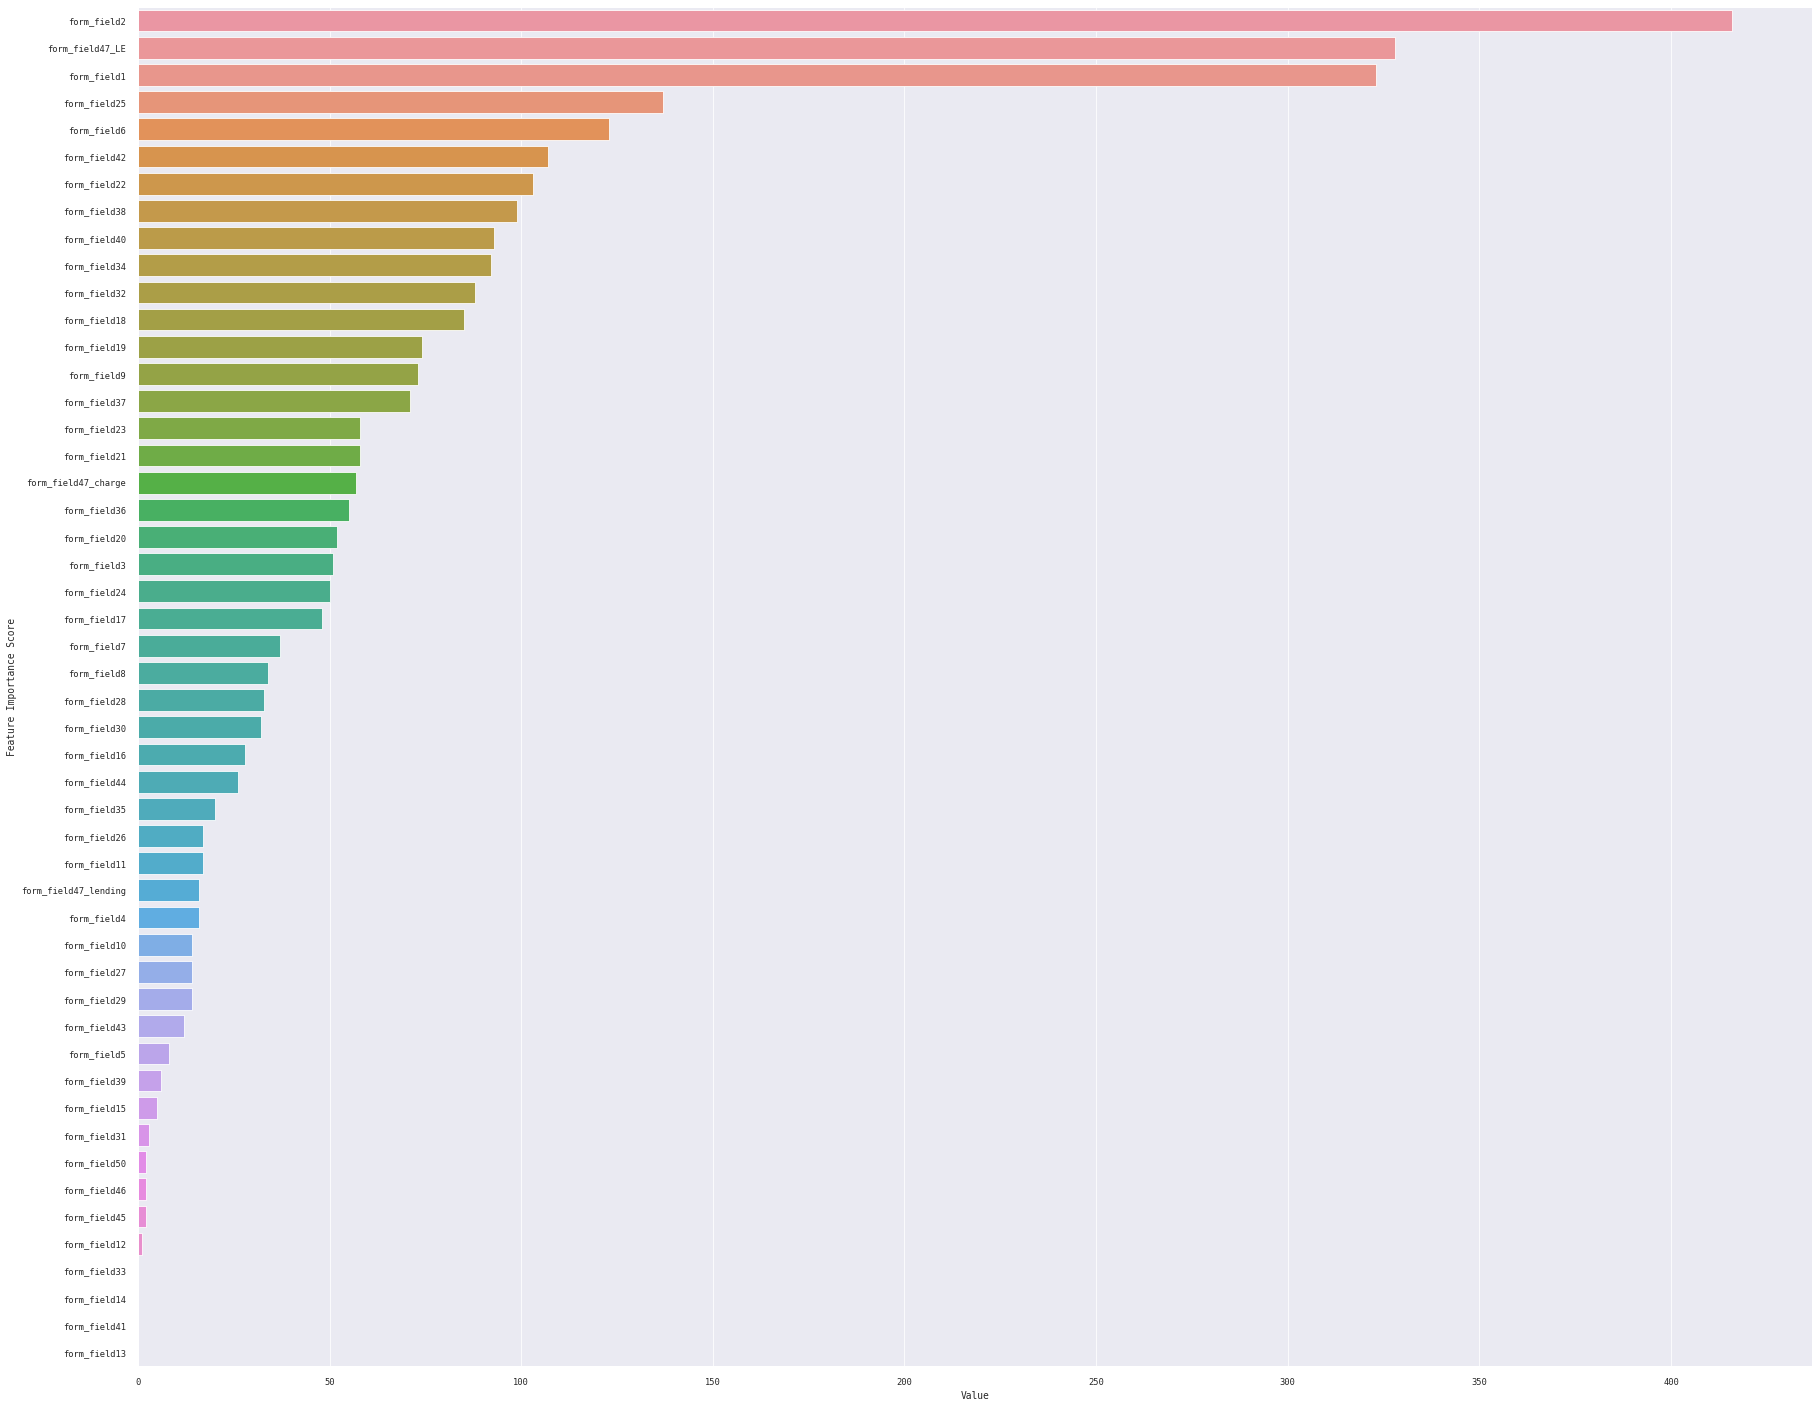

0.8266570991173605 0.8359713727851638


In [ ]:
lgb_model = lgb.LGBMClassifier(objective = 'binary', 
                            metric= 'auc',
                            boosting_type= 'gbdt',
                            learning_rate = 0.008,
                            feature_pre_filter = False,
                            lambda_l1= 0.0,
                            lambda_l2= 0.0,
                            num_leaves= 31,
                            feature_fraction= 0.7,
                            bagging_fraction= 0.997002650643244,
                            bagging_freq= 7,
                            min_child_samples= 20) 
                           

func_= func(train_df, target, test_df, lgb_model, 'lgbm', 1000)
val_p6, test_p6, model6 = func_()

In [ ]:
np.savez(path+'models/lgb_2', val=val_p6, test=test_p6)

pickle.dump(model6, open(path+'models/lgb_2.sav', 'wb'))

### Model7: RandomForest

================================Fold1====================================

Validation scores 0.8272586094520502
Training scores 0.998998715872342
================================Fold2====================================

Validation scores 0.8374642697542358
Training scores 0.9989796392422886
================================Fold3====================================

Validation scores 0.8316023793890229
Training scores 0.9989442384324032
================================Fold4====================================

Validation scores 0.8277407618784474
Training scores 0.9989509066847765
================================Fold5====================================
 0.8361822668977135
Training scores 0.998964175070105
================================Fold6====================================

Validation scores 0.8350814781920337
Training scores 0.9989345114118842
================================Fold7====================================

Validation scores 0.8156626584949428
Training scores 0.99896787

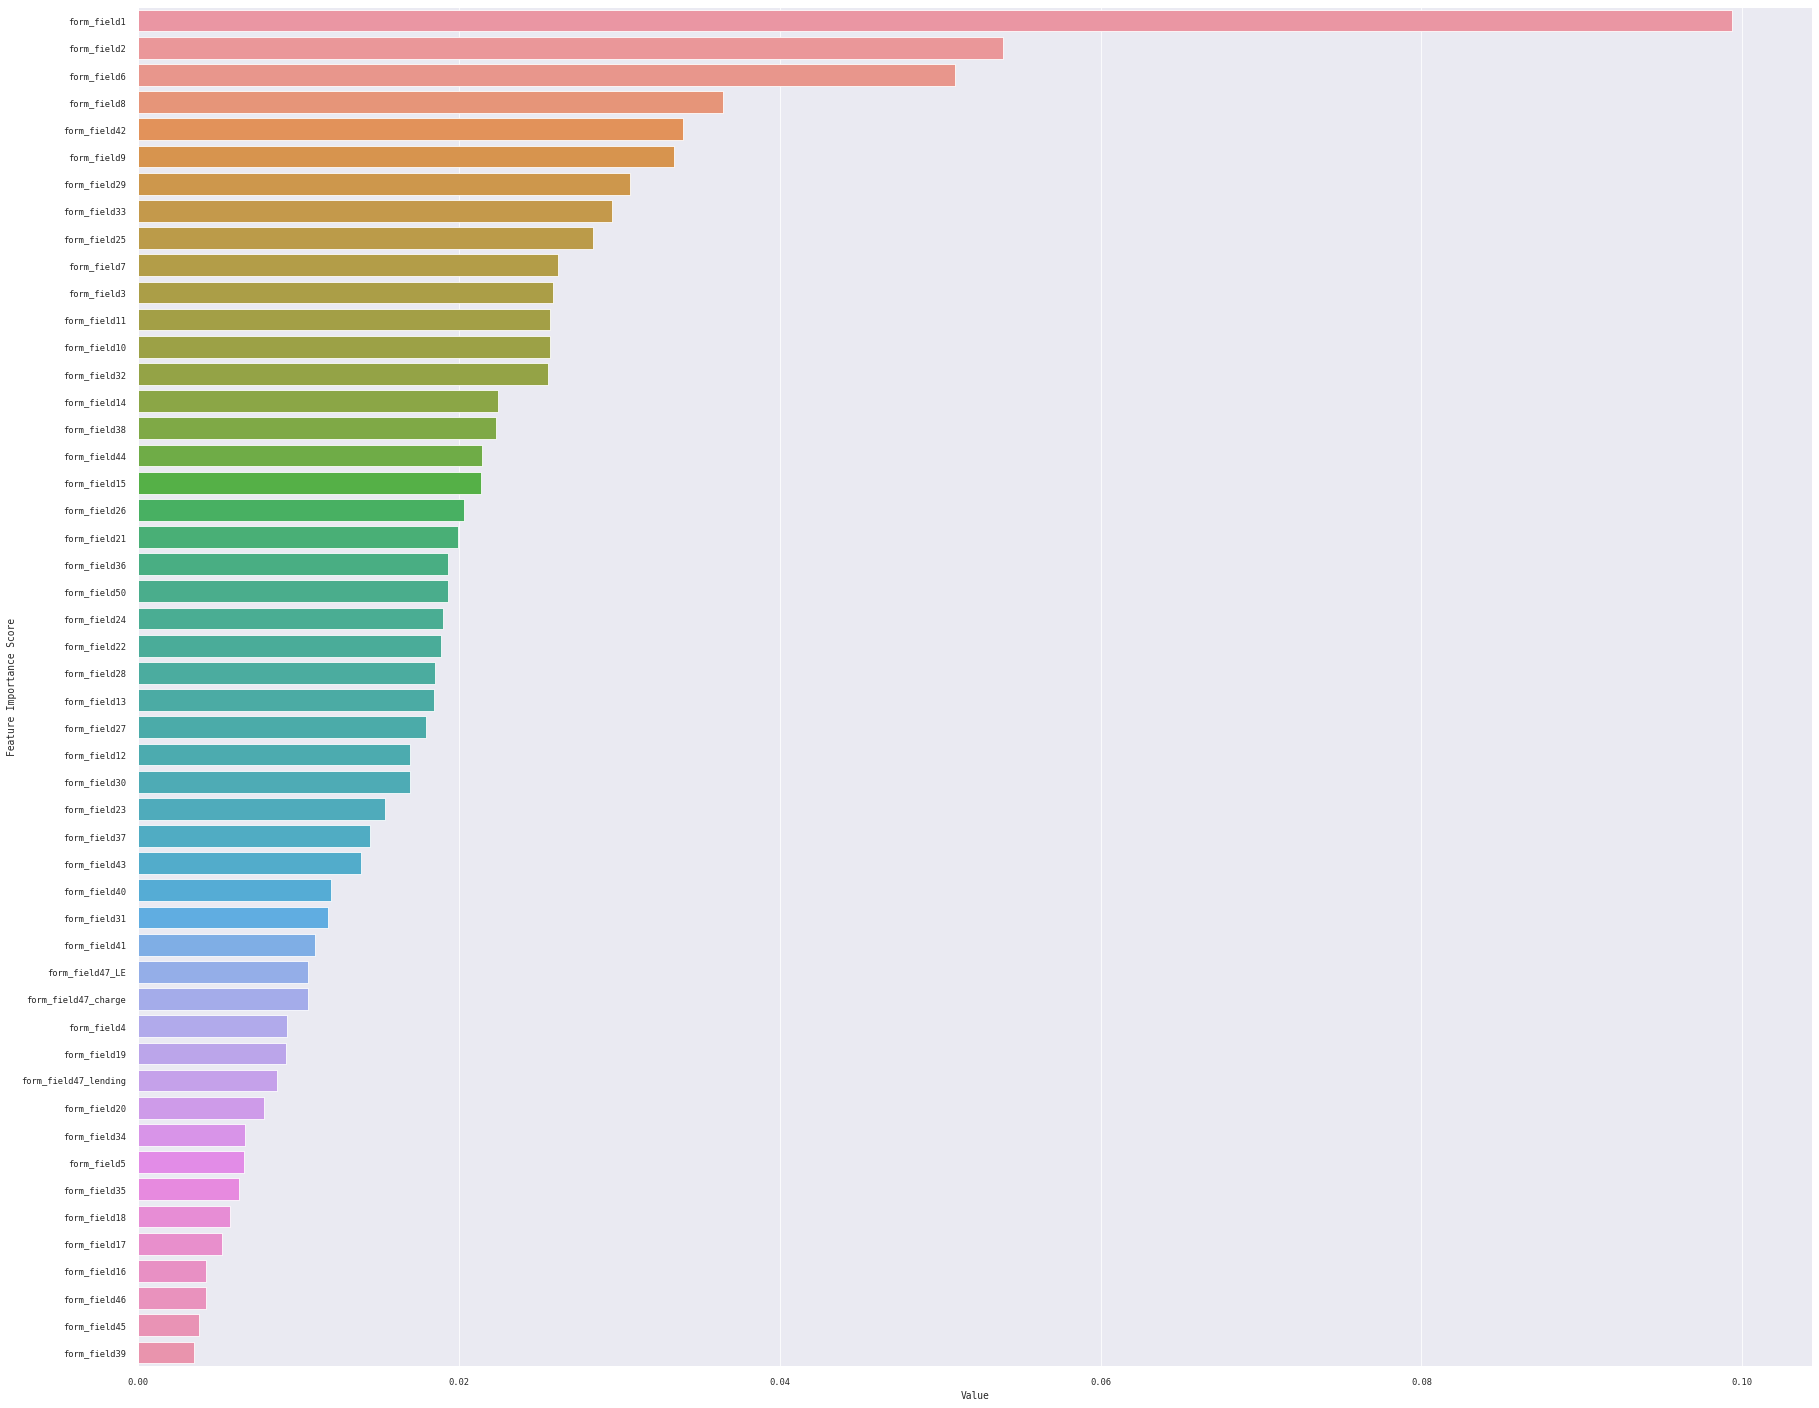

0.8330534157497327 0.998973222653612


In [ ]:
rf = RandomForestClassifier(n_estimators=175,
                            max_features=0.26199442202904993,
                            max_depth=26,
                            min_samples_split=3,
                            min_samples_leaf=2,
                            max_samples=0.7461601739133683)

func_= func(train_df, target, test_df, rf, 'rf', 1000)
val_p7, test_p7, model7 = func_()

In [ ]:
np.savez(path+'models/rf_1', val=val_p7, test=test_p7)

pickle.dump(model7, open(path+'models/rf_1.sav', 'wb'))

### Model8: VotingClassifier for previous trained models

In [ ]:
# load previously saved models
cb1 = pickle.load(open(path+'models/cb_1.sav', 'rb'))
cb2 = pickle.load(open(path+'models/cb_2.sav', 'rb'))

xgb1 = pickle.load(open(path+'models/xgb_1.sav', 'rb'))
xgb2 = pickle.load(open(path+'models/xgb_2.sav', 'rb'))

lgb1 = pickle.load(open(path+'models/lgb_1.sav', 'rb'))
lgb2 = pickle.load(open(path+'models/lgb_2.sav', 'rb'))

rf = pickle.load(open(path+'models/rf_1.sav', 'rb'))

In [ ]:
models = []
models.append(('cb1', cb1))
models.append(('cb2', cb2))
models.append(('xgb1', xgb1))
models.append(('xgb2', xgb2))
models.append(('lgb1', lgb1))
models.append(('lgb2', lgb2))
models.append(('rf', rf))

In [ ]:
# helper function 
class vote_func():    
    def __init__(self, train, label, test, model, model_type, random_state):
        self.train, self.label, self.test = train, label, test
        self.model, self.model_type = model, model_type
        self.random_state = random_state
        
        assert self.model_type in ('vote_clf'), 'Incorrect model_type'

    def __call__(self, plot = True):
        return self.fit(plot)

    def fit(self, plot):
        def clf_fit(X_train, X_test, y_train, y_test):
          self.model.fit(X_train,y_train)
          x_test_predict = self.model.predict_proba(X_test)[:,1]
          x_train_predict = self.model.predict_proba(X_train)[:,1]
          self.val_p[test_index] = x_test_predict
          self.test_p += self.model.predict_proba(self.test)[:,1]
          return x_test_predict, x_train_predict


        self.val_p = np.zeros(self.train.shape[0])
        mean_val = []
        mean_train = []
        self.test_p = np.zeros(self.test.shape[0])
        splits = 15
        kf = StratifiedKFold(n_splits = splits)
        for fold_count, (train_index, test_index) in enumerate(kf.split(self.train, self.label)):
            X_train,X_test = self.train.iloc[train_index],self.train.iloc[test_index]
            y_train,y_test = self.label.iloc[train_index],self.label.iloc[test_index]

            print(f"================================Fold{fold_count+1}====================================")
            if self.model_type == 'vote_clf': x_test_predict, x_train_predict = clf_fit(X_train, X_test, y_train, y_test)
            
            print('\nValidation scores', roc_auc_score(y_test, x_test_predict))
            print('Training scores', roc_auc_score(y_train, x_train_predict))
            mean_val.append(roc_auc_score(y_test, x_test_predict))
            mean_train.append(roc_auc_score(y_train, x_train_predict))

        print(np.mean(mean_val), np.mean(mean_train), np.std(mean_val))
        return self.val_p, self.test_p/splits, self.model

In [ ]:
from sklearn.ensemble import VotingClassifier

clf = VotingClassifier(estimators=models,
                       voting='soft')

func_= vote_func(train_df, target, test_df, rf, 'vote_clf', 1000)
val_vote, test_vote, model_vote = func_()

================================Fold1====================================

Validation scores 0.8245521703816996
Training scores 0.9989797438380505
================================Fold2====================================

Validation scores 0.8444683519521126
Training scores 0.9989846570861627
================================Fold3====================================

Validation scores 0.8311285442072432
Training scores 0.9989203186762023
================================Fold4====================================

Validation scores 0.837593263510488
Training scores 0.9989858913368469
================================Fold5====================================

Validation scores 0.814885718882602
Training scores 0.9989685870828688
================================Fold6====================================

Validation scores 0.8387277872951829
Training scores 0.9990049767315305
================================Fold7====================================

Validation scores 0.8331624340304109
Training

In [ ]:
np.savez(path+'models/vote_clf', val=val_vote, test=test_vote)

pickle.dump(model_vote, open(path+'models/vote.sav', 'wb'))


### Model stacking 

In [ ]:
# load previously saved outputs
cb_1 = np.load(path+'models/cb_1.npz')
cb_2 = np.load(path+'models/cb_2.npz')

xgb_1 = np.load(path+'models/xgb_1.npz')
xgb_2 = np.load(path+'models/xgb_2.npz')

lgb_1 = np.load(path+'models/lgb_1.npz')
lgb_2 = np.load(path+'models/lgb_2.npz')

rf_1 = np.load(path+'models/rf_1.npz')

vote = np.load(path+'models/vote_clf.npz')

In [ ]:
# stack outputs for test and val set, then predict with LogisticRegression
from sklearn.linear_model import  LogisticRegression
stack = np.column_stack((cb_1['val'], cb_2['val'], xgb_1['val'], 
                         xgb_2['val'], lgb_1['val'], lgb_2['val'], 
                        vote['val']))
stack_p = np.column_stack((cb_1['test'], cb_2['test'], xgb_1['test'], 
                           xgb_2['test'], lgb_1['test'], lgb_2['test'], 
                           vote['test']))
predict = LogisticRegression().fit(stack, target).predict_proba(stack_p)[:,1]

NameError: ignored

In [ ]:
sub['default_status'] = predict
sub.head()

,Applicant_ID,default_status
0,Apcnt_1000032,0.2770
1,Apcnt_1000048,0.3103
2,Apcnt_1000052,0.3473
3,Apcnt_1000076,0.8045
4,Apcnt_1000080,0.1317


In [ ]:
sub.to_csv(path+'submission.csv', index = False)